# Weather Forecast - Modelling

## Import Data for Modelling

Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

import warnings
warnings.filterwarnings("ignore")

Importing Data

In [2]:
filename = 'modelling_data.csv'
data_df = pd.read_csv(filename)
data_df.head()

Date  Atmospheric Pressure  Minimum Temperature  Maximum Temperature  \
0  2018-01-01                1019.5                 16.3                 26.1   
1  2018-01-02                1019.6                 16.1                 27.4   
2  2018-01-03                1019.9                 15.7                 27.2   
3  2018-01-04                1021.4                 16.0                 29.0   
4  2018-01-05                1021.2                 14.2                 26.9   

   Relative Humidity  Wind Speed  
0          25.333333    9.666667  
1          27.583333   12.000000  
2          24.416667   11.666667  
3          27.166667   12.333333  
4          29.916667   12.333333

Computing the Mean Temperature

In [3]:
data_df['Mean Temperature'] = pd.Series(np.mean([data_df['Minimum Temperature'], data_df['Maximum Temperature']], axis=0))
data_df.head()

Date  Atmospheric Pressure  Minimum Temperature  Maximum Temperature  \
0  2018-01-01                1019.5                 16.3                 26.1   
1  2018-01-02                1019.6                 16.1                 27.4   
2  2018-01-03                1019.9                 15.7                 27.2   
3  2018-01-04                1021.4                 16.0                 29.0   
4  2018-01-05                1021.2                 14.2                 26.9   

   Relative Humidity  Wind Speed  Mean Temperature  
0          25.333333    9.666667             21.20  
1          27.583333   12.000000             21.75  
2          24.416667   11.666667             21.45  
3          27.166667   12.333333             22.50  
4          29.916667   12.333333             20.55

In [4]:
data_df.shape

(1096, 7)

## LSTM - Weather Forecasting

In [5]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization, Bidirectional, Conv1D

from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.metrics import r2_score, mean_squared_error

from keras.layers import ConvLSTM2D

Using TensorFlow backend.


Convert DataFrame to Numpy Array

In [6]:
date_series = data_df['Date']
data_array = data_df.iloc[:, 1:].values
data_array.shape, data_array.dtype, date_series.shape

((1096, 6), dtype('float64'), (1096,))

Scaling of Dataset to avoid gradient explosion. 

__N.B:__ One importance of fit-transform is that the scaling can easily be inverted.

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(data_array)
data_array = scaler.transform(data_array)
data_array.shape, data_array.dtype

((1096, 6), dtype('float64'))

Preparing the training and testing data for LSTM

In [8]:
def train_test_data_for_lstm(data, n_past, n_future=1, test_num=30, view_shape=False):
    """
    Function to determine the training and testing data for a recurrent neural network modelling.
    
    Input:
    data - numpy array of the data to be modelled
    n-past - the number of days in the past to be utilised for modelling
    n-future - the date in the future to be predicted.
    test_num - the number of days that would be used for model testing
    
    Output:
    train- a tuple containing the training features
    train - a tuple containing the training targets
    """
    
    # Define list to store X and Y datasets
    X = []
    Y = []
    
    for i in range(n_past, len(data) - n_future +1):
        X.append(data[i - n_past:i, 0:data.shape[1] - 1])
        Y.append(data[i + n_future - 1:i + n_future, data.shape[1] - 1])

    # Converting list to numpy array
    X, Y = np.array(X), np.array(Y)
    
    # Train-Test Split
    trainX = X[0:-test_num,:]
    testX = X[-test_num:len(data),:]
    
    trainY = Y[0:-test_num,:]
    testY = Y[-test_num:len(data),:]
    
    if view_shape:
        print('data shape == {}.'.format(data.shape))
        
        print('trainX shape == {}.'.format(trainX.shape))
        print('trainY shape == {}.'.format(trainY.shape))
        
        print('testX shape == {}.'.format(testX.shape))
        print('testY shape == {}.'.format(testY.shape))
        
    return (trainX, trainY), (testX, testY)   

In [9]:
(trainX, trainY), (testX, testY) = train_test_data_for_lstm(data_array, 21, 1, 30, True)

data shape == (1096, 6).
trainX shape == (1045, 21, 5).
trainY shape == (1045, 1).
testX shape == (30, 21, 5).
testY shape == (30, 1).


In [10]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 21, 32)            512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [11]:
weather_model = model.fit(trainX, trainY, epochs=5, batch_size=8, validation_split=0.1, verbose=1)

Train on 940 samples, validate on 105 samples
Epoch 1/5
940/940 [==============================] - 20s 21ms/step - loss: 0.0389 - val_loss: 0.0072- 
Epoch 2/5
940/940 [==============================] - 13s 14ms/step - loss: 0.0178 - val_loss: 0.0080
Epoch 3/5
940/940 [==============================] - 12s 13ms/step - loss: 0.0168 - val_loss: 0.0077
Epoch 4/5
940/940 [==============================] - 12s 13ms/step - loss: 0.0153 - val_loss: 0.0063
Epoch 5/5
940/940 [==============================] - 12s 13ms/step - loss: 0.0149 - val_loss: 0.0061


Plot the graph of the training loss and the validation loss for the developed model.

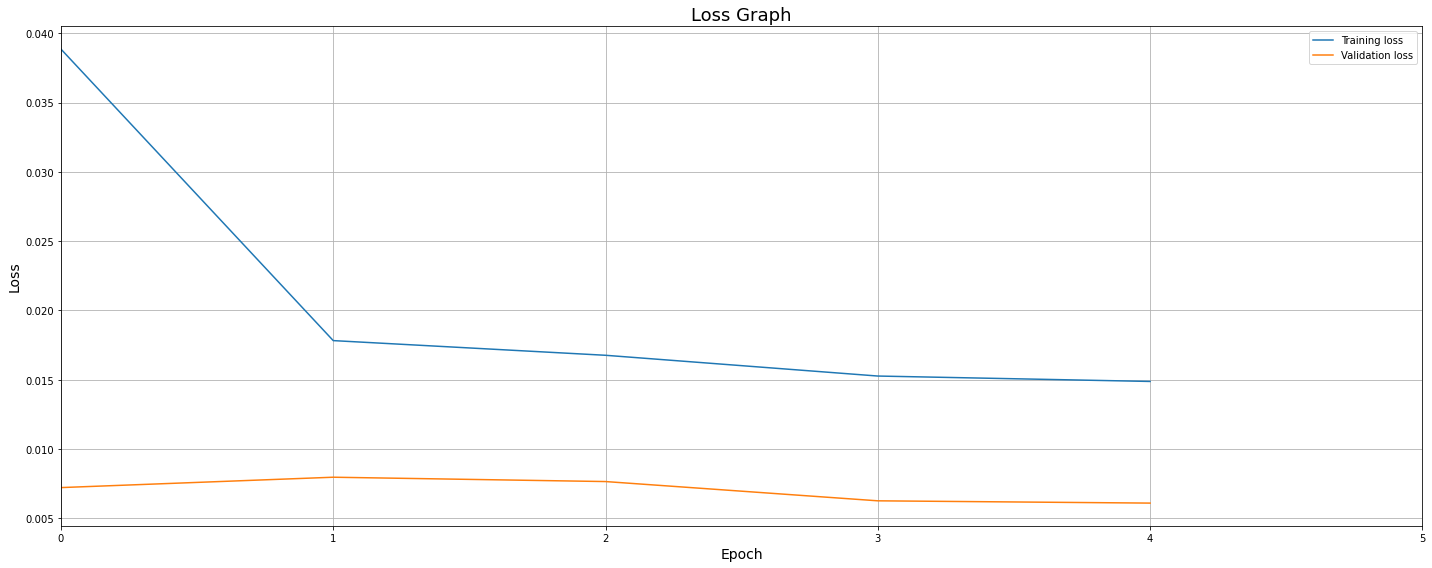

In [12]:
plt.figure(figsize=(20, 8))

plt.plot(weather_model.history['loss'], label='Training loss')
plt.plot(weather_model.history['val_loss'], label='Validation loss')

plt.title('Loss Graph', fontsize=18)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()

plt.xlim(0, len(weather_model.history['val_loss']))

plt.tight_layout()
plt.grid(True)

In [13]:
min(weather_model.history['loss']), min(weather_model.history['val_loss'])

(0.01487668604451291, 0.0060953240597709304)

### Model Accuracy

In [14]:
def model_accuracy(model, testX, testY, view = False):
    
    y_pred = model.predict(testX)
    y_true = testY
    
    rmse = mean_squared_error(y_true, y_pred)
    r2score = r2_score(y_true, y_pred)
    
    if view:
        print(f'Root mean square error: {rmse}')
        print(f'R2 Score: {r2score}')
        
    return rmse, r2score    

In [15]:
model_accuracy(model, testX, testY, True)

Root mean square error: 0.007601804357146775
R2 Score: 0.12105078086925314


(0.007601804357146775, 0.12105078086925314)

### Forecasting

In [16]:
n_future = 30
forecast_dates = pd.date_range(list(date_series)[-n_future], periods=n_future, freq='1d')

forecast = model.predict(testX)

forecast_copies = np.repeat(forecast, data_array.shape[1], axis=1)

y_pred = scaler.inverse_transform(forecast_copies)[:, -1]

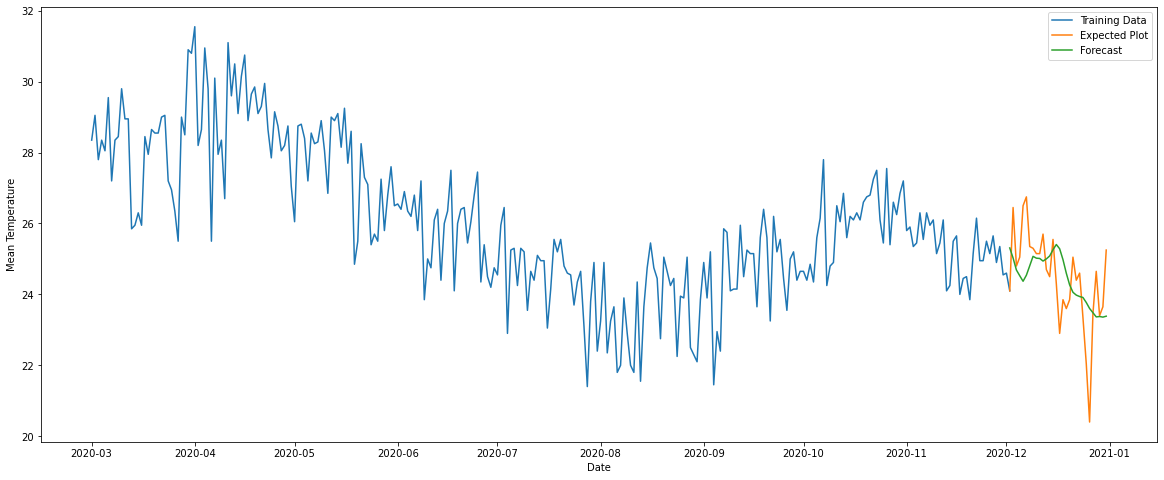

In [17]:
train_df = pd.DataFrame({'Date':np.array(data_df['Date'][0:-n_future+1]), 'Mean Temperature':np.array(data_df['Mean Temperature'][0:-n_future+1])})
test_df = pd.DataFrame({'Date':np.array(data_df['Date'][-n_future:]), 'Mean Temperature':np.array(data_df['Mean Temperature'][-n_future:])})
predict_df = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Temperature':y_pred})

train_df['Date'] = pd.to_datetime(train_df['Date'])
test_df['Date'] = pd.to_datetime(test_df['Date'])
predict_df['Date'] = pd.to_datetime(predict_df['Date'])

train_df = train_df.loc[train_df['Date'] >= '2020-3-1']


plt.figure(figsize=(20, 8))
sb.lineplot(train_df['Date'], train_df['Mean Temperature'])
sb.lineplot(test_df['Date'], test_df['Mean Temperature'])
sb.lineplot(predict_df['Date'], predict_df['Mean Temperature'])

plt.legend(['Training Data', 'Expected Plot', 'Forecast'])

### Hyperparameters Tuning

From the above graph, there is need for hyperparameter tuning to determine the best model to be used. 

We tune on the following parameters: 
1. Conv1D Filter (16, 32, 64)
2. Bidirectional LSTM units (25, 50, 75, 100)
3. Activation Function ('relu', 'tanh')
4. Dropout (0.1, 0.15, 0.2, 0.25)
5. Dense (of Fully-connected) Hidden Layer Units (100, 80, 64, 50, 32)
6. Batch Size (1, 8, 16, 32)
7. Validation Split (0.1, 0.15, 0.2)

In [18]:
def plot_loss_graph(weather_model, filters, lstm_unit, activation, dropout, hidden_layers, size, split):
    plt.figure(figsize=(20, 8))

    plt.plot(weather_model.history['loss'], label='Training loss')
    plt.plot(weather_model.history['val_loss'], label='Validation loss')

    plt.title(f'LOSS GRAPH. \n Filter: {filters} \t LSTM Units: {lstm_unit} \t Activation Function: {activation} \t Dropouts: {dropout} \n No of Hidden Fully Connected Layers: {hidden_layers} \t Batch Size: {size} \t Validation Split size: {split}', fontsize=18)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend()

    plt.xlim(0, len(weather_model.history['val_loss']))

    plt.tight_layout()
    plt.grid(True)
    
    plt.show()

In [19]:
def model_forecast(testX, data_df, date_Series, n_future = 30):
    
    forecast_dates = pd.date_range(list(date_series)[-n_future], periods=n_future, freq='1d')
    
    forecast = model.predict(testX)
    forecast_copies = np.repeat(forecast, data_array.shape[1], axis=1)
    y_pred = scaler.inverse_transform(forecast_copies)[:, -1]
    
    train_df = pd.DataFrame({'Date':np.array(data_df['Date'][0:-n_future+1]), 'Mean Temperature':np.array(data_df['Mean Temperature'][0:-n_future+1])})
    test_df = pd.DataFrame({'Date':np.array(data_df['Date'][-n_future:]), 'Mean Temperature':np.array(data_df['Mean Temperature'][-n_future:])})
    predict_df = pd.DataFrame({'Date':np.array(forecast_dates), 'Mean Temperature':y_pred})
    
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])
    predict_df['Date'] = pd.to_datetime(predict_df['Date'])
    
    train_df = train_df.loc[train_df['Date'] >= '2020-3-1']
    
    
    plt.figure(figsize=(20, 8))
    
    plt.title('Model Forecast Plot')
    
    sb.lineplot(train_df['Date'], train_df['Mean Temperature'])
    sb.lineplot(test_df['Date'], test_df['Mean Temperature'])
    sb.lineplot(predict_df['Date'], predict_df['Mean Temperature'])
    
    plt.legend(['Training Data', 'Expected Plot', 'Forecast'])
    
    plt.show()

LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50)                15200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64) 

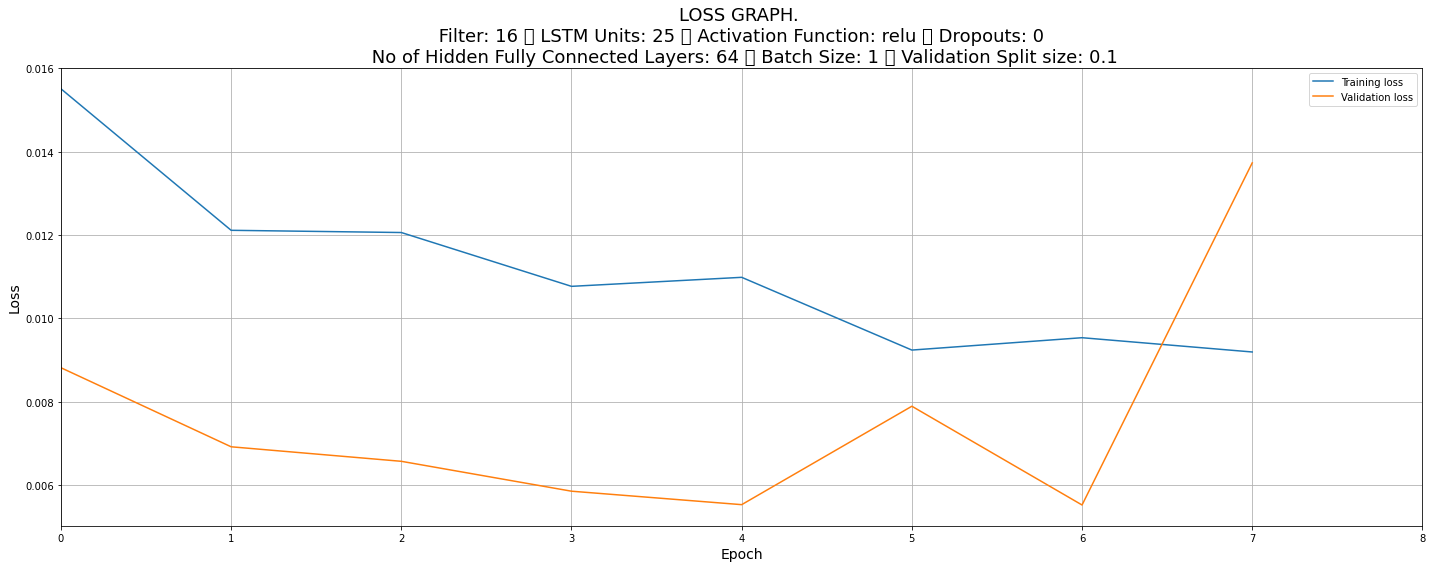

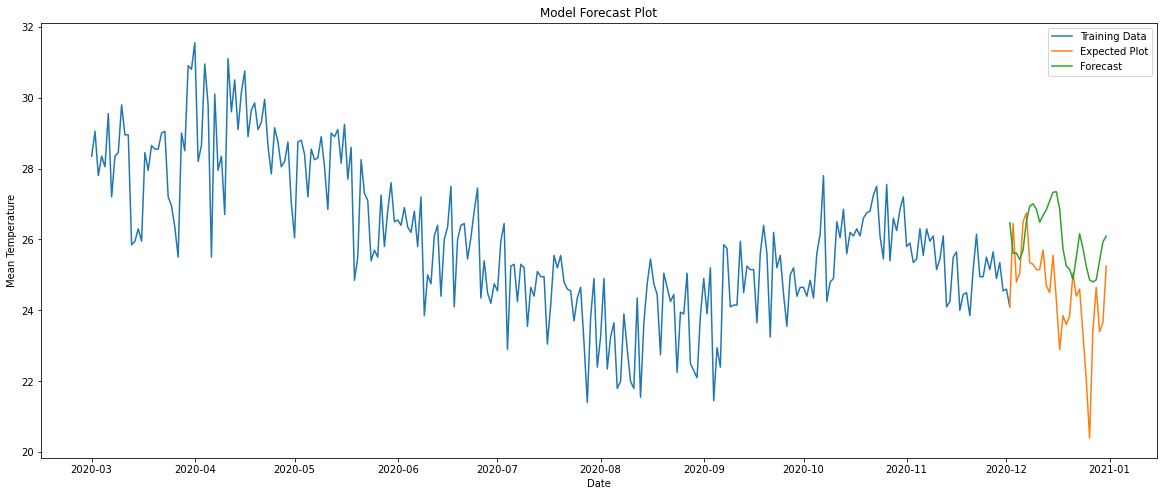









LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_7 (Bidirection (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 50)                15200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (No

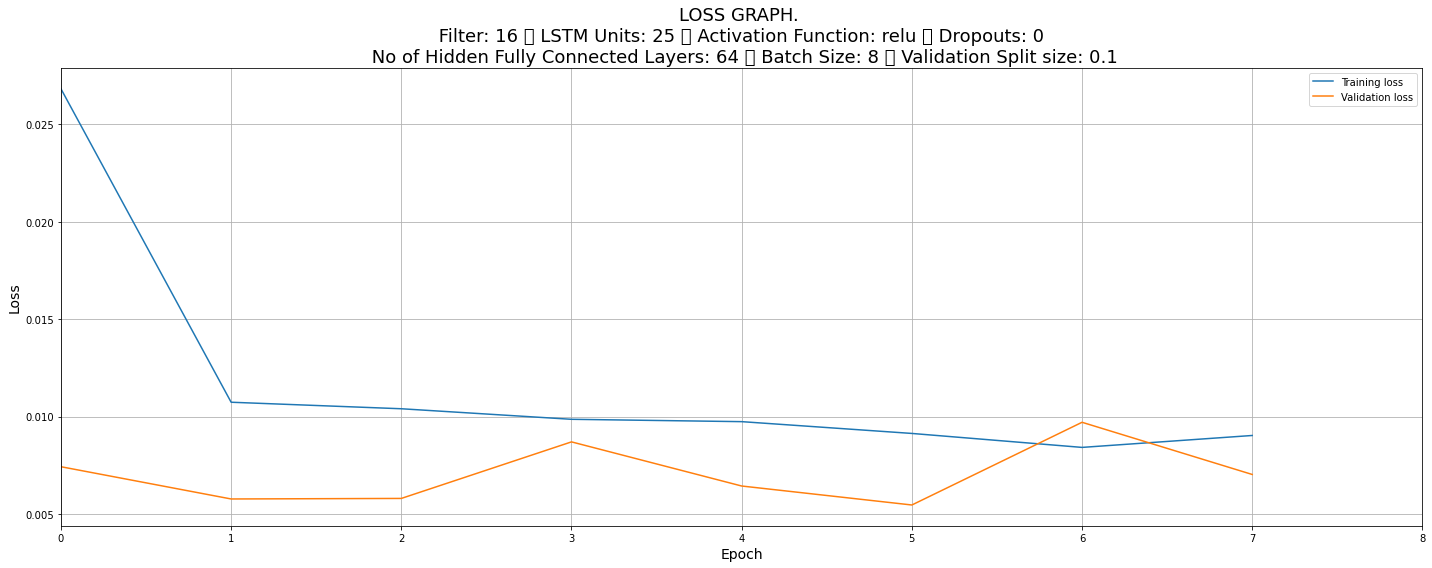

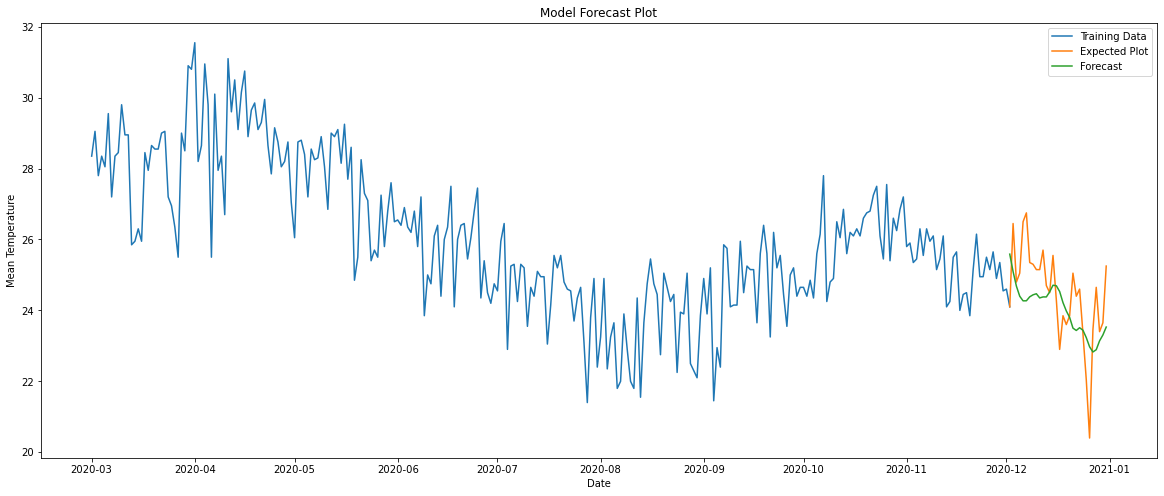









LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (N

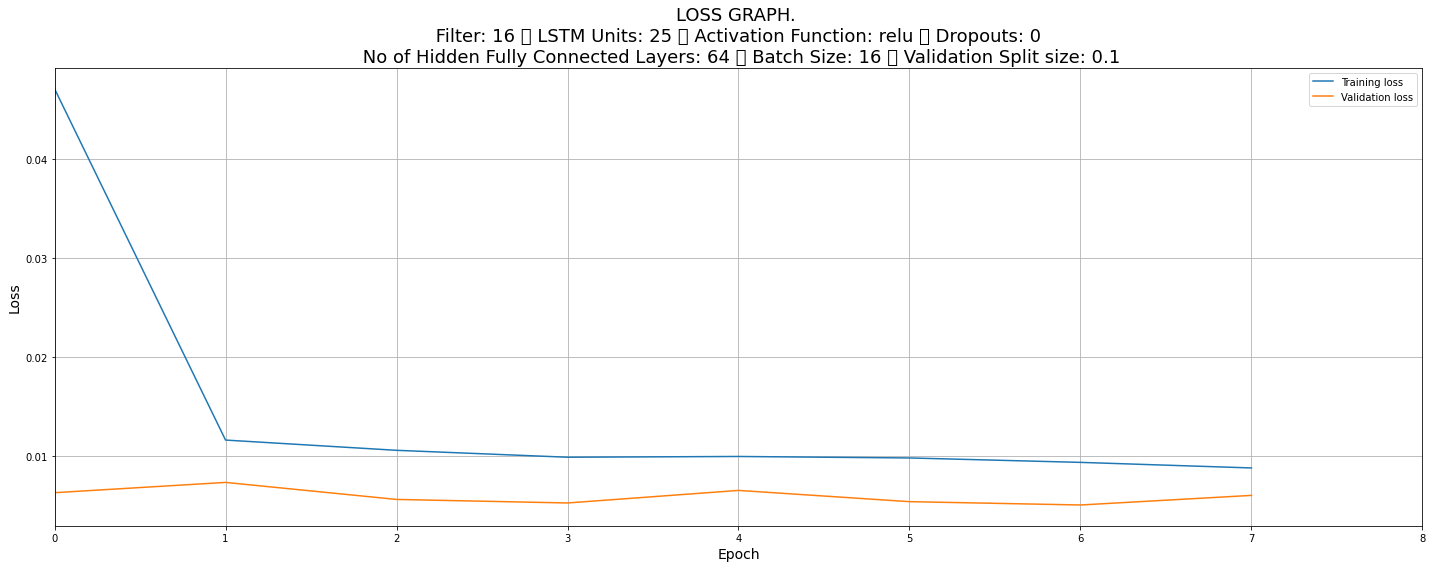

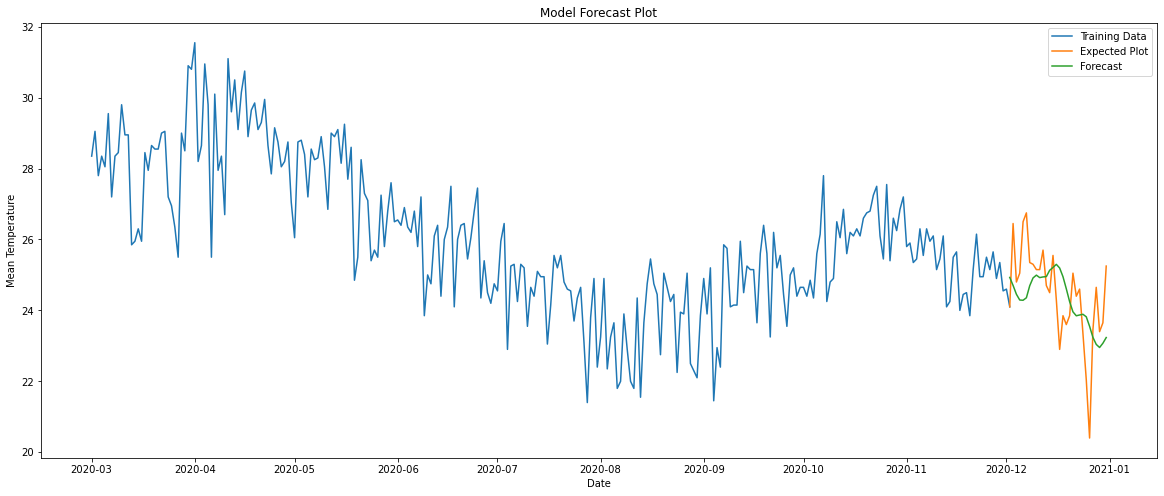









LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (

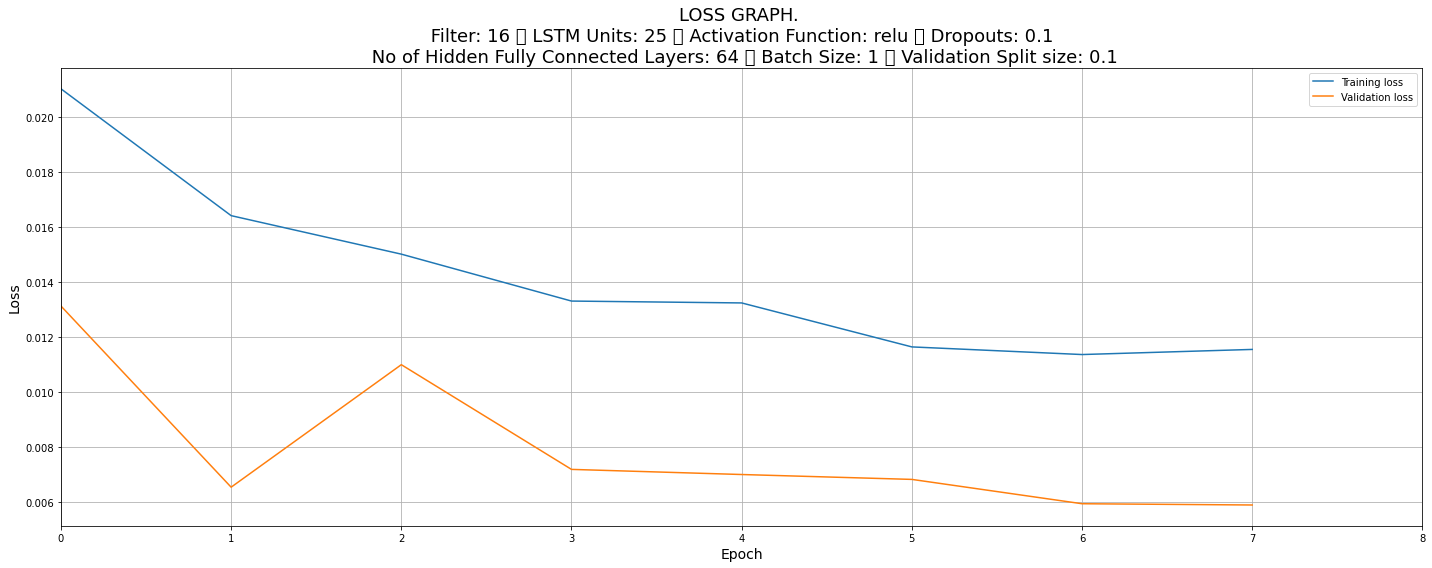

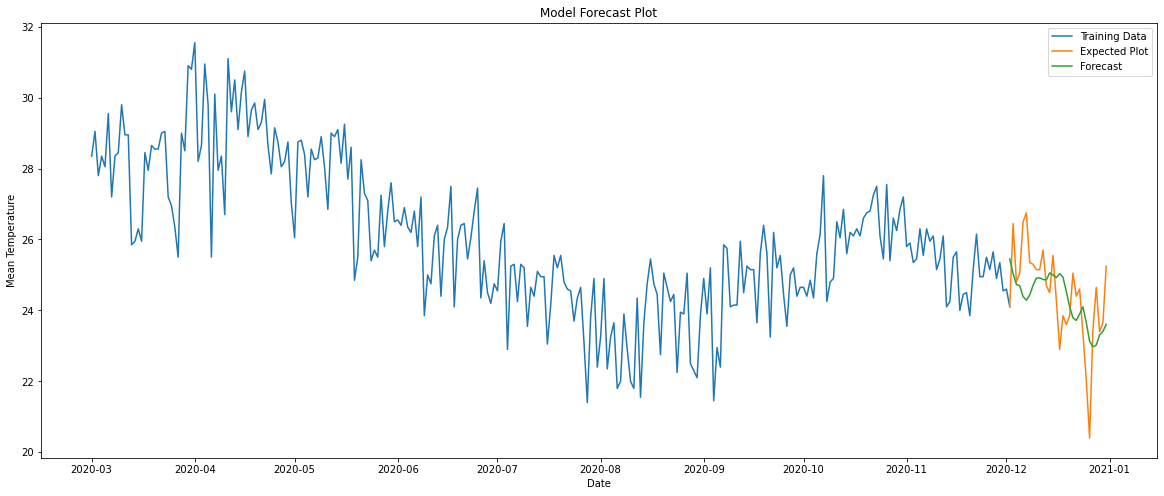









LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_16 (Dense)             (

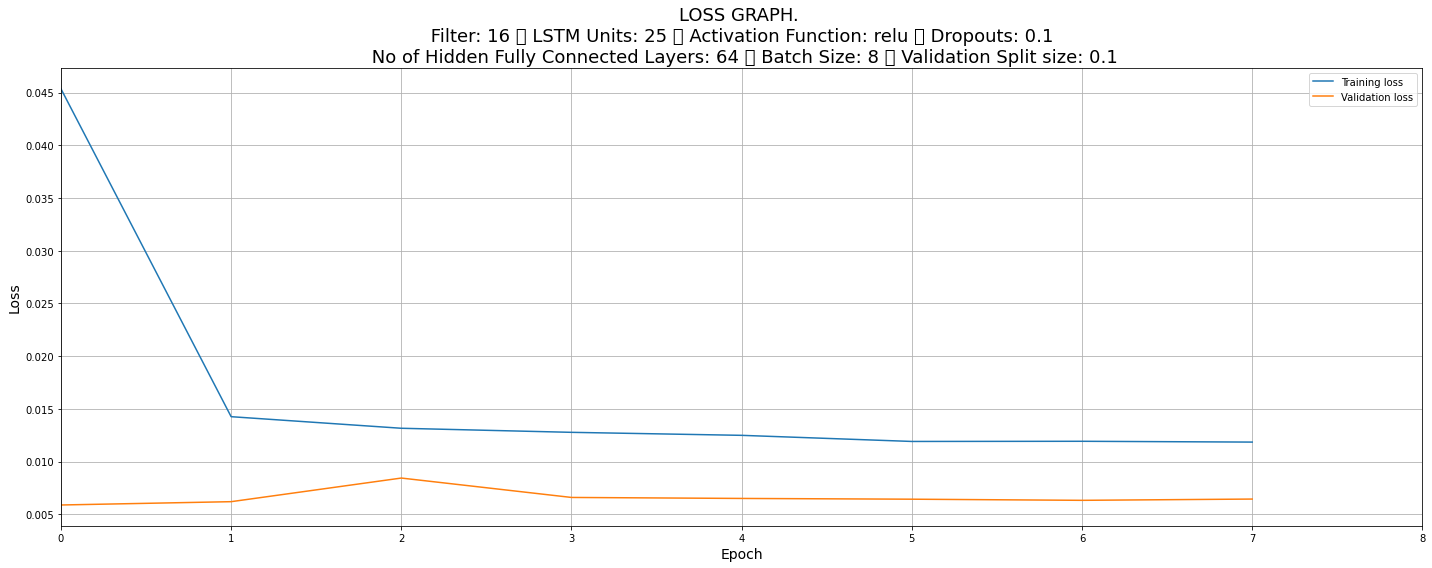

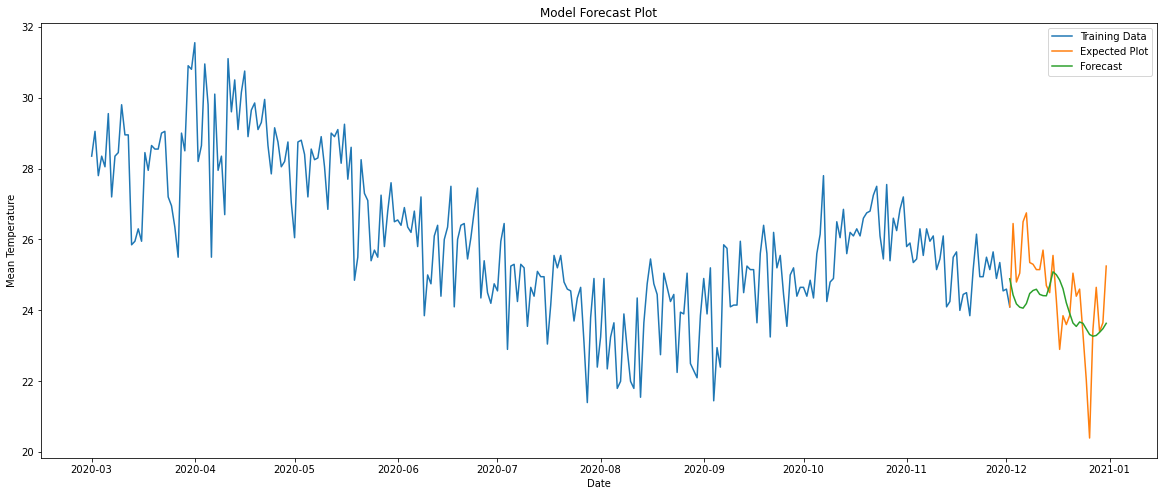









LSTM Model For:16 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_19 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             

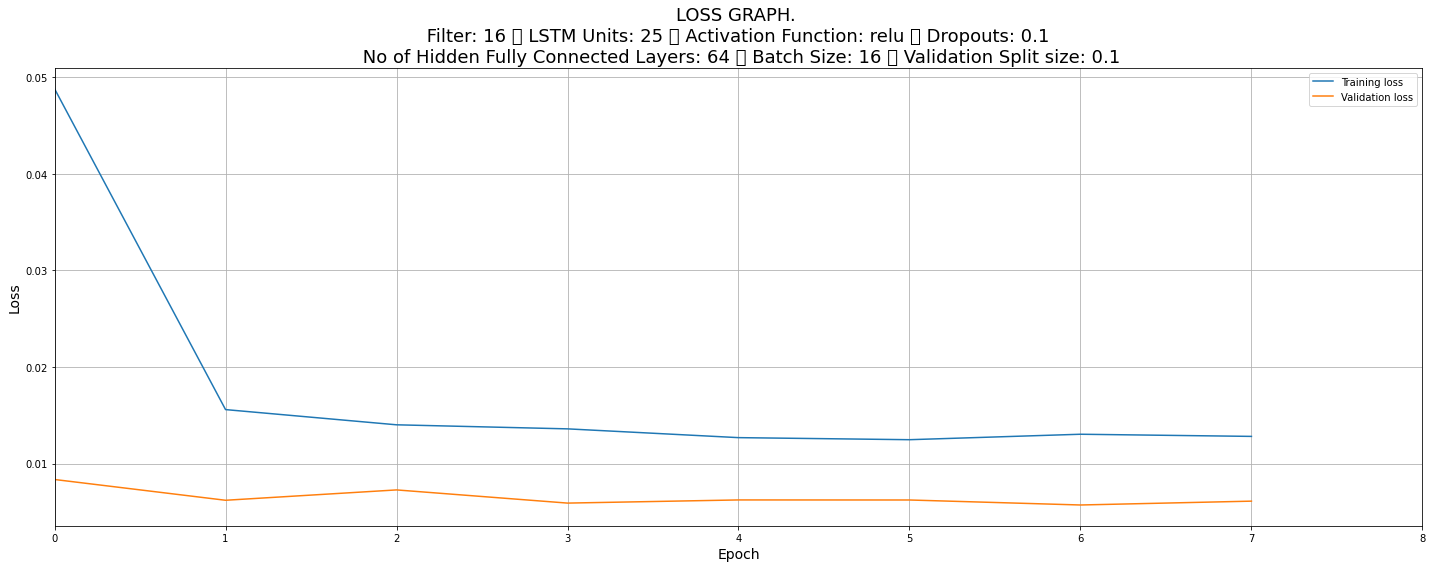

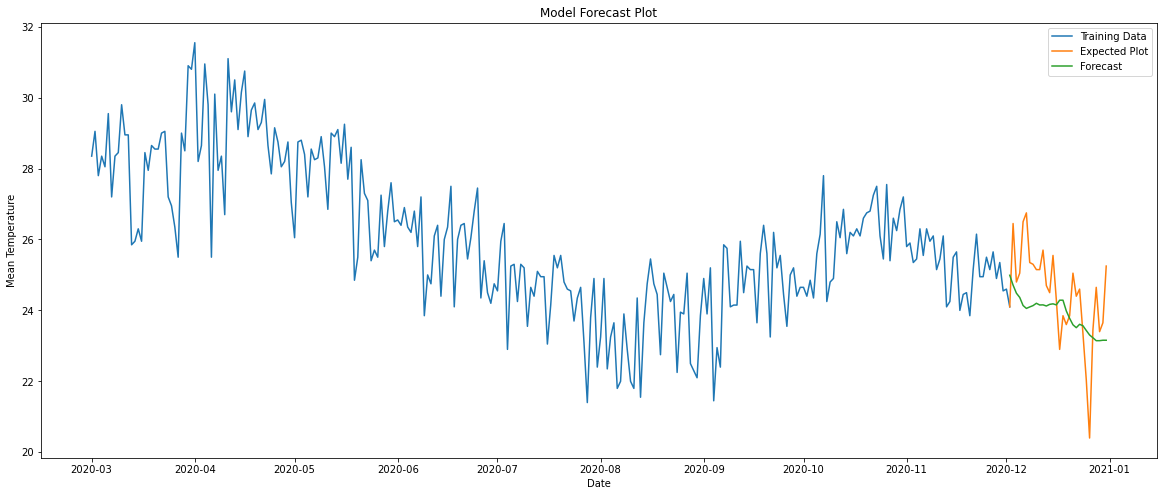









LSTM Model For:16 LSTM Units:25 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_24 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_22 (Dense)             (No

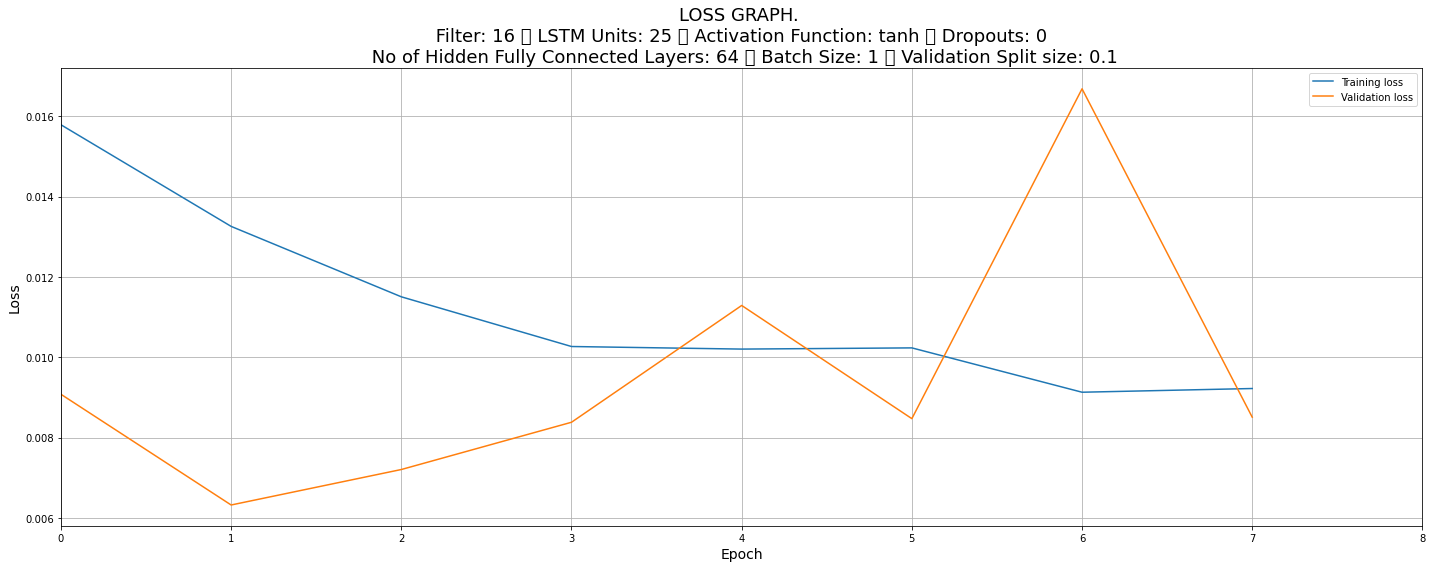

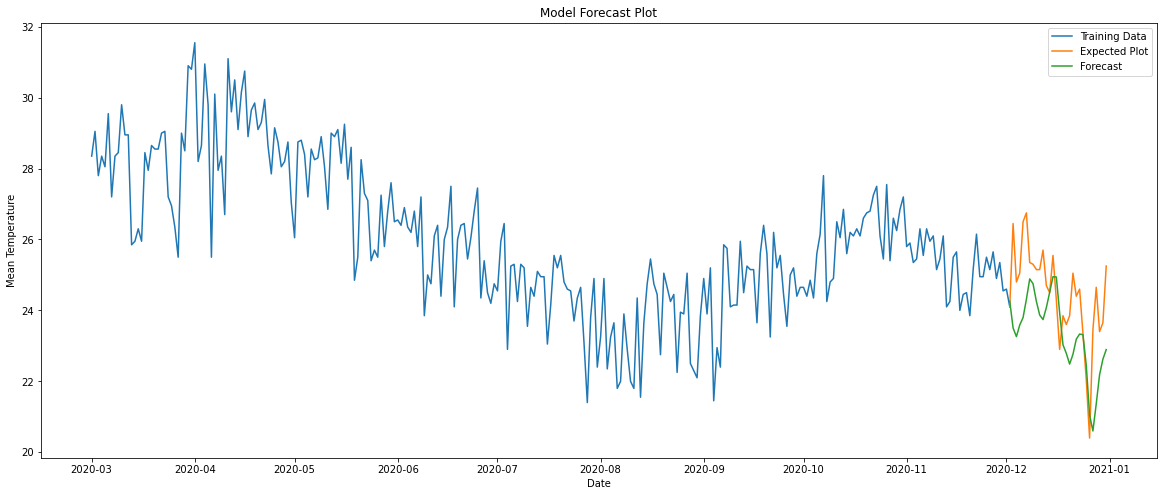









LSTM Model For:16 LSTM Units:25 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 21, 16)            256       
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_26 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_27 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_25 (Dense)             (No

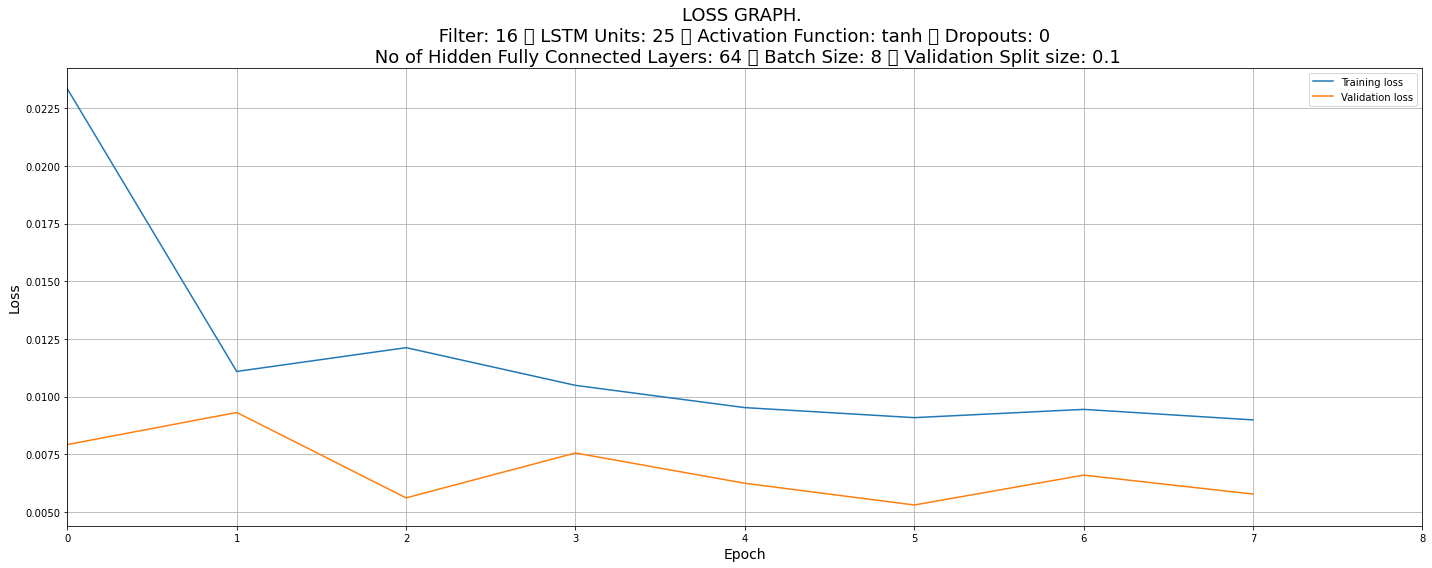

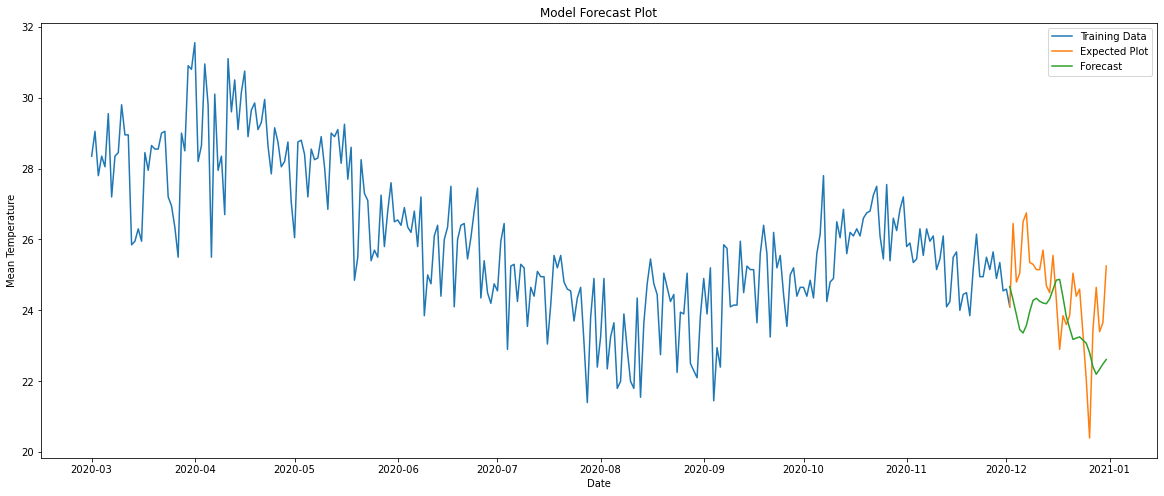









LSTM Model For:16 LSTM Units:25 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_28 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_28 (Dense)             (

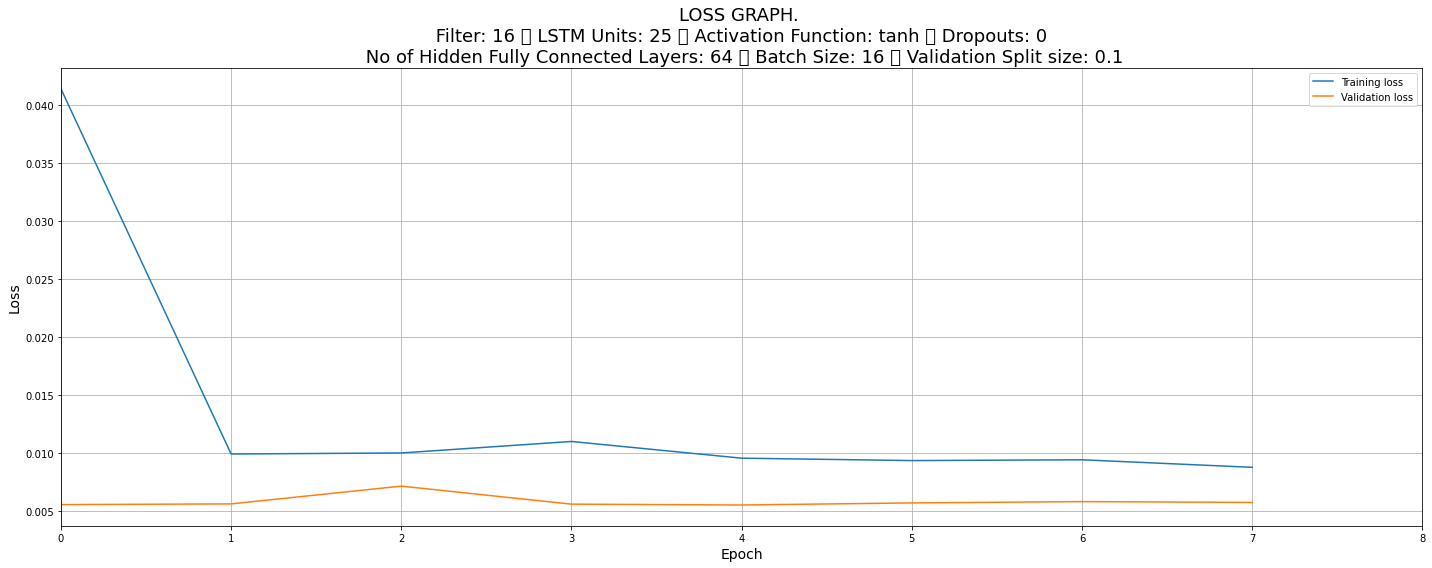

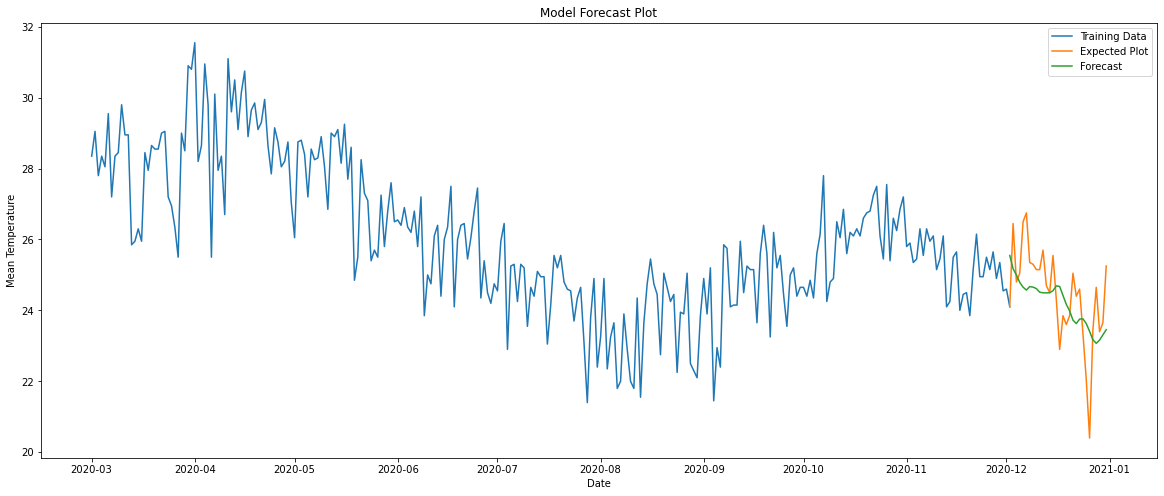









LSTM Model For:16 LSTM Units:25 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_31 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_33 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_31 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             

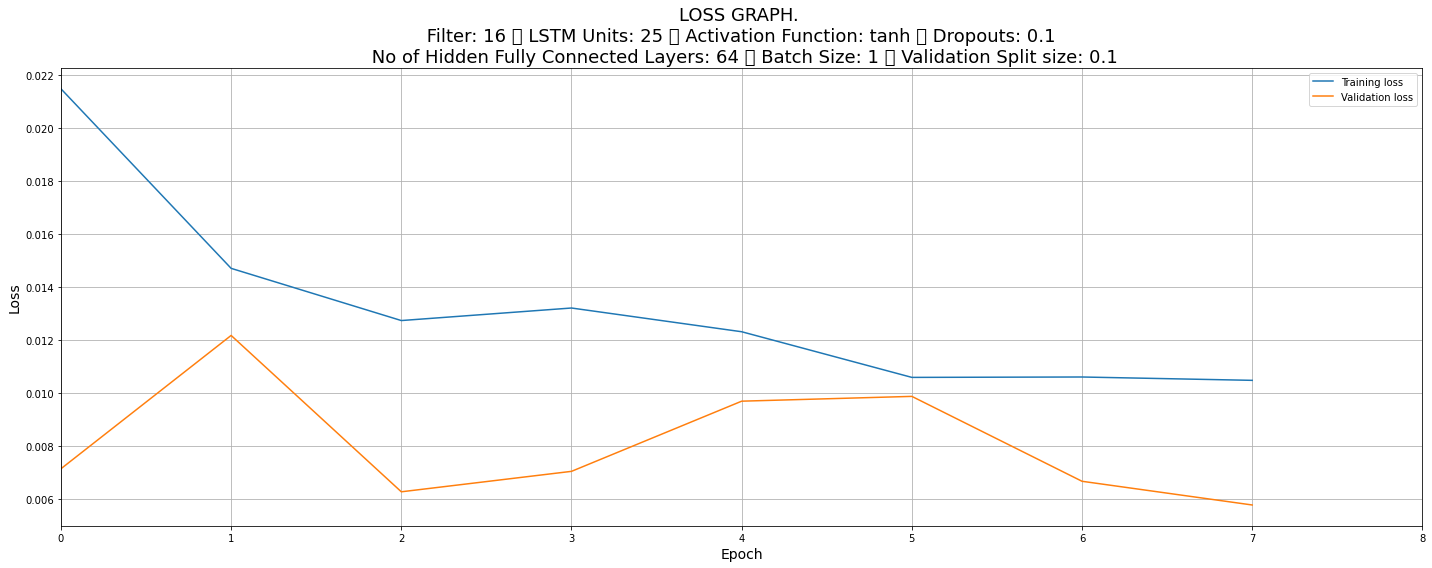

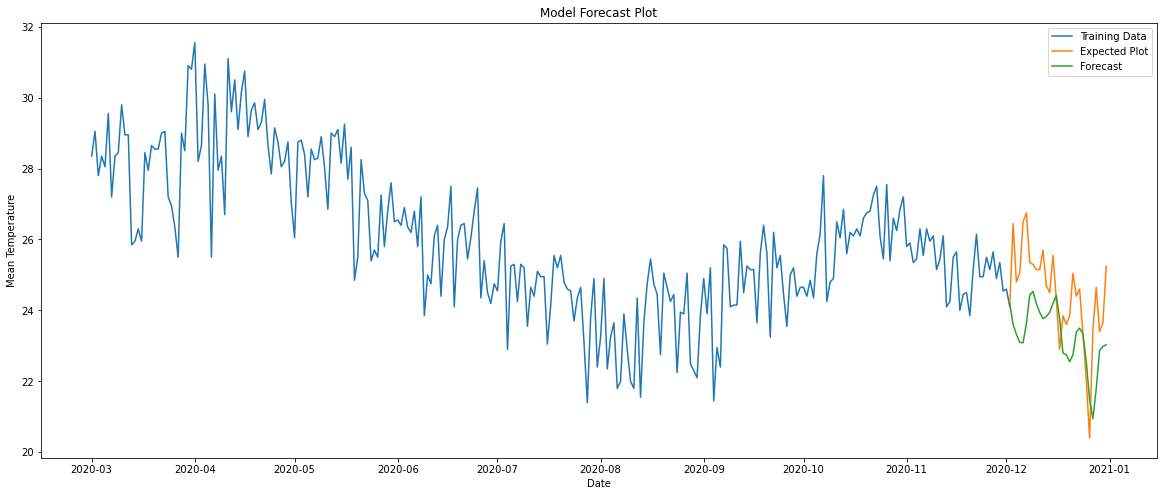









LSTM Model For:16 LSTM Units:25 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_34 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_36 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_34 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_34 (Dense)             

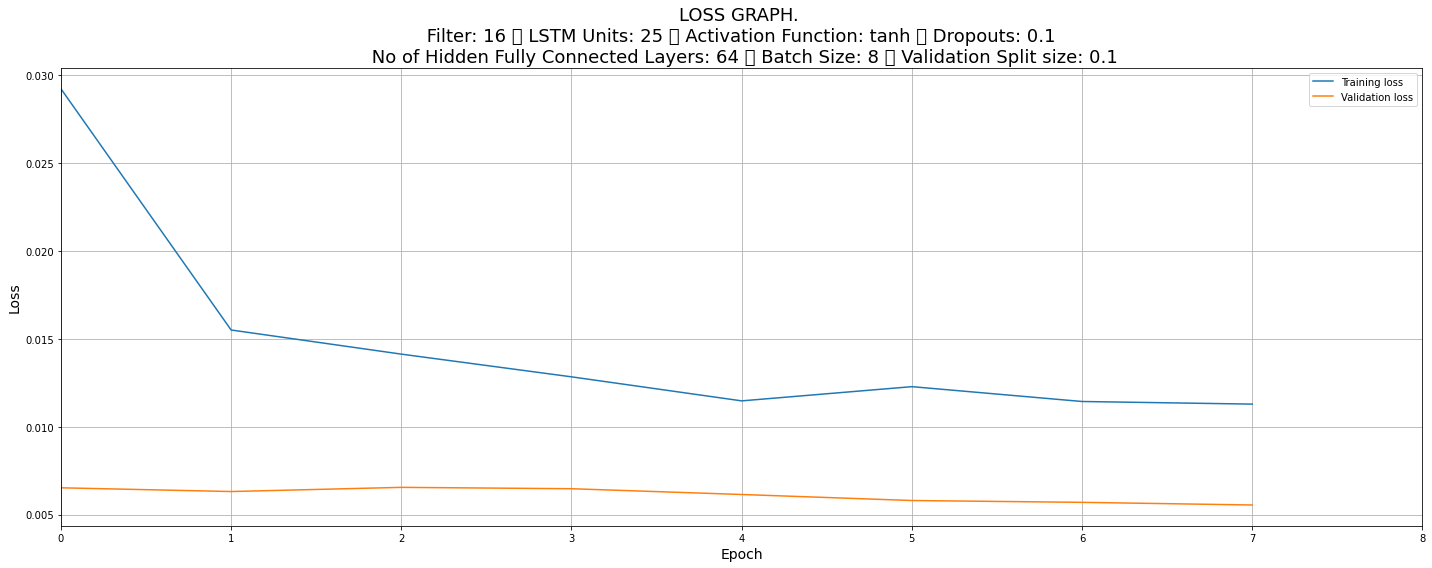

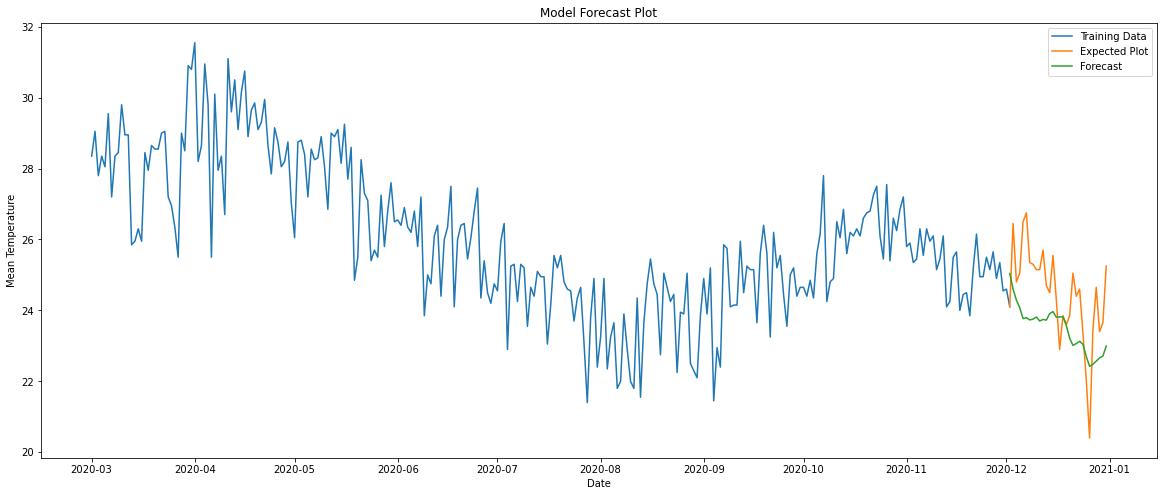









LSTM Model For:16 LSTM Units:25 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_37 (Bidirectio (None, 21, 50)            8400      
_________________________________________________________________
bidirectional_38 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_39 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_37 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_37 (Dense)            

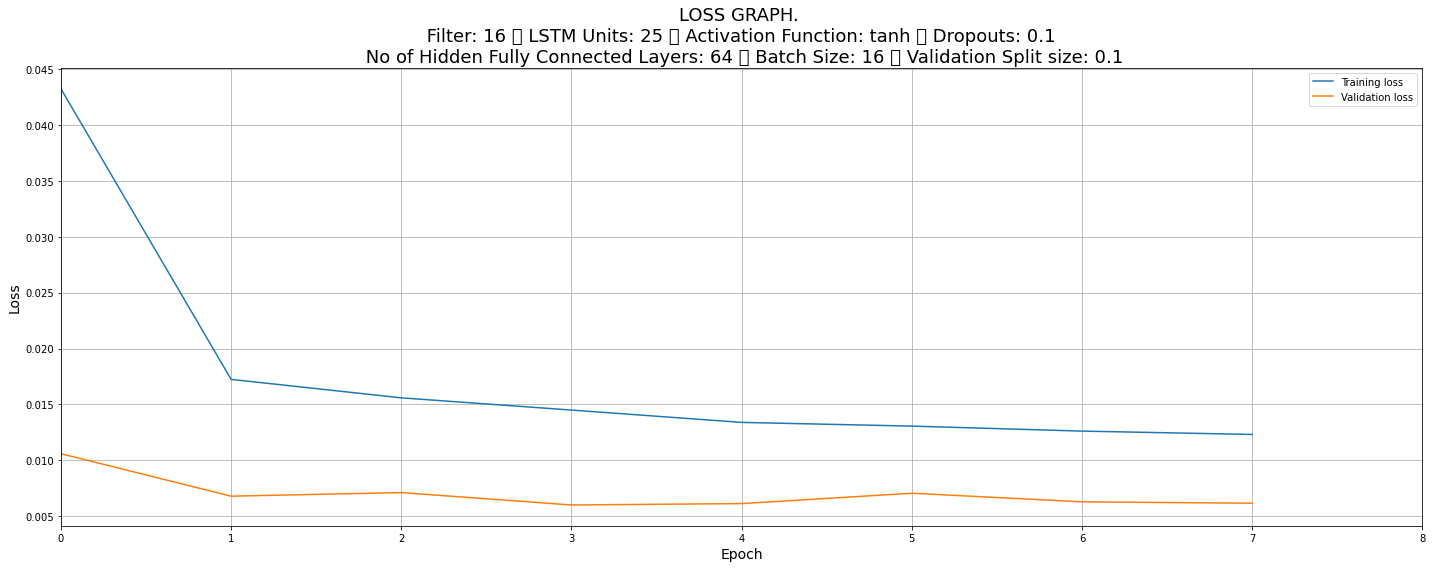

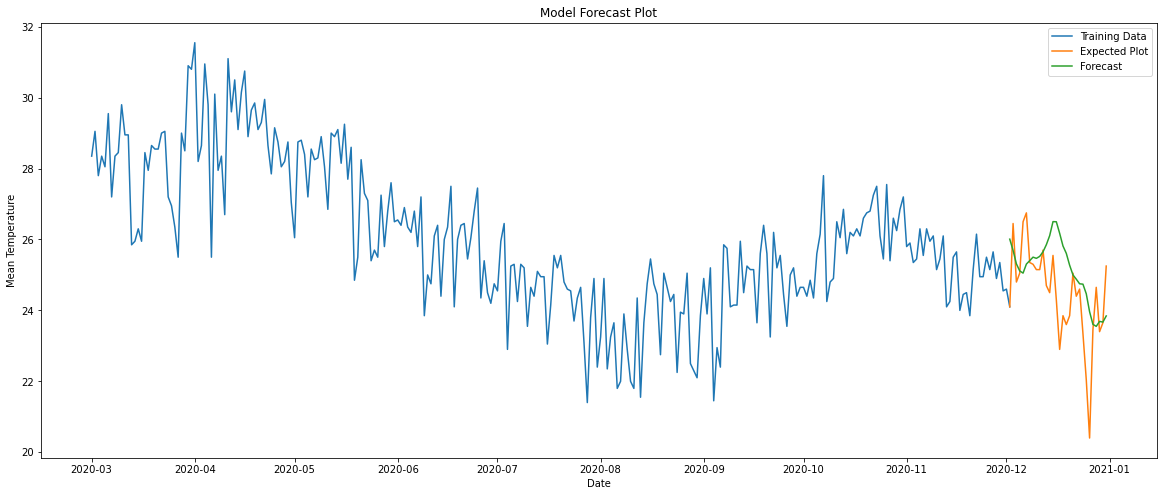









LSTM Model For:16 LSTM Units:50 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_40 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_41 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_42 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_40 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (N

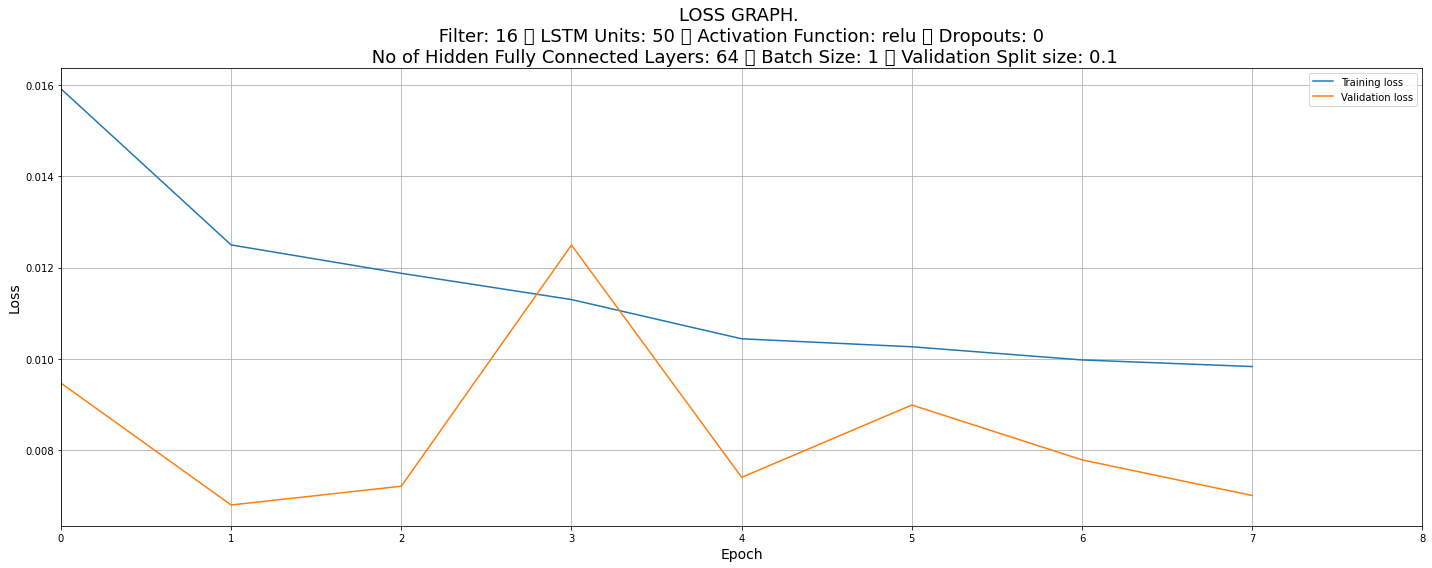

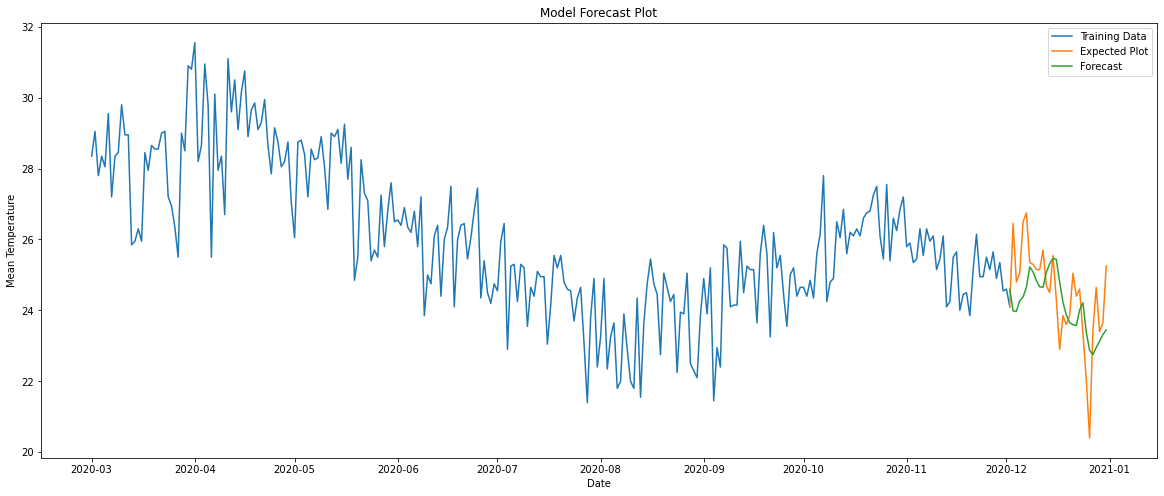









LSTM Model For:16 LSTM Units:50 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_43 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_44 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_45 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_43 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_43 (Dense)             (N

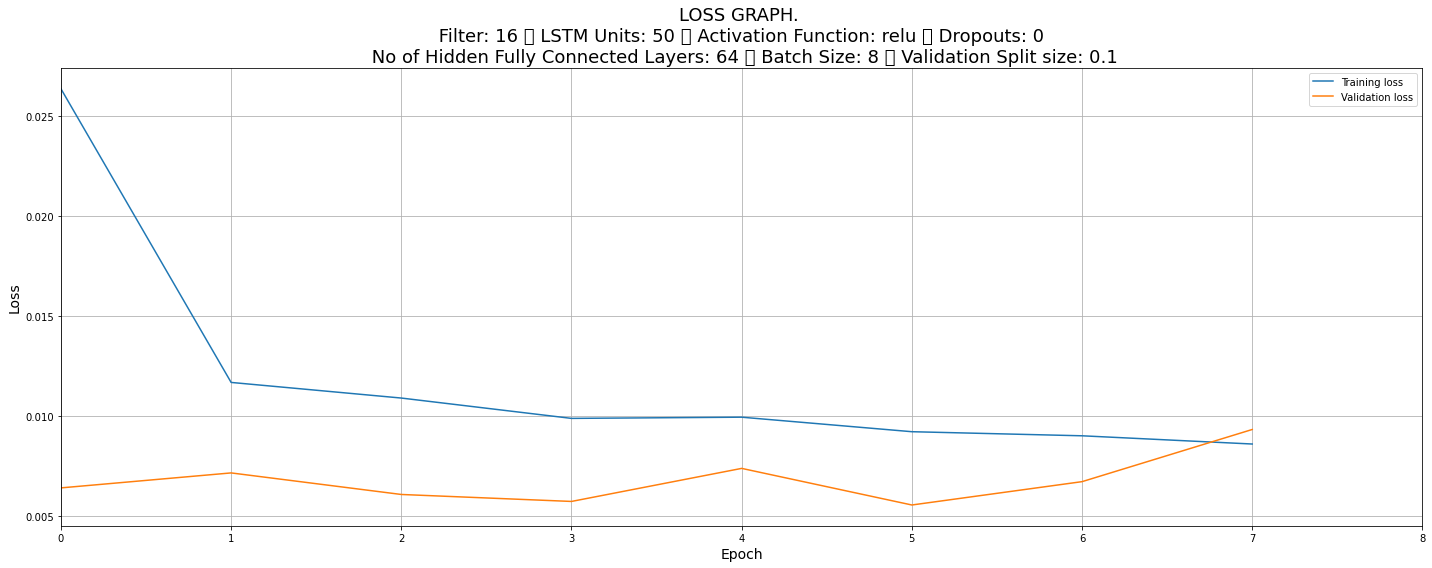

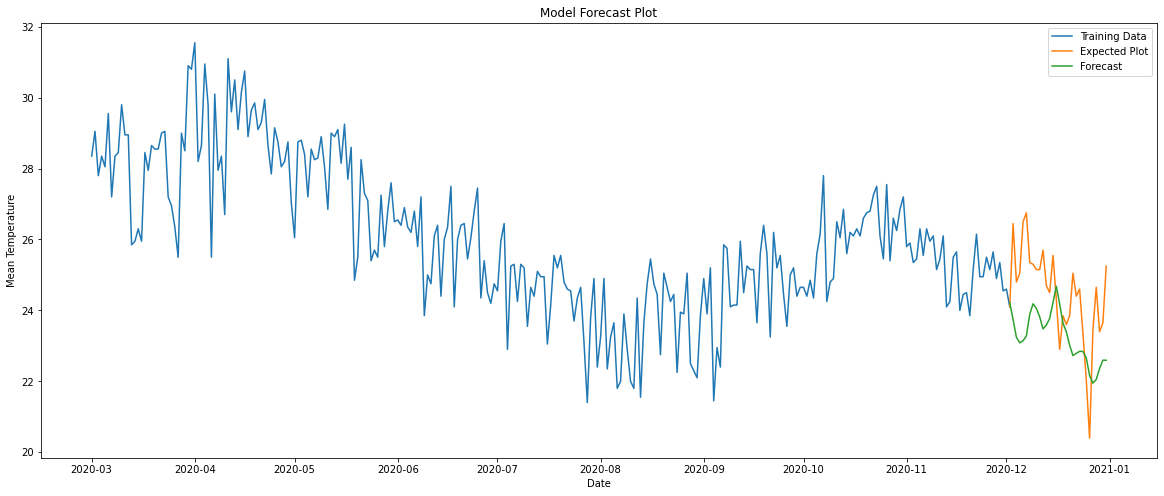









LSTM Model For:16 LSTM Units:50 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_46 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_47 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_48 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_46 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_46 (Dense)             (

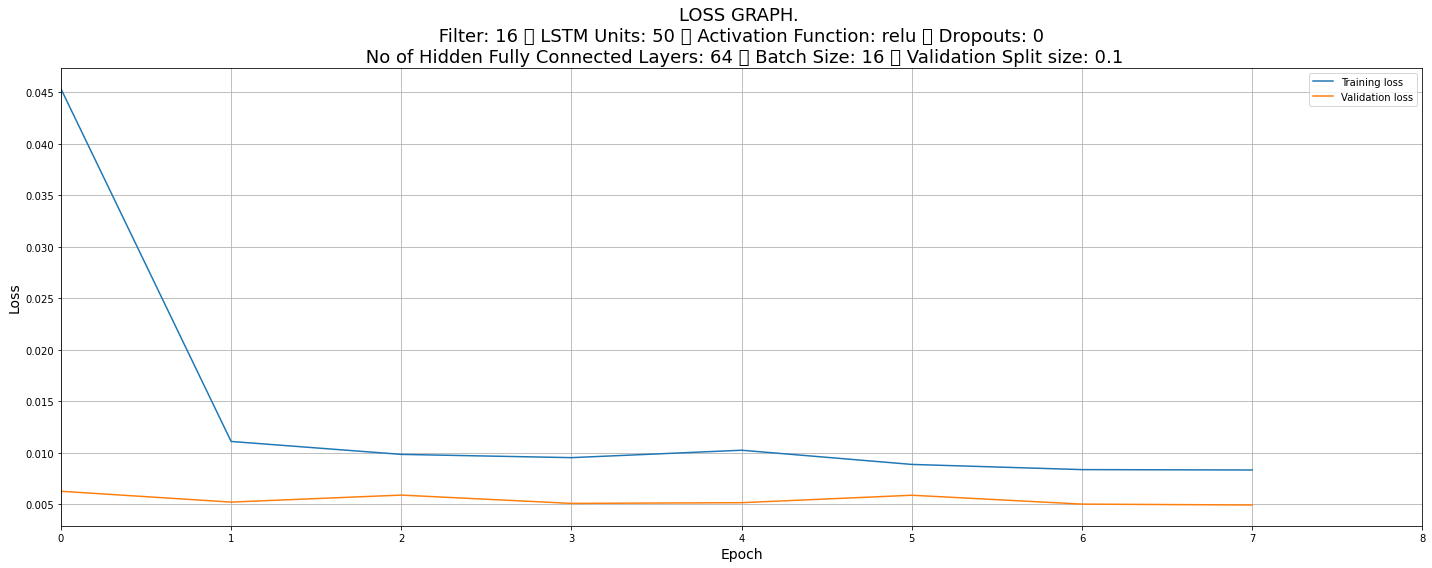

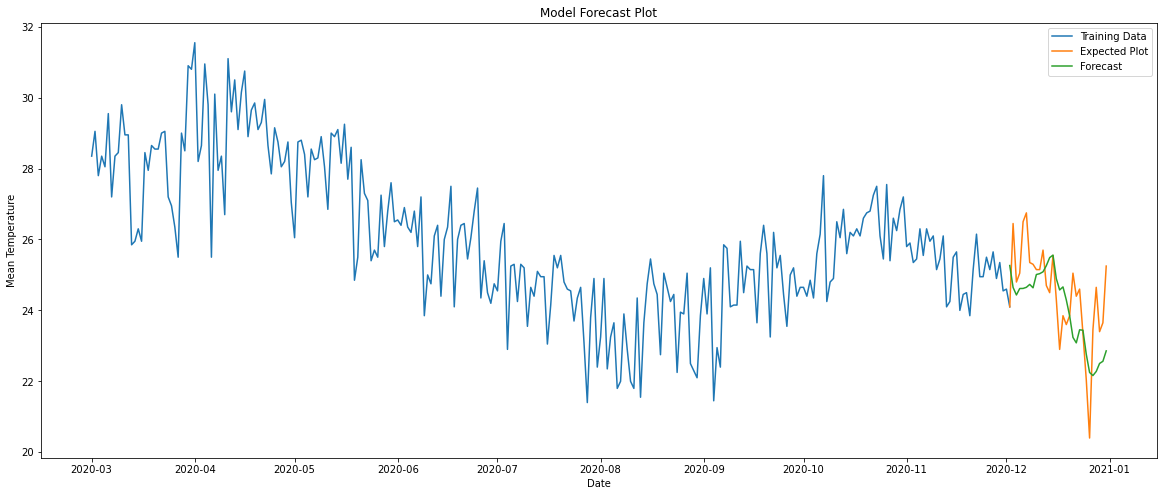









LSTM Model For:16 LSTM Units:50 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_17 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_49 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_50 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_51 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_49 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_49 (Dense)             

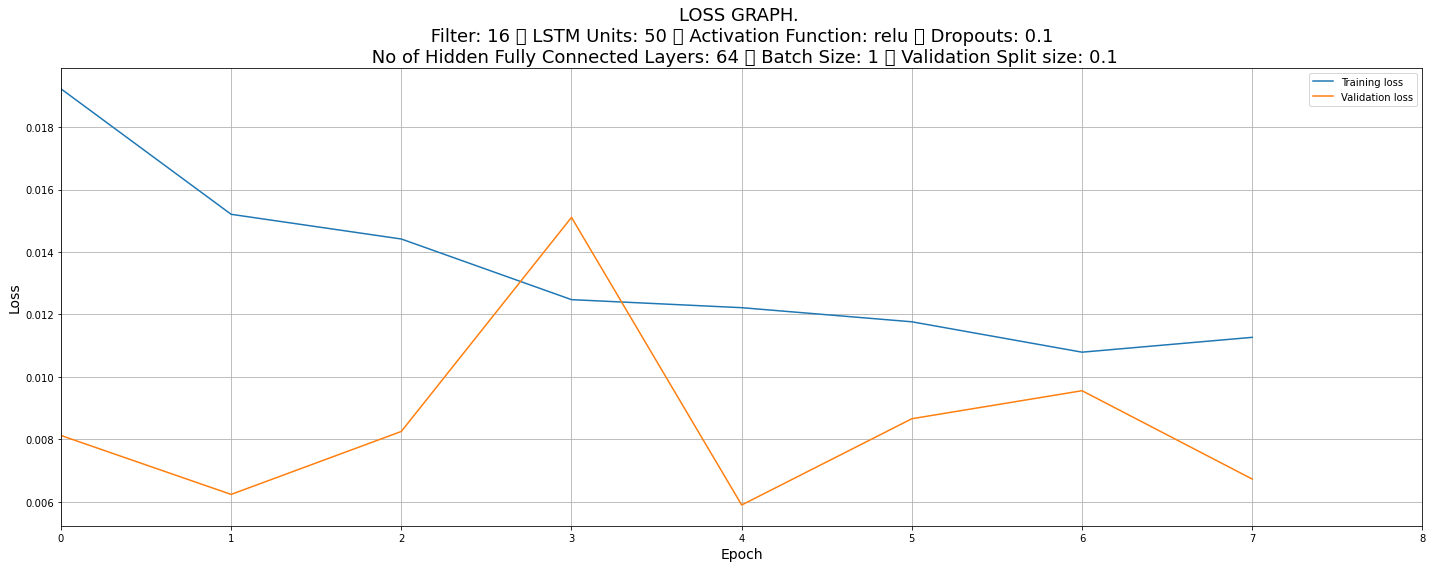

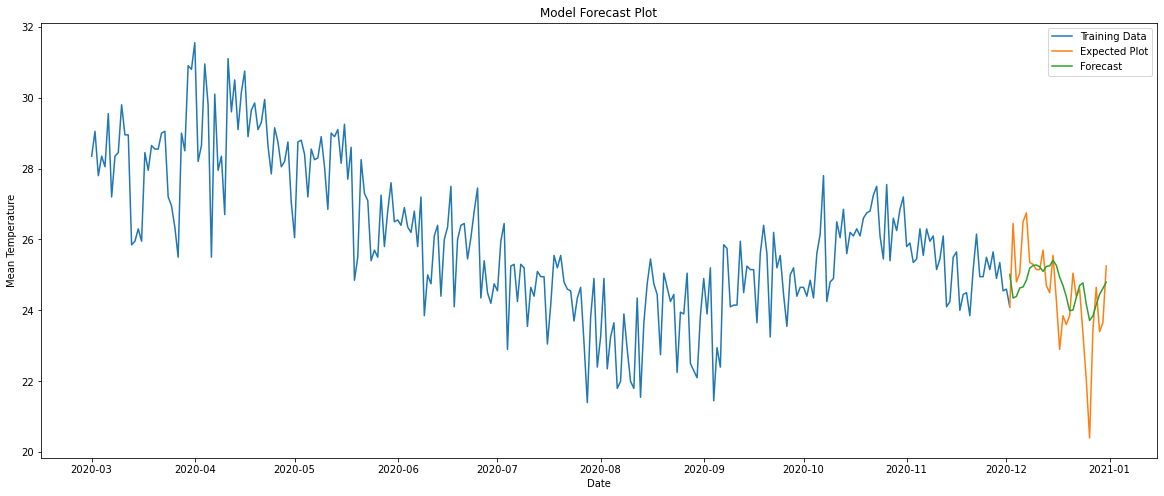









LSTM Model For:16 LSTM Units:50 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_52 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_53 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_54 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_52 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_52 (Dense)             

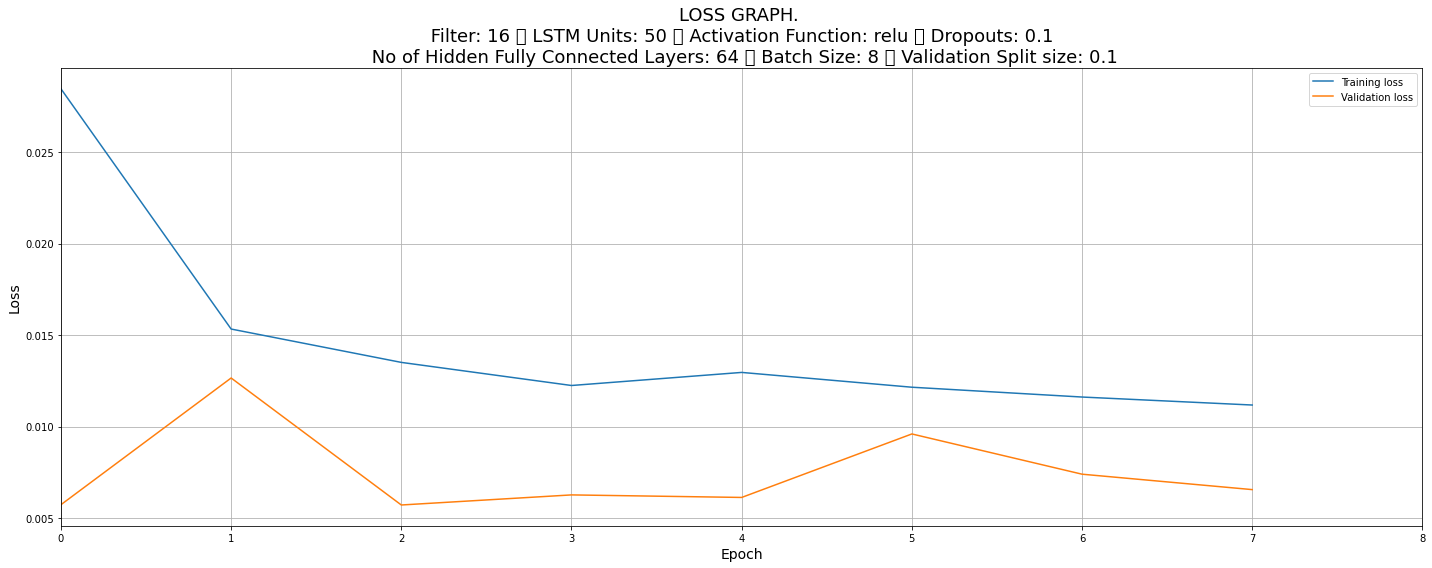

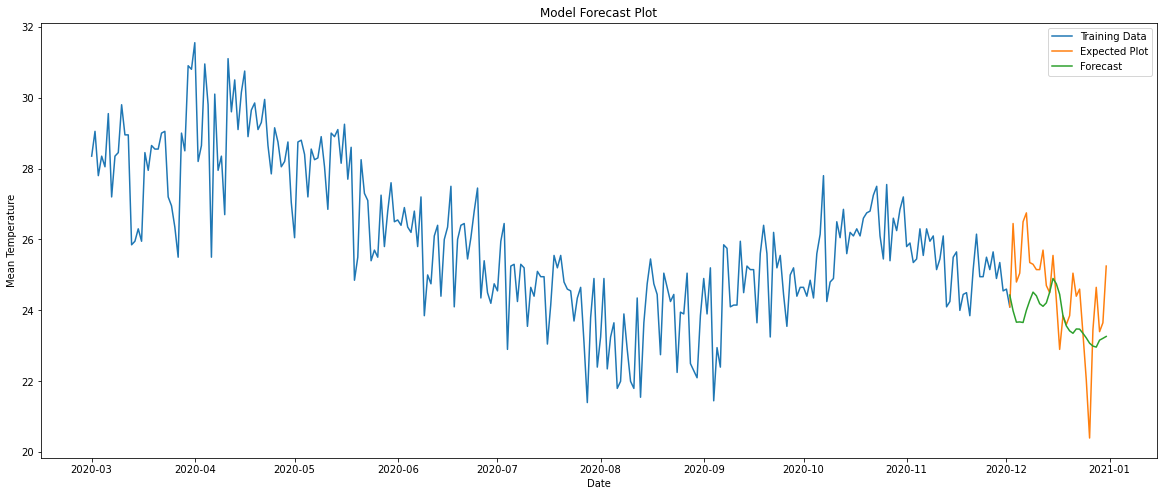









LSTM Model For:16 LSTM Units:50 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_55 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_56 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_57 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_55 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_55 (Dense)            

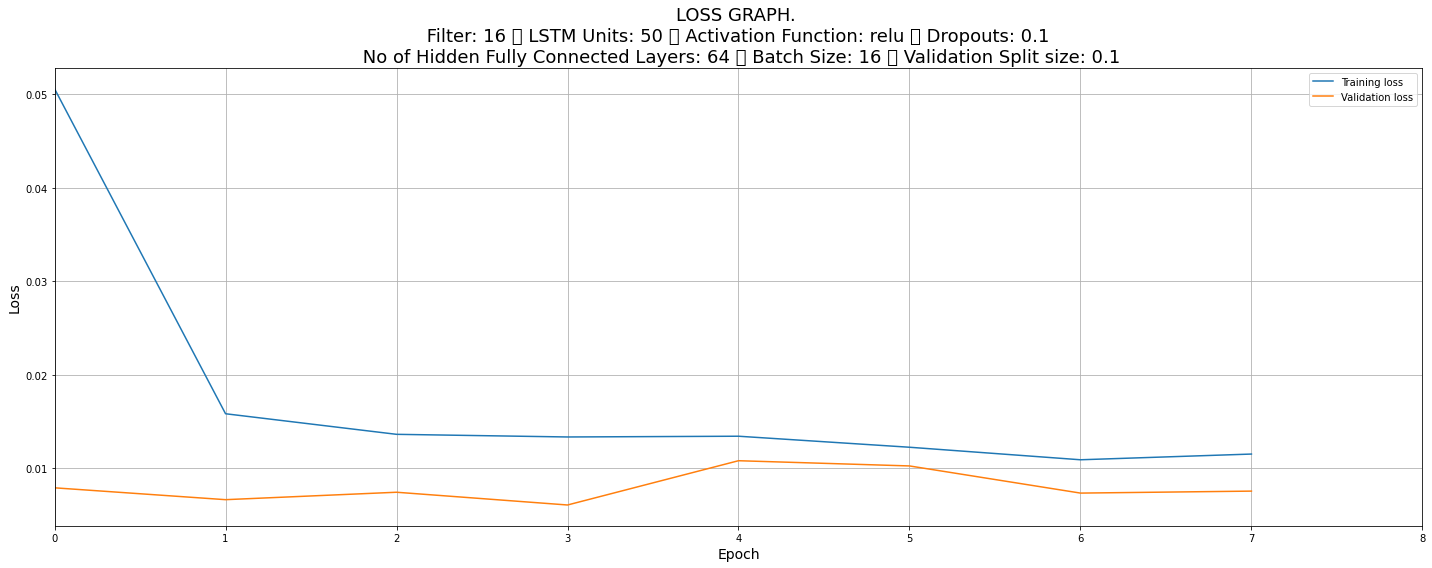

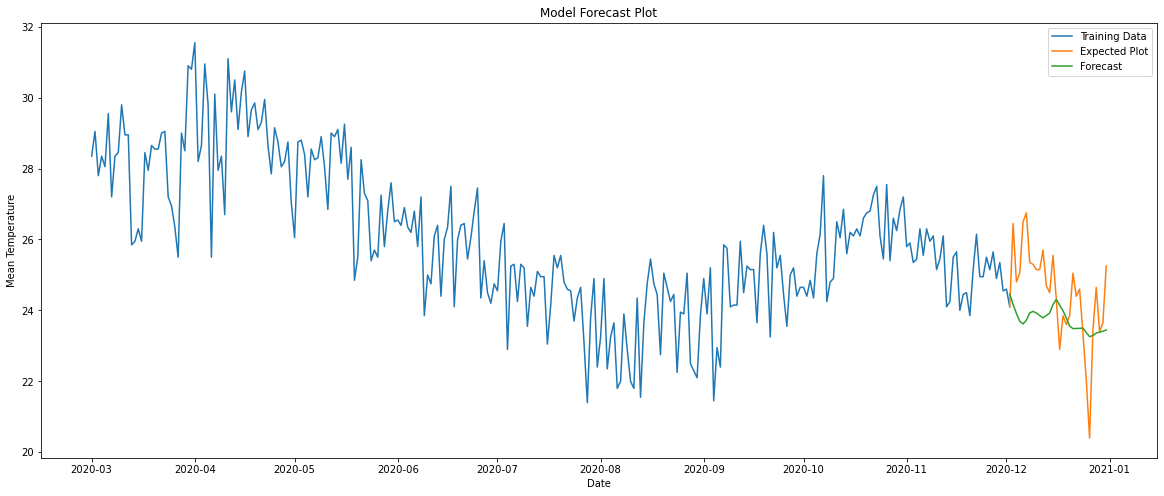









LSTM Model For:16 LSTM Units:50 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_58 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_59 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_60 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_58 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (N

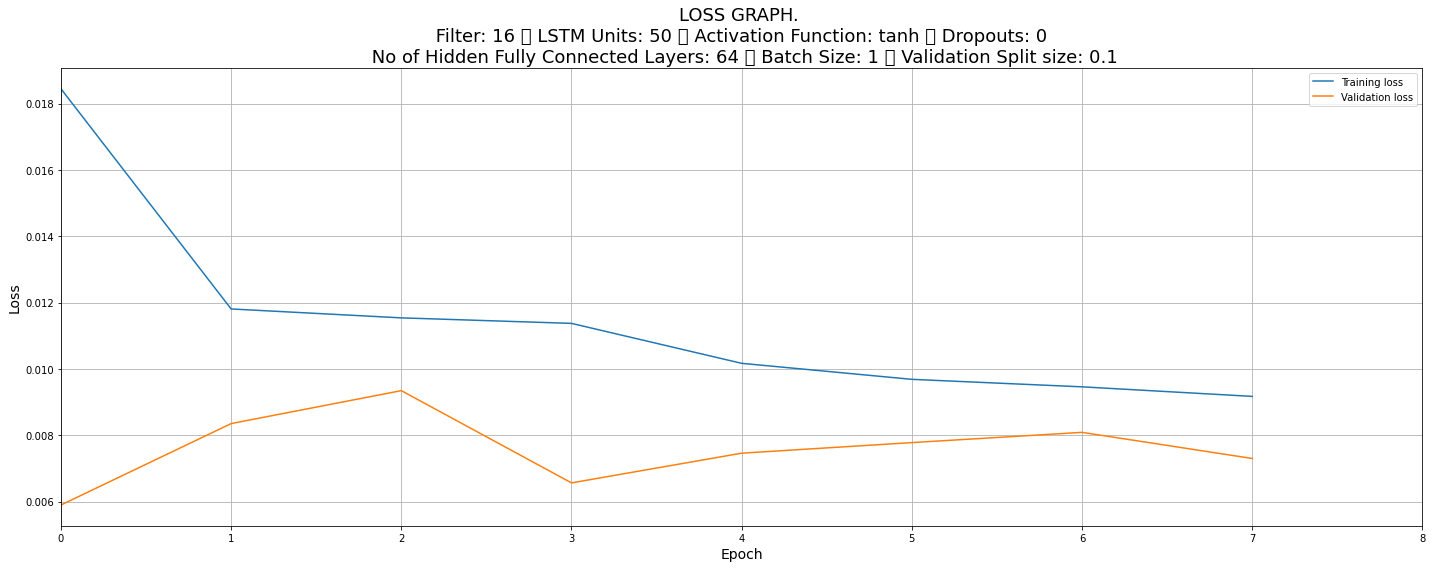

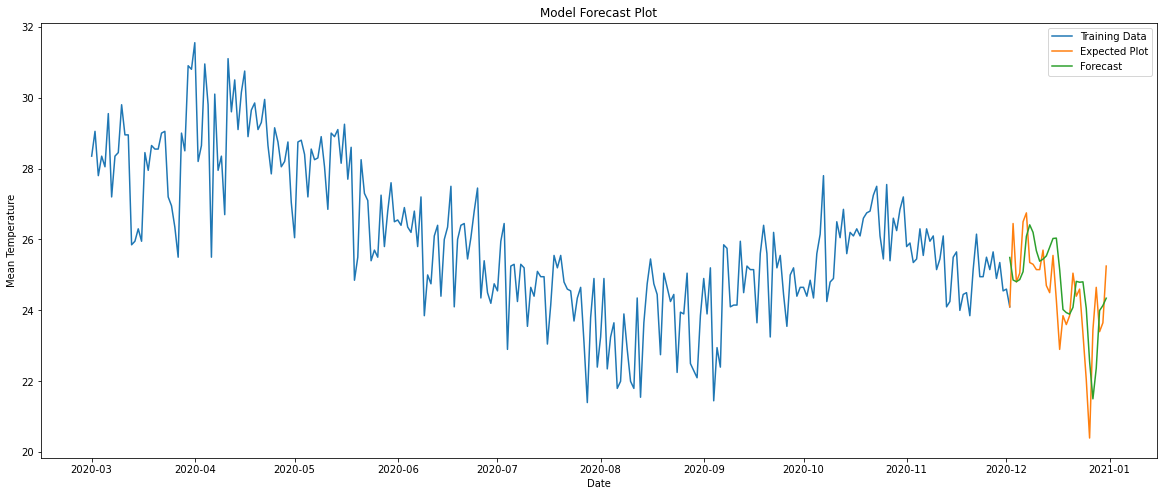









LSTM Model For:16 LSTM Units:50 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_61 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_62 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_63 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_61 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_61 (Dense)             (N

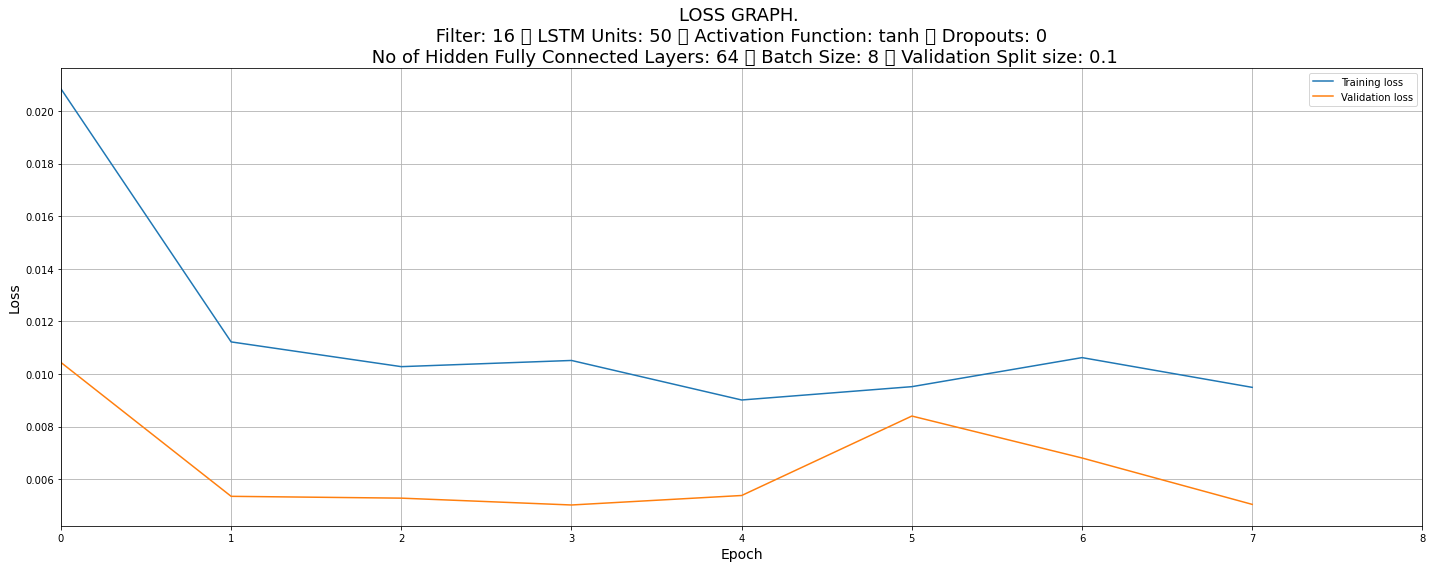

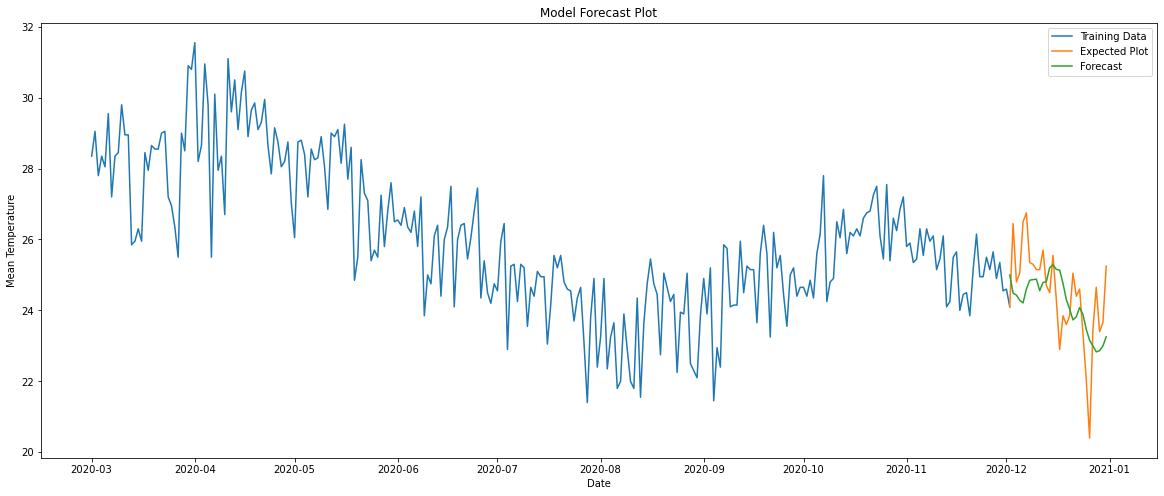









LSTM Model For:16 LSTM Units:50 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_64 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_65 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_66 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_64 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_64 (Dense)             (

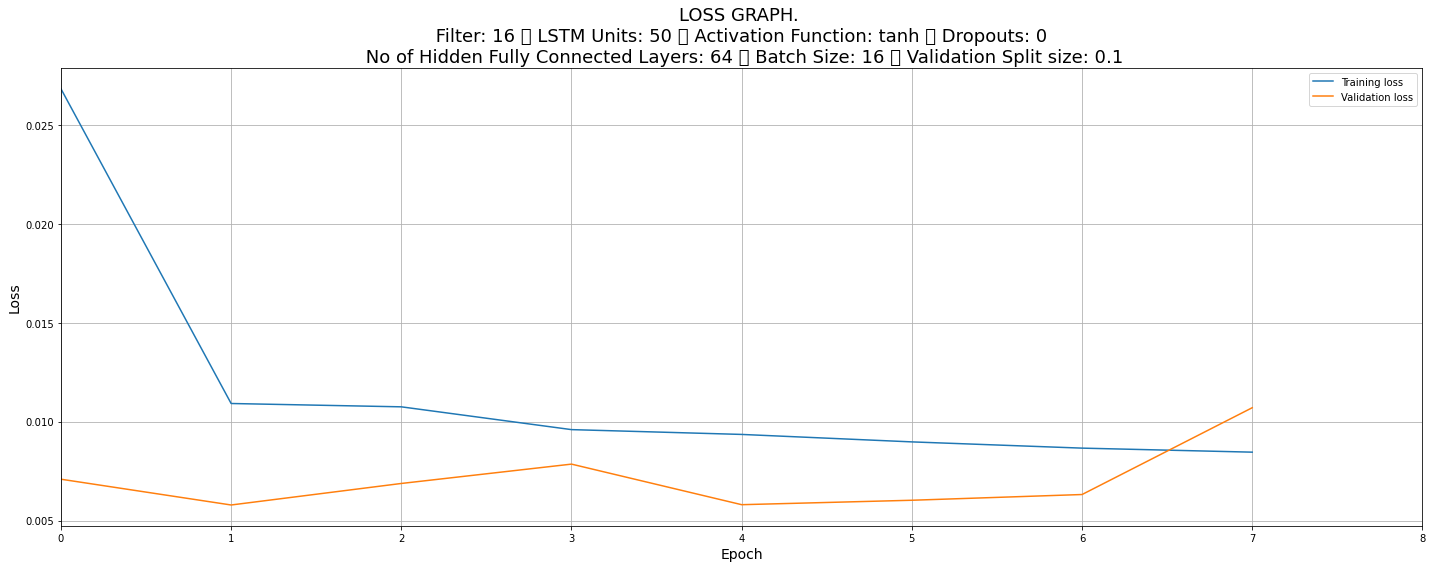

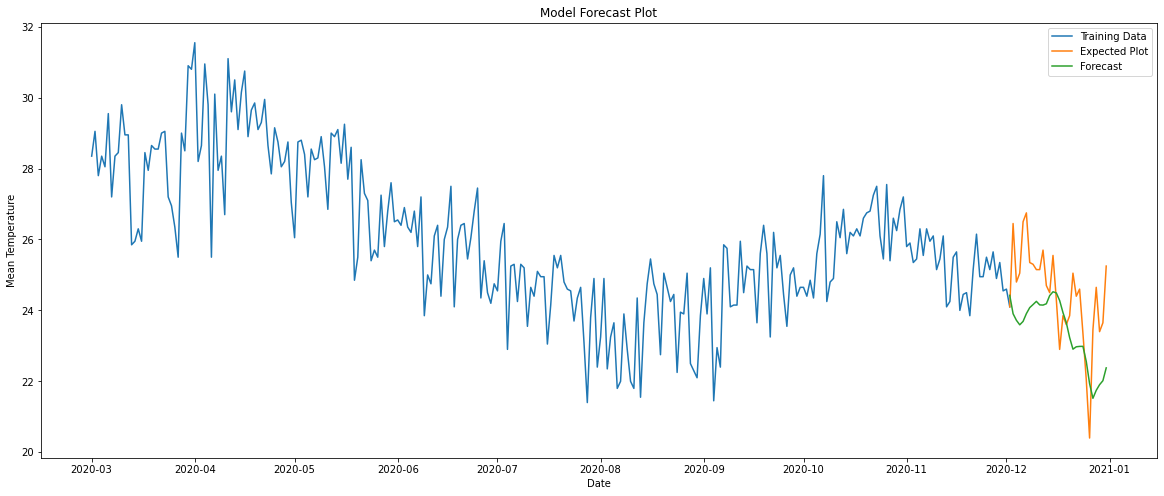









LSTM Model For:16 LSTM Units:50 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_23 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_67 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_68 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_69 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_67 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_67 (Dense)             

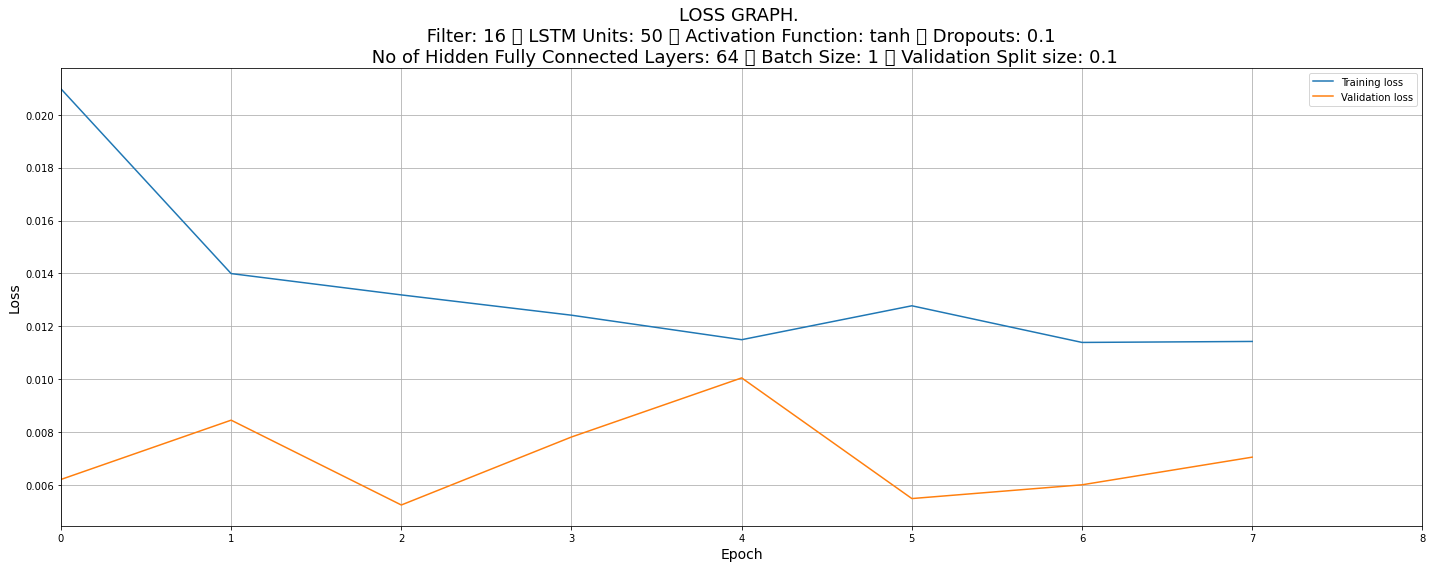

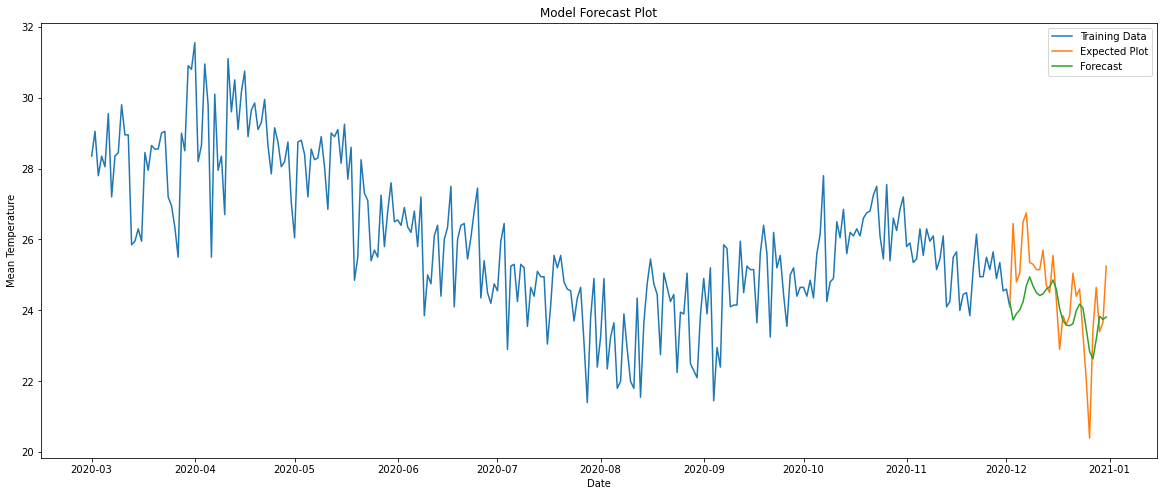









LSTM Model For:16 LSTM Units:50 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_70 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_71 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_72 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_70 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_70 (Dense)             

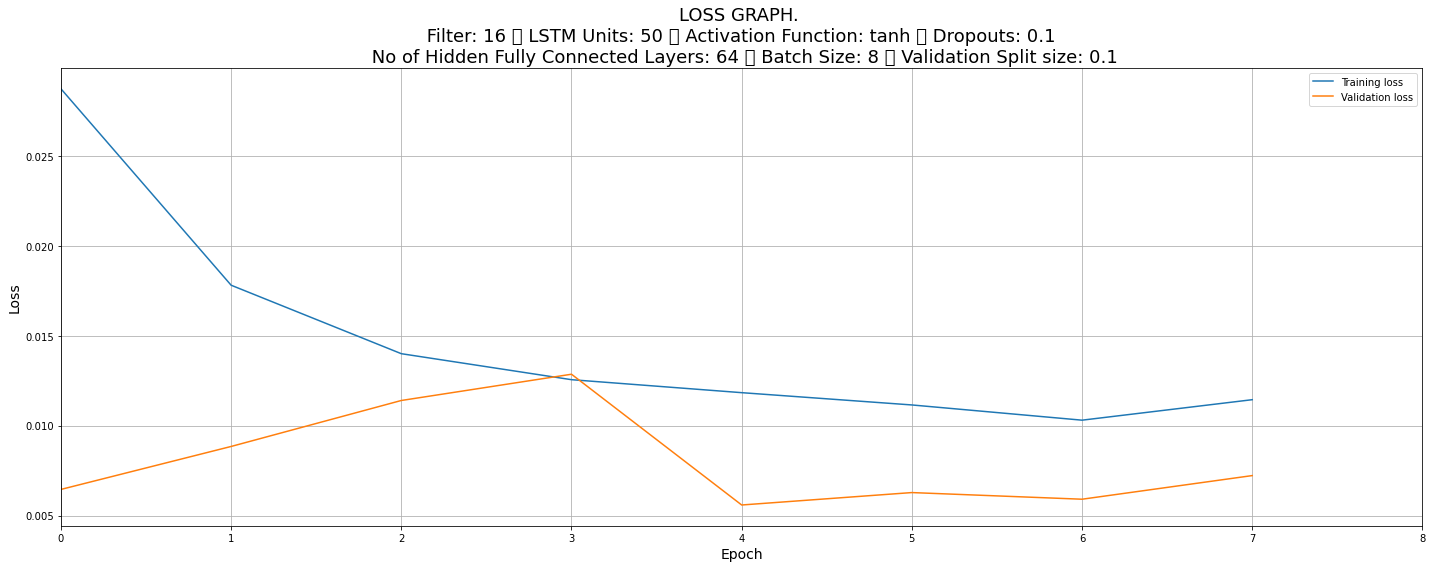

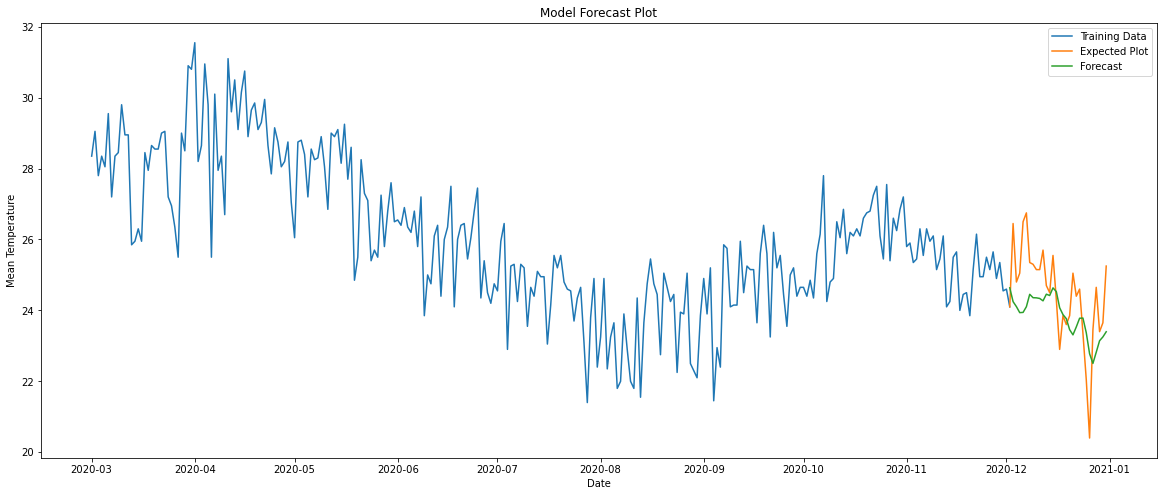









LSTM Model For:16 LSTM Units:50 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_73 (Bidirectio (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_74 (Bidirectio (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_75 (Bidirectio (None, 100)               60400     
_________________________________________________________________
dropout_73 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_73 (Dense)            

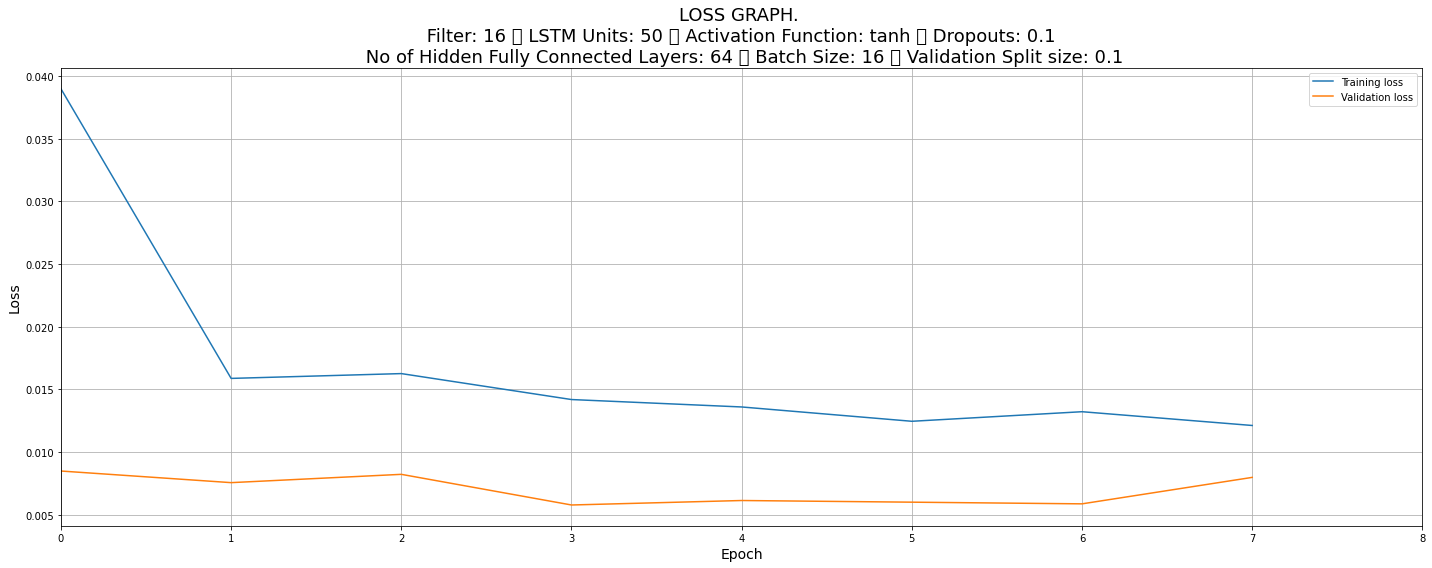

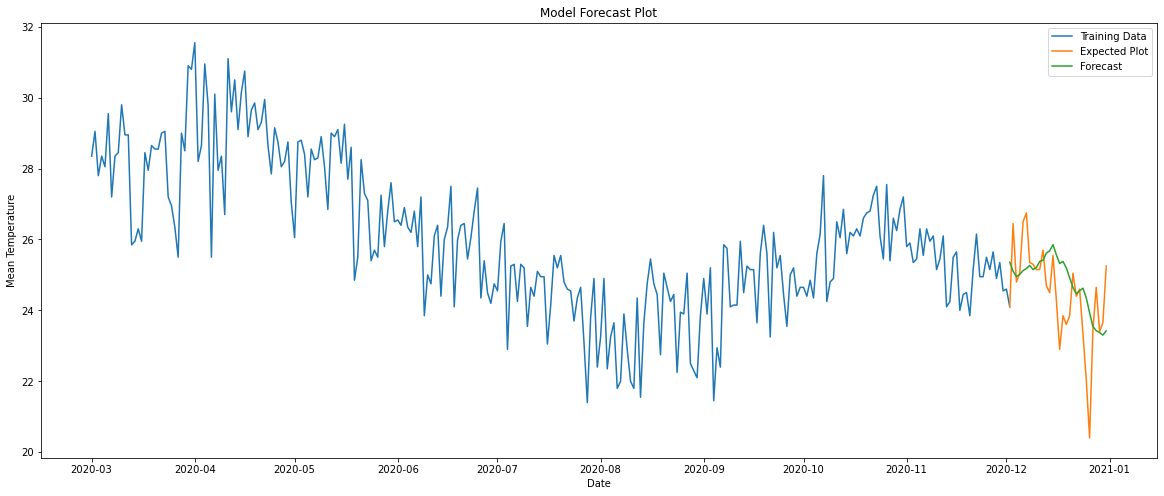









LSTM Model For:32 LSTM Units:25 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_26 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_76 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_77 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_78 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_76 (Dense)             (N

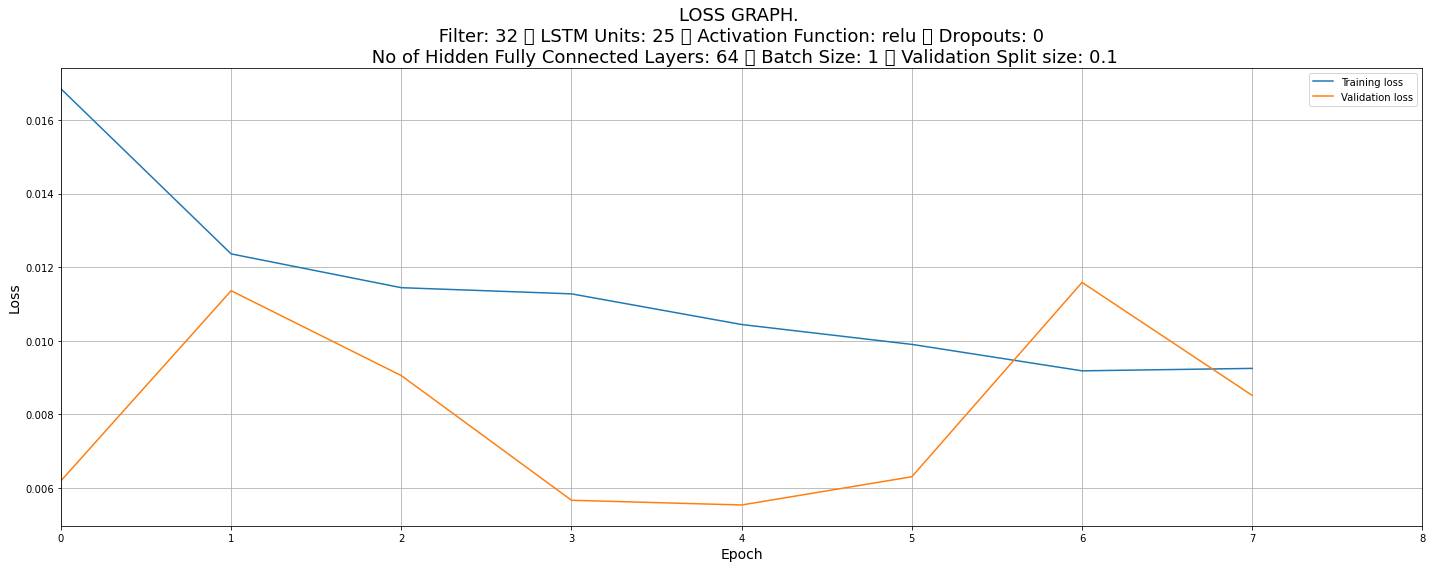

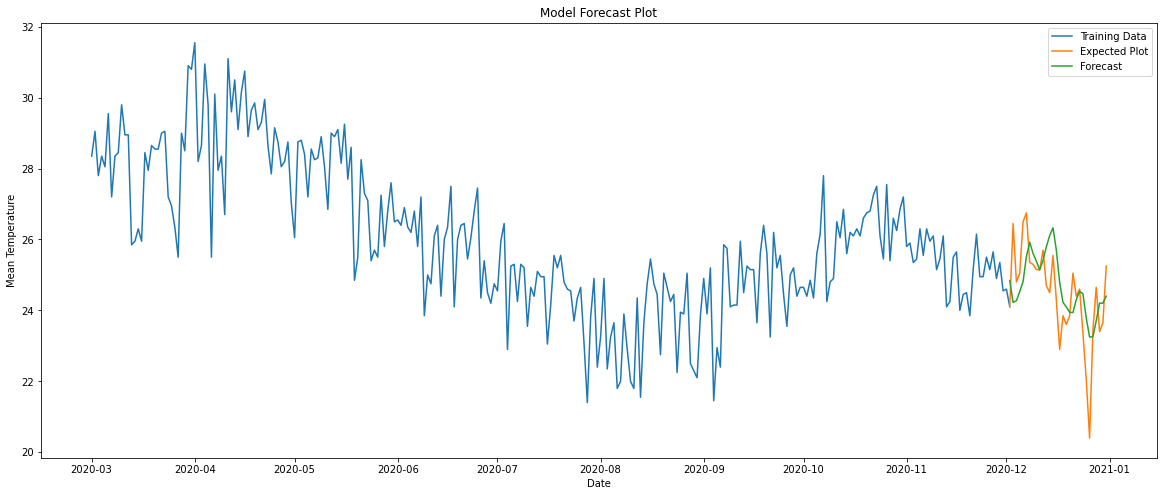









LSTM Model For:32 LSTM Units:25 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_79 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_80 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_81 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_79 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_79 (Dense)             (N

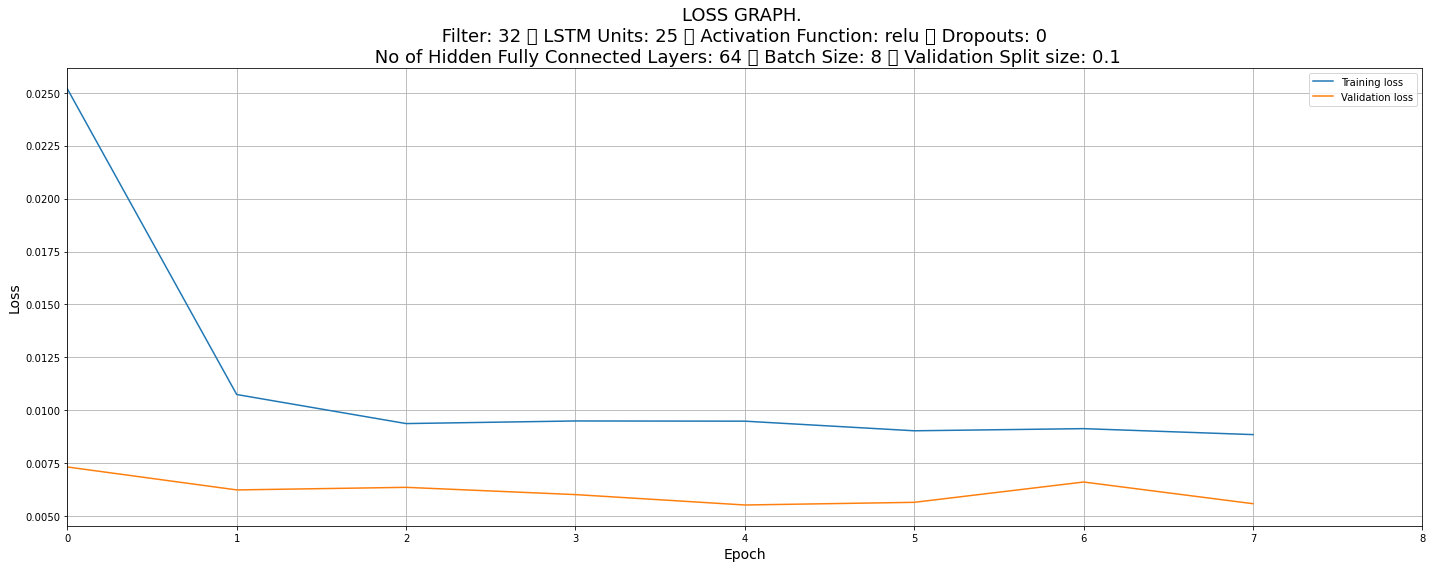

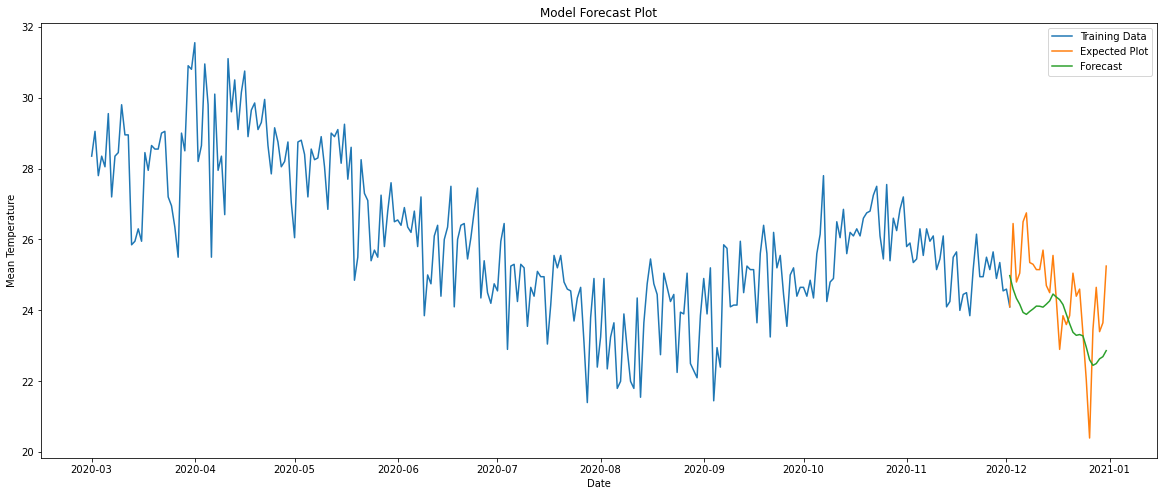









LSTM Model For:32 LSTM Units:25 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_82 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_83 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_84 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_82 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_82 (Dense)             (

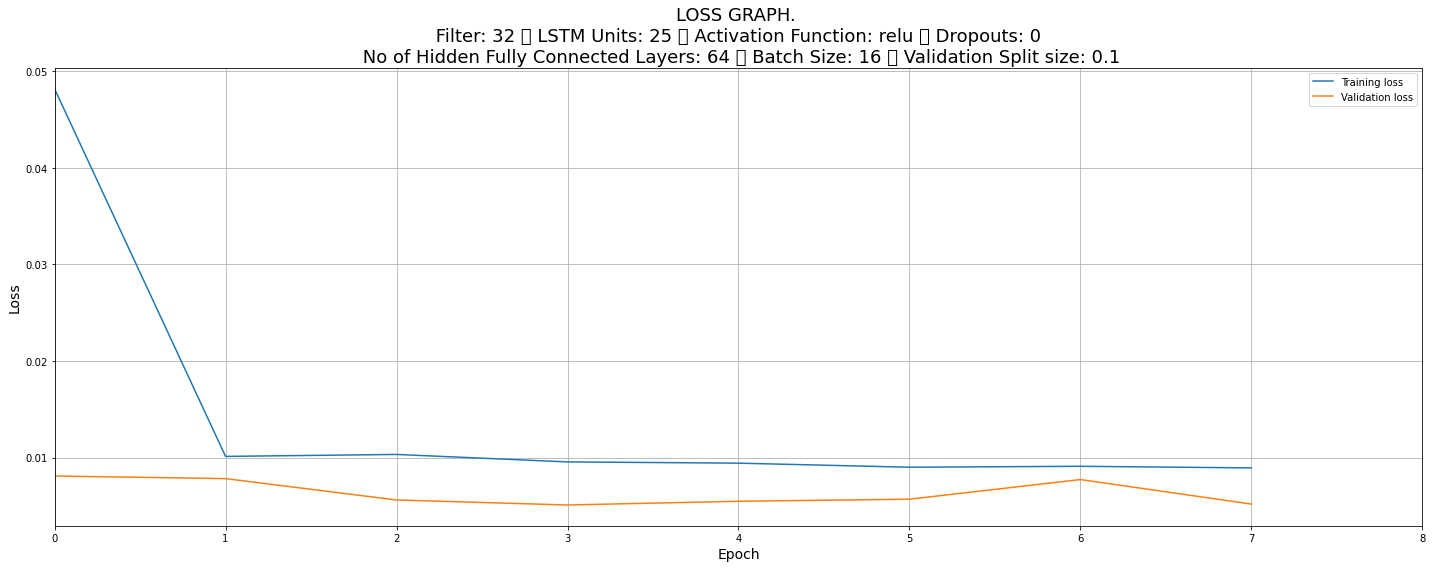

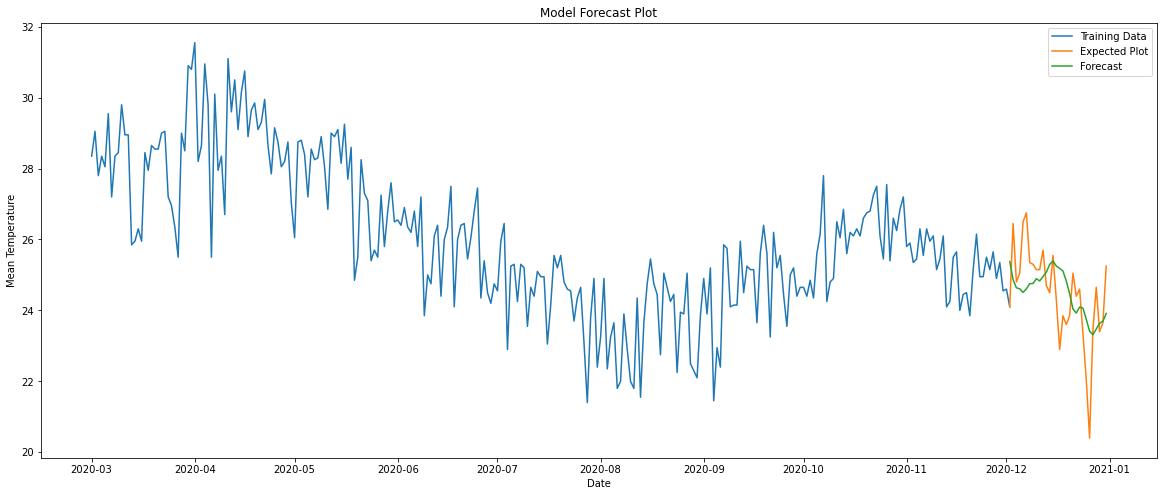









LSTM Model For:32 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_29 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_85 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_86 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_87 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_85 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_85 (Dense)             

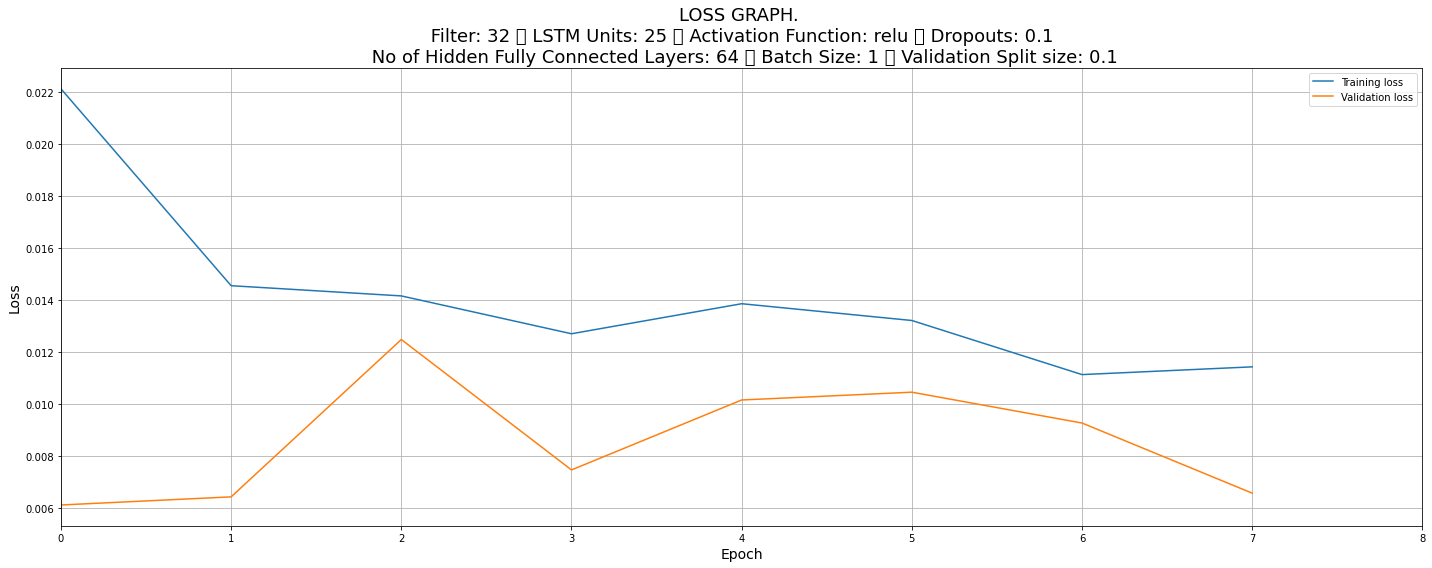

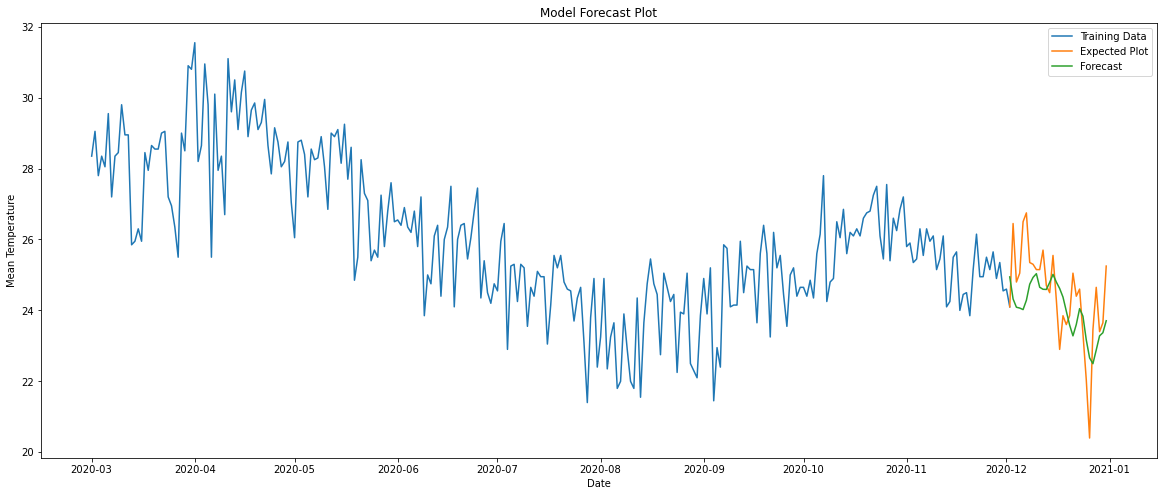









LSTM Model For:32 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_88 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_89 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_90 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_88 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_88 (Dense)             

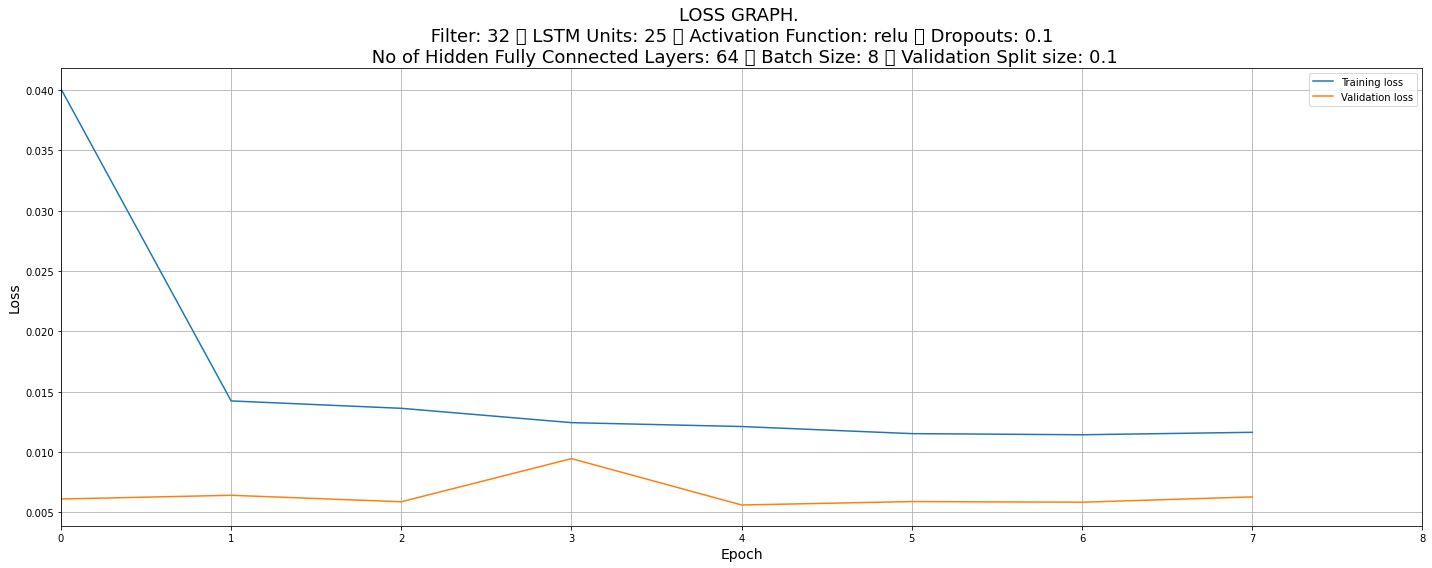

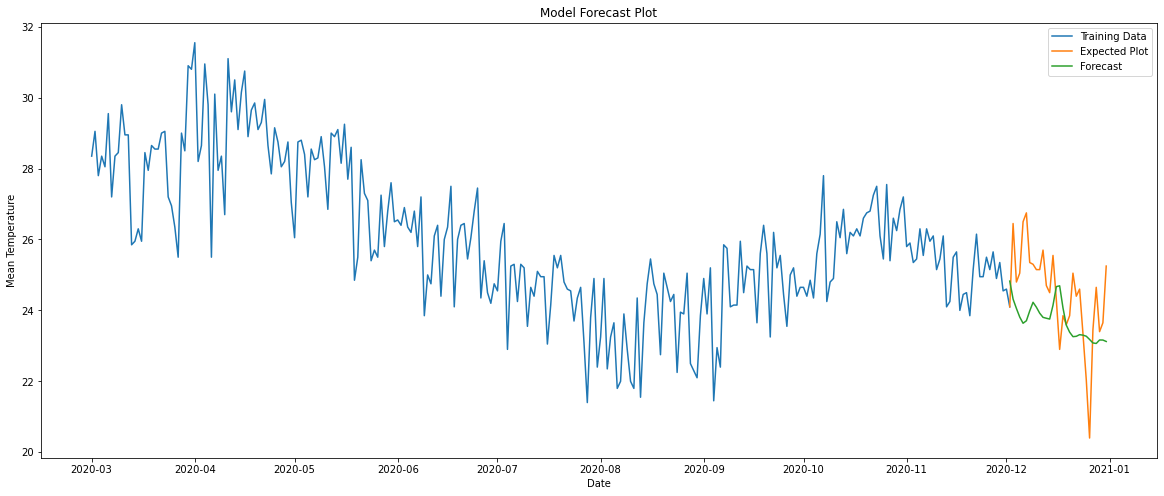









LSTM Model For:32 LSTM Units:25 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_91 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_92 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_93 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_91 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_91 (Dense)            

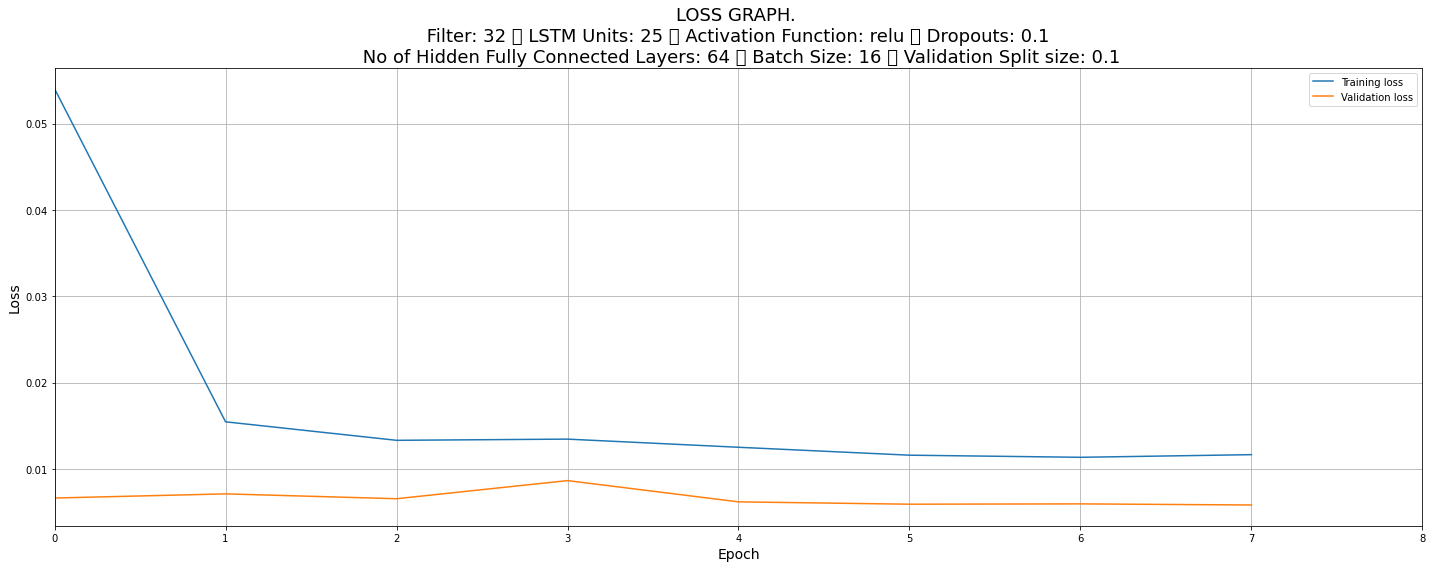

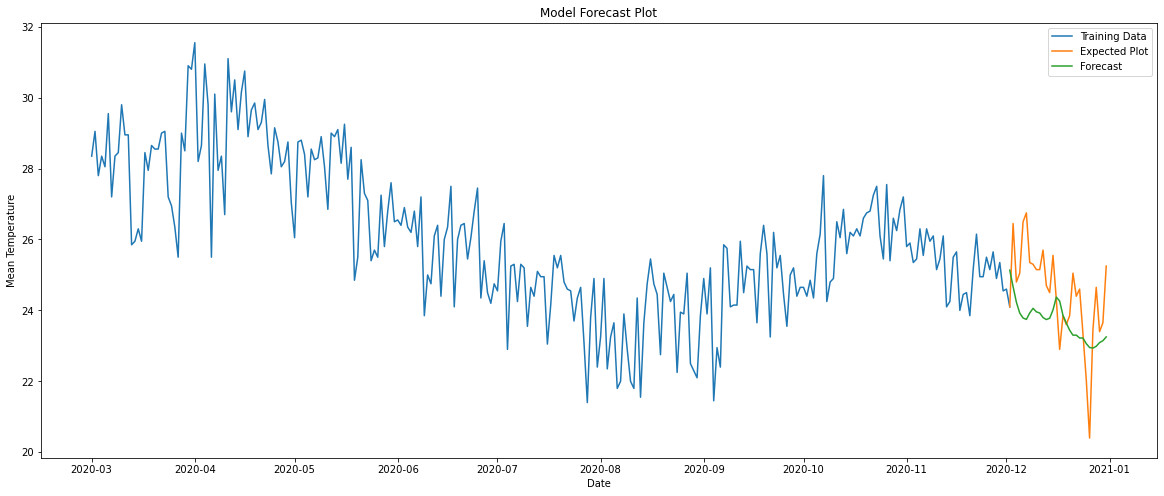









LSTM Model For:32 LSTM Units:25 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_94 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_95 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_96 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_94 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_94 (Dense)             (N

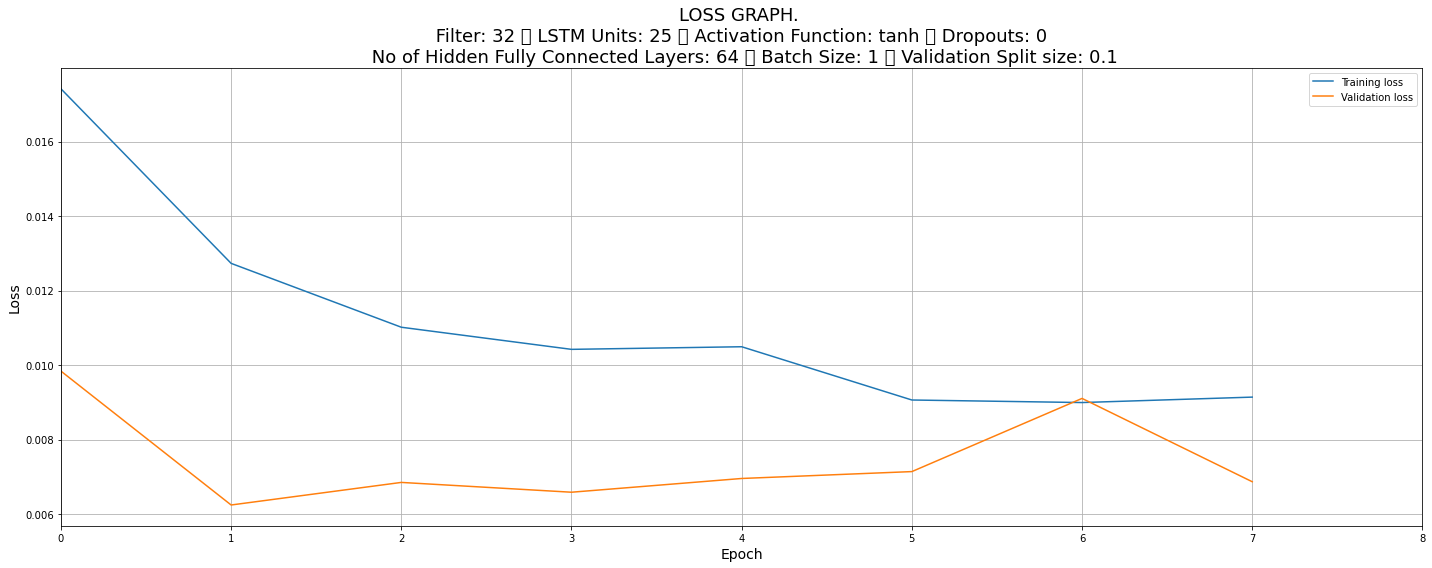

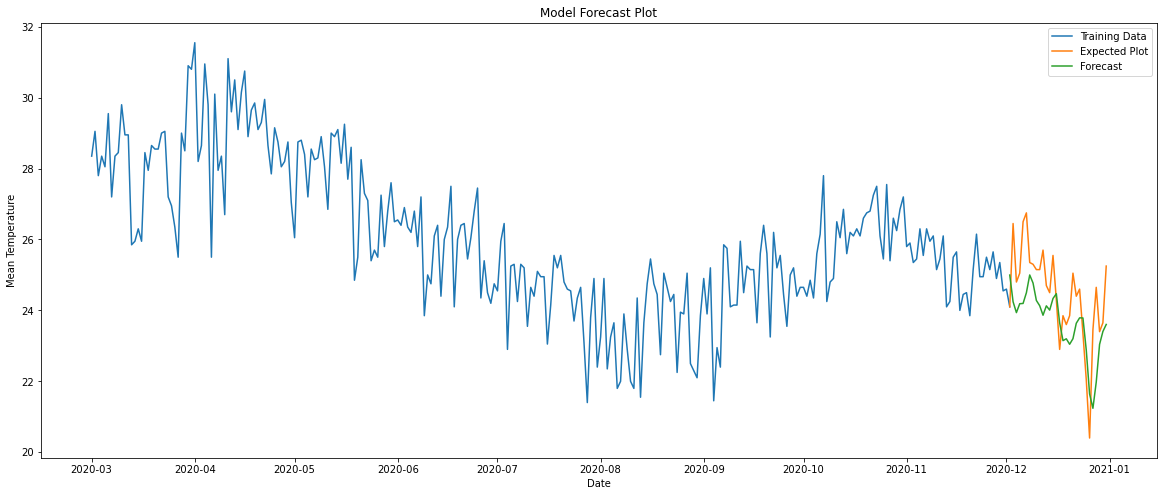









LSTM Model For:32 LSTM Units:25 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_97 (Bidirectio (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_98 (Bidirectio (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_99 (Bidirectio (None, 50)                15200     
_________________________________________________________________
dropout_97 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_97 (Dense)             (N

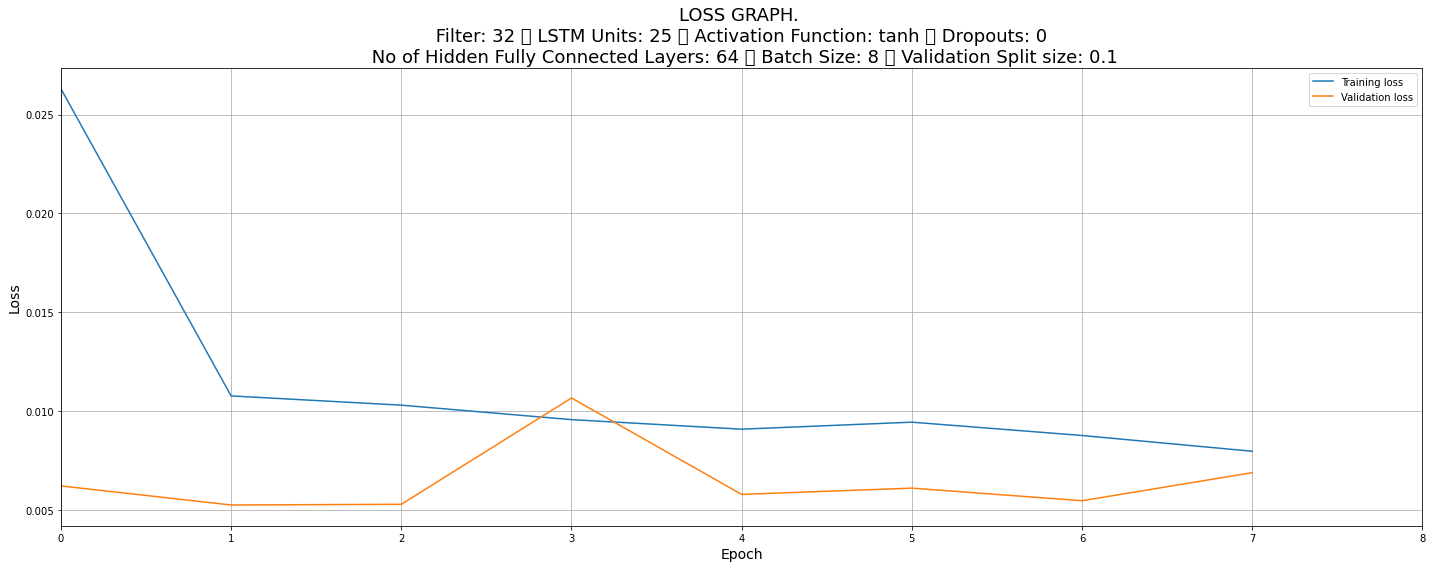

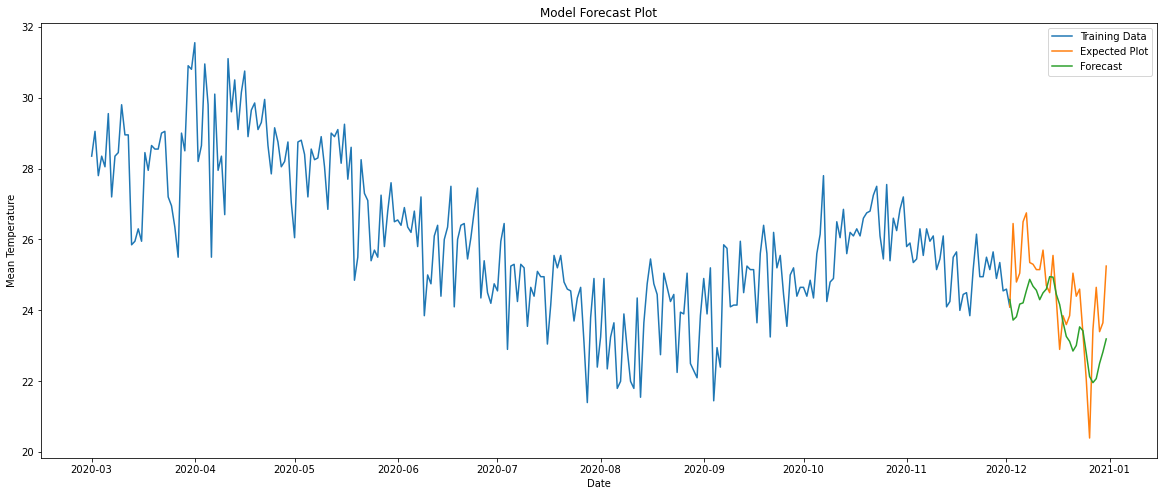









LSTM Model For:32 LSTM Units:25 Activation Function:tanh Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_100 (Bidirecti (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_101 (Bidirecti (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_102 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dropout_100 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_100 (Dense)            (

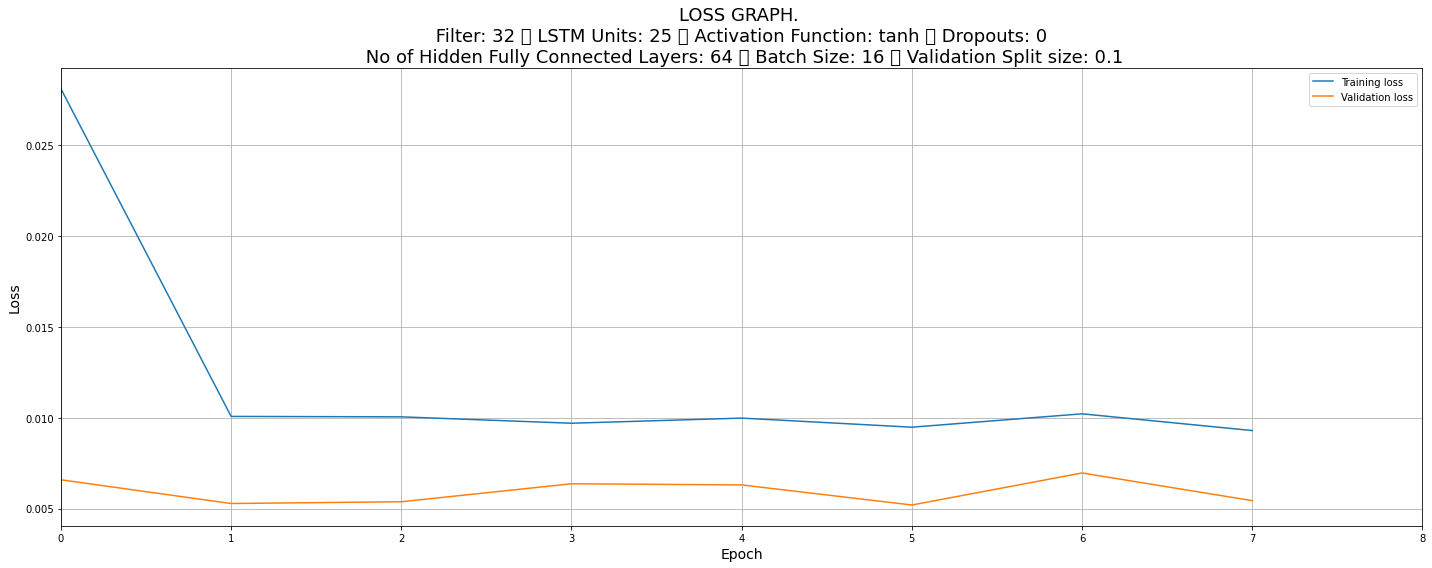

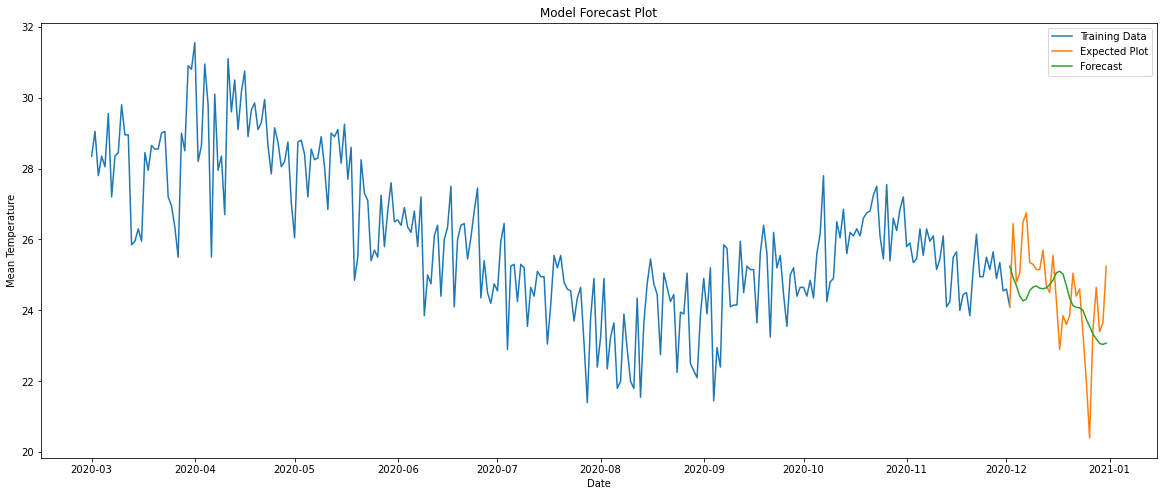









LSTM Model For:32 LSTM Units:25 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_103 (Bidirecti (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_104 (Bidirecti (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_105 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dropout_103 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_103 (Dense)            

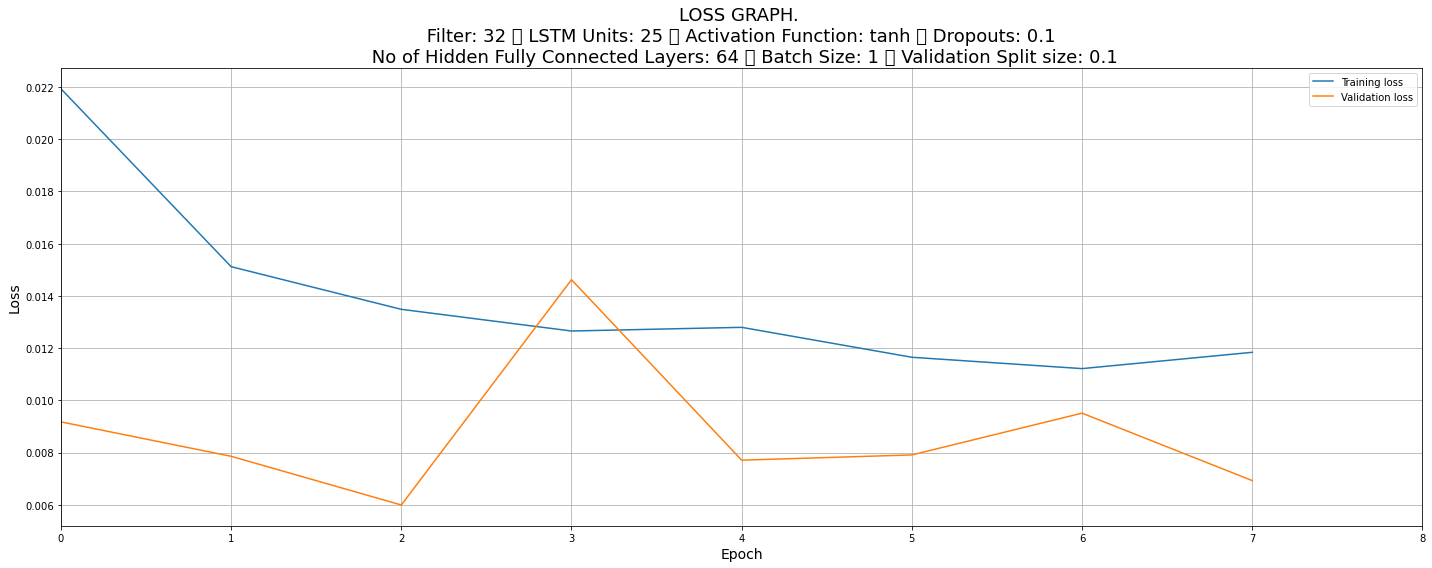

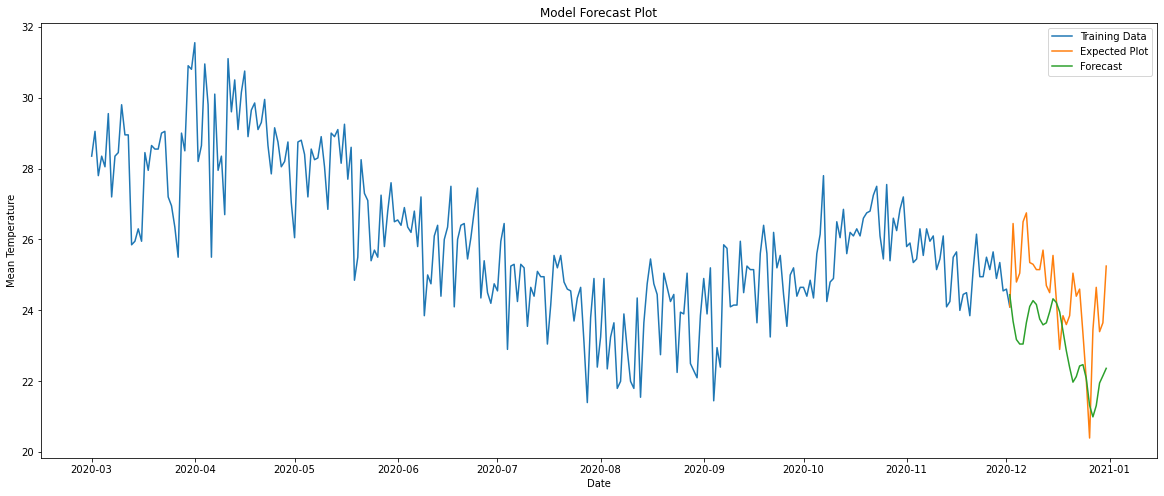









LSTM Model For:32 LSTM Units:25 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_106 (Bidirecti (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_107 (Bidirecti (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_108 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dropout_106 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_106 (Dense)            

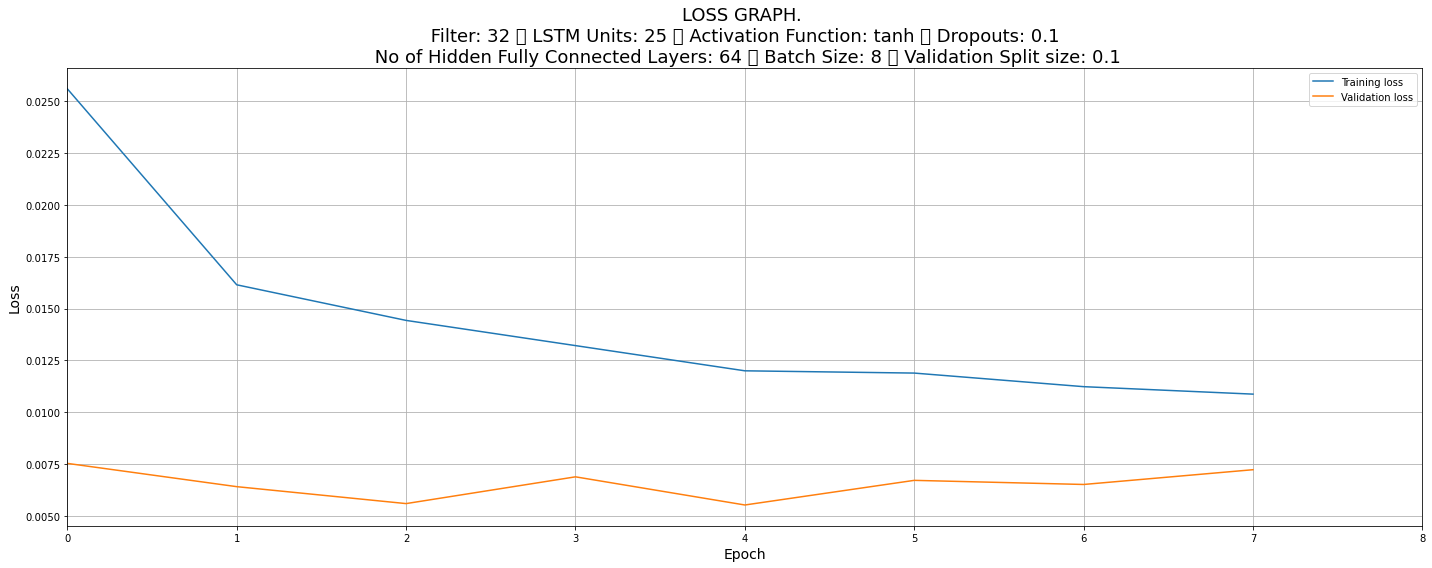

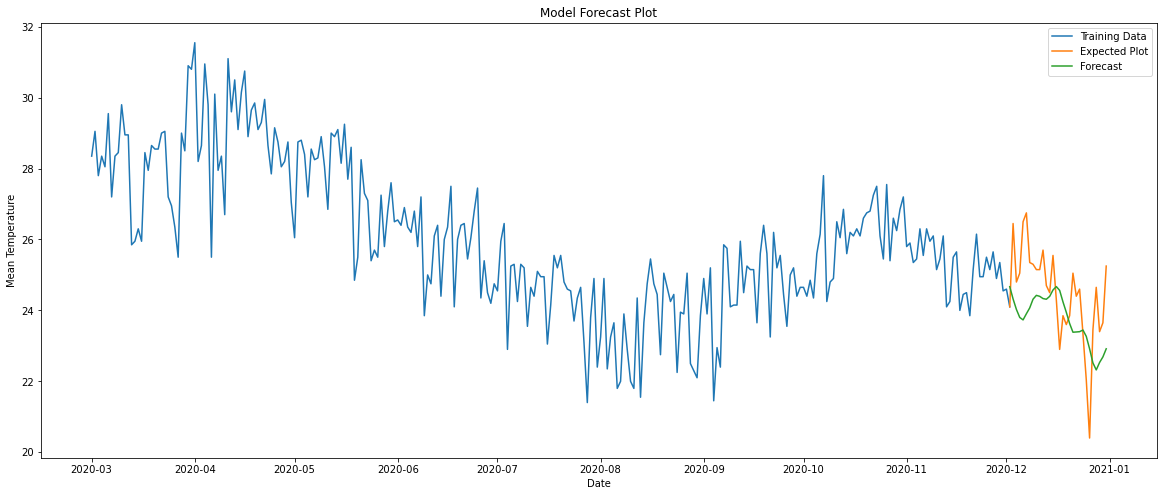









LSTM Model For:32 LSTM Units:25 Activation Function:tanh Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_109 (Bidirecti (None, 21, 50)            11600     
_________________________________________________________________
bidirectional_110 (Bidirecti (None, 21, 50)            15200     
_________________________________________________________________
bidirectional_111 (Bidirecti (None, 50)                15200     
_________________________________________________________________
dropout_109 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_109 (Dense)           

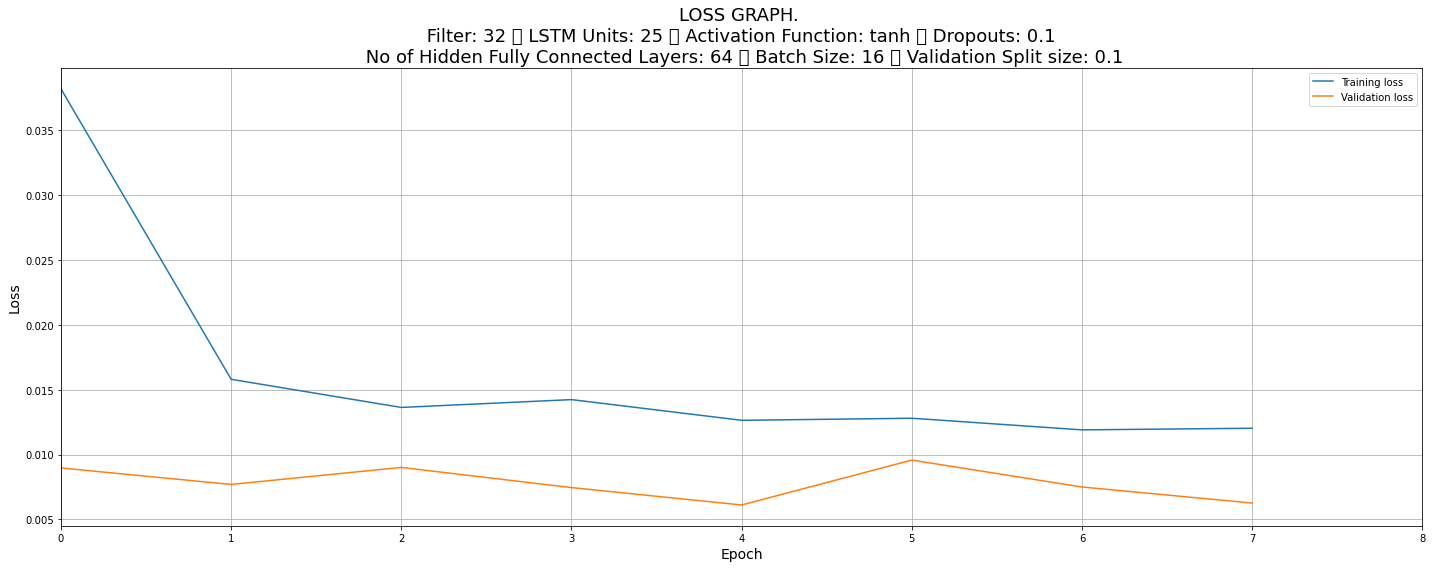

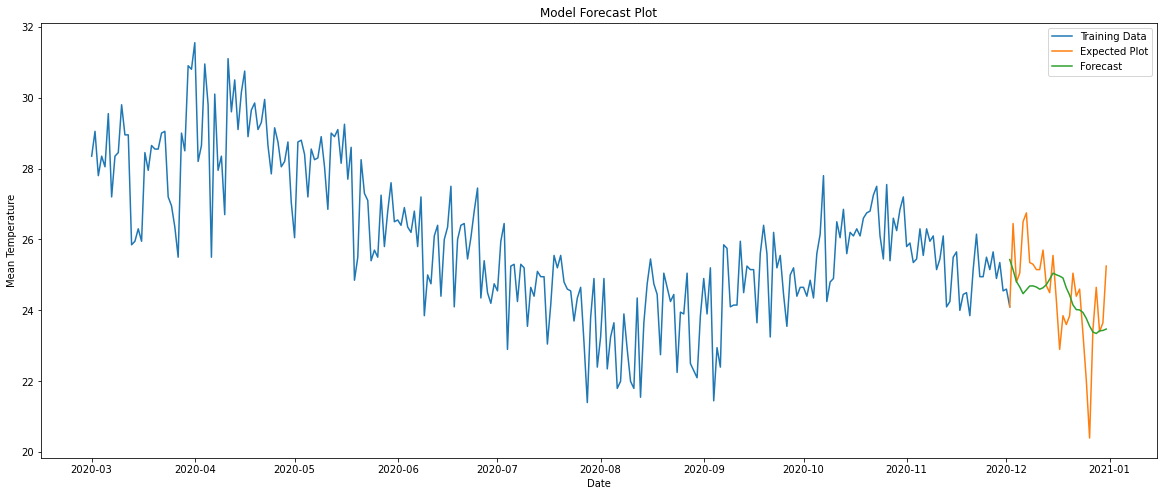









LSTM Model For:32 LSTM Units:50 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_38 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_112 (Bidirecti (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_113 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_114 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_112 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_112 (Dense)            (N

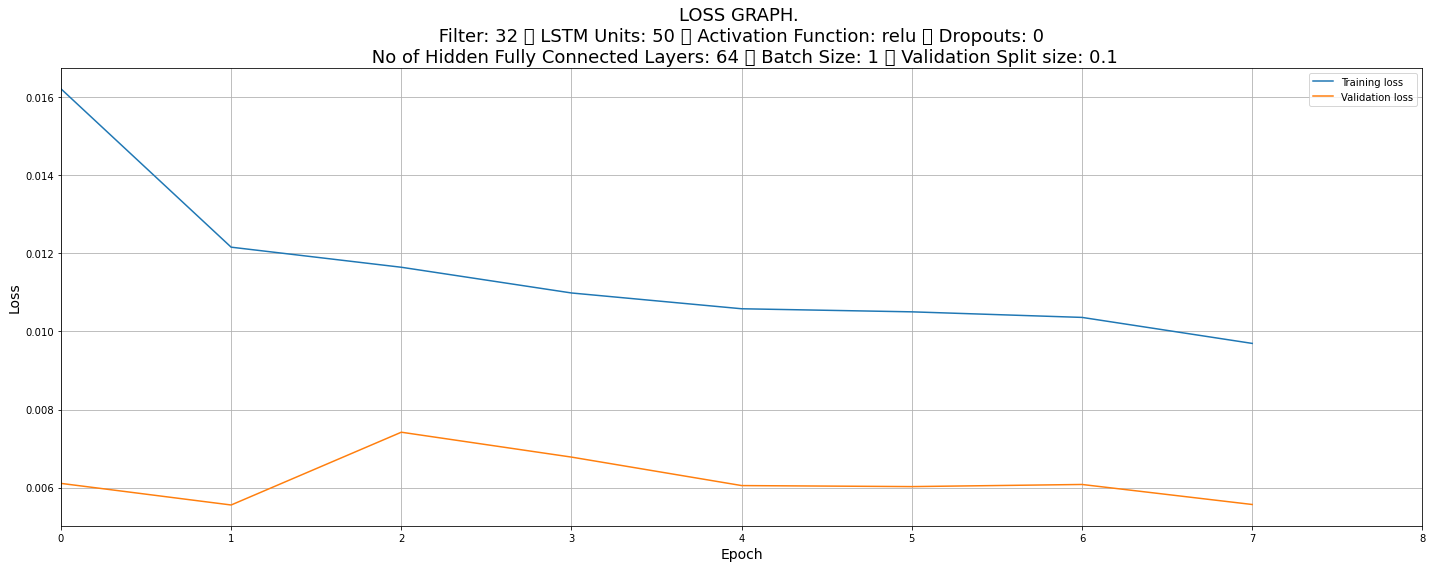

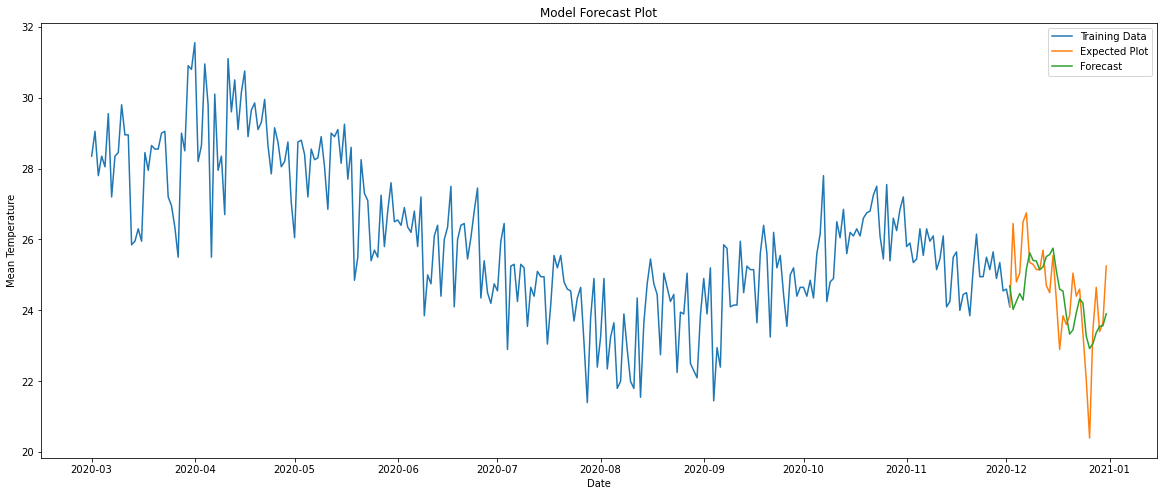









LSTM Model For:32 LSTM Units:50 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_115 (Bidirecti (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_116 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_117 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_115 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_115 (Dense)            (N

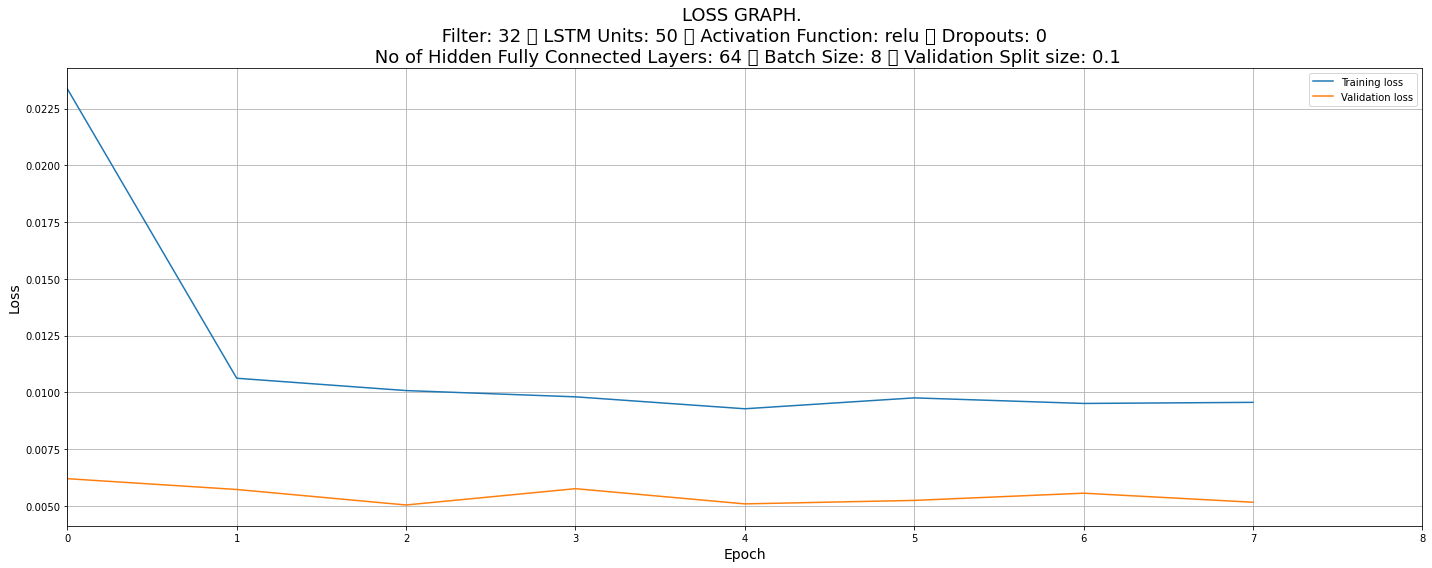

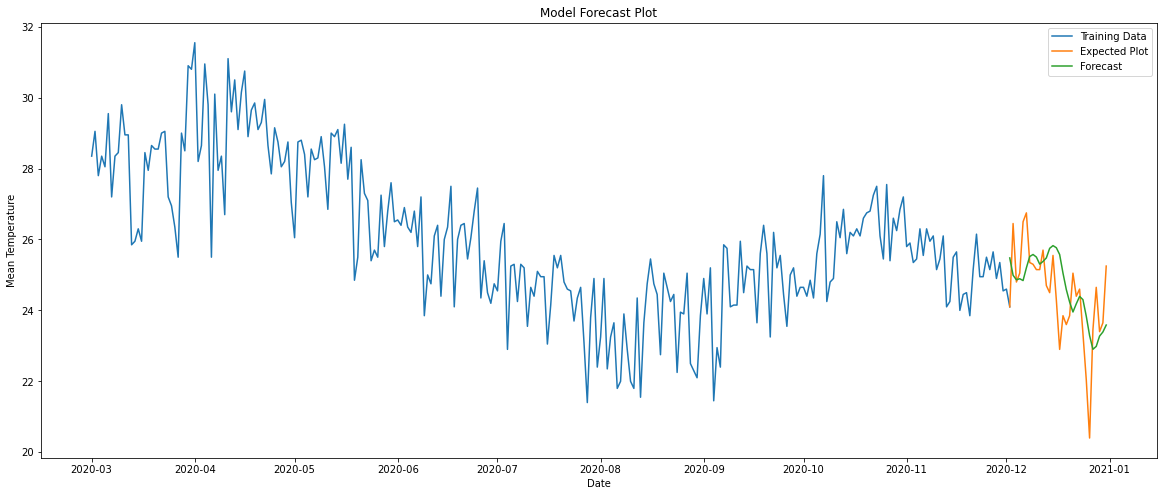









LSTM Model For:32 LSTM Units:50 Activation Function:relu Dropouts:0 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_118 (Bidirecti (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_119 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_120 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_118 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_118 (Dense)            (

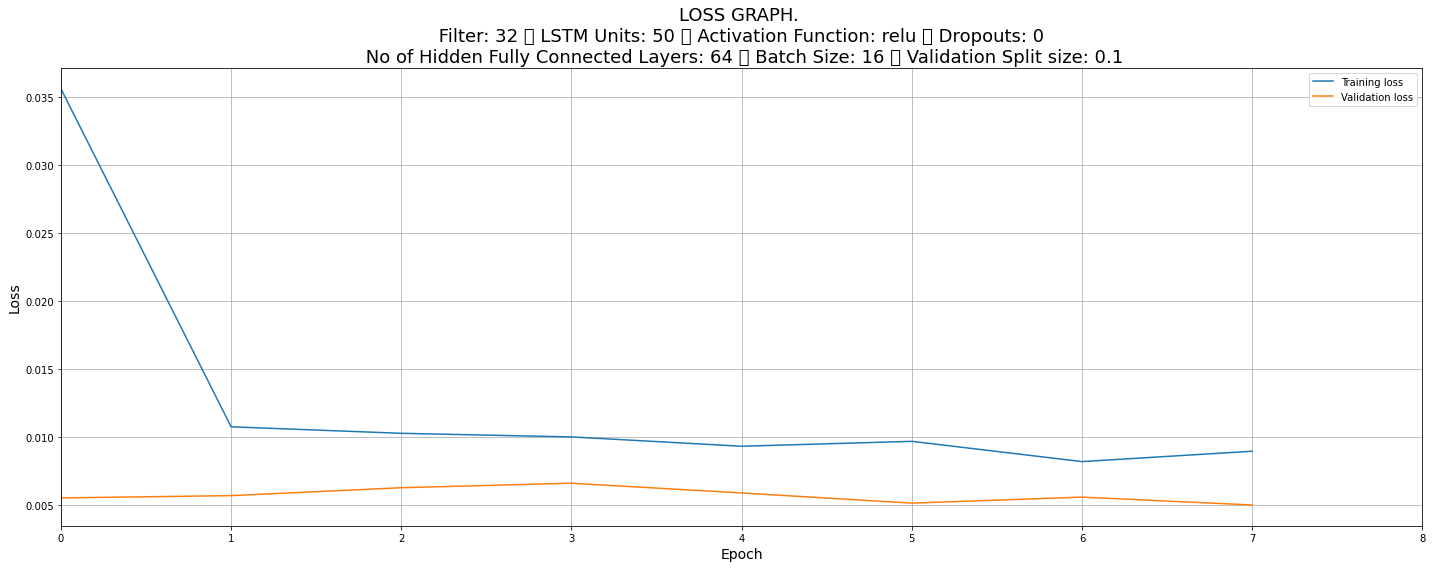

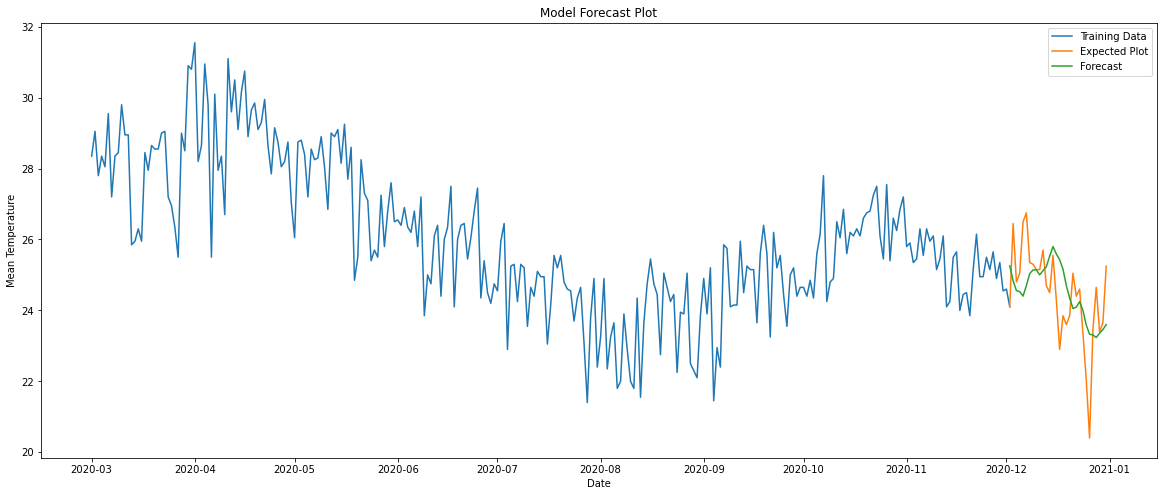









LSTM Model For:32 LSTM Units:50 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:1 Validation Split size:0.1
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_41 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_121 (Bidirecti (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_122 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_123 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_121 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_121 (Dense)            

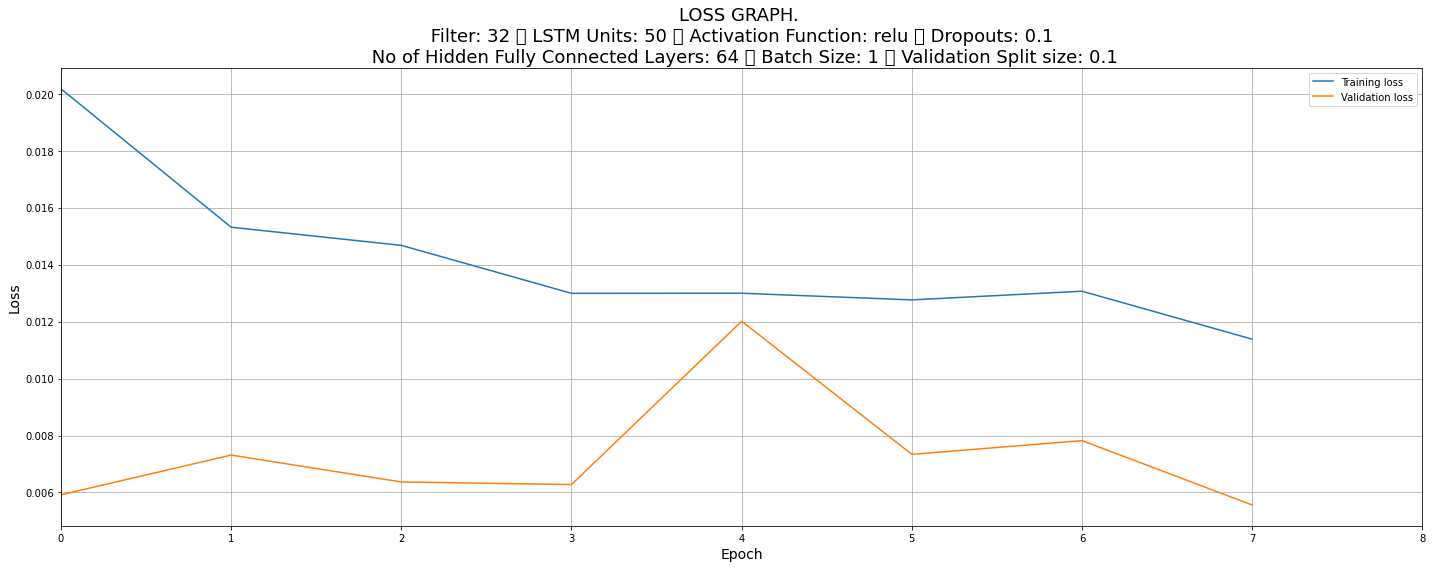

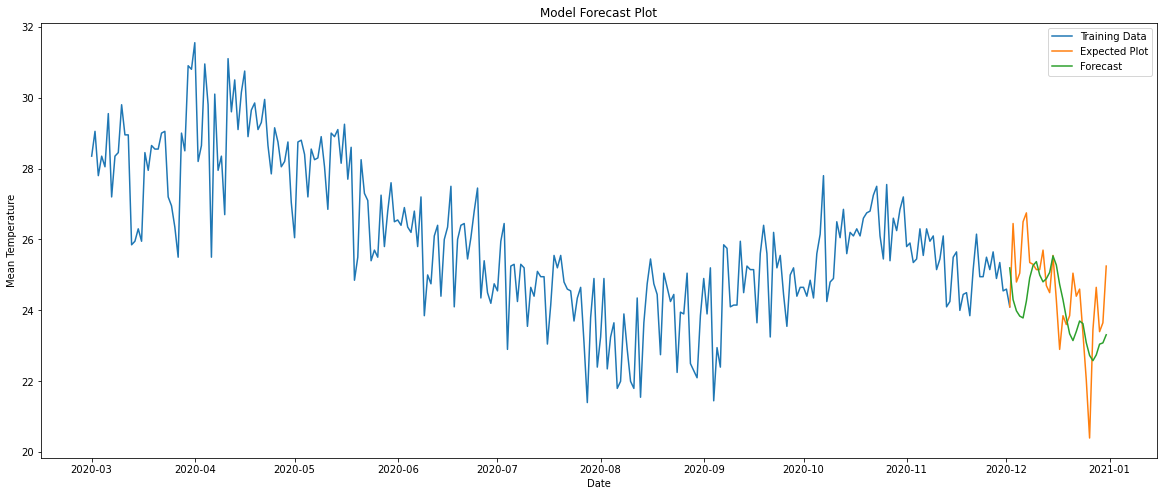









LSTM Model For:32 LSTM Units:50 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:8 Validation Split size:0.1
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 21, 32)            512       
_________________________________________________________________
bidirectional_124 (Bidirecti (None, 21, 100)           33200     
_________________________________________________________________
bidirectional_125 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_126 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_124 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_124 (Dense)            

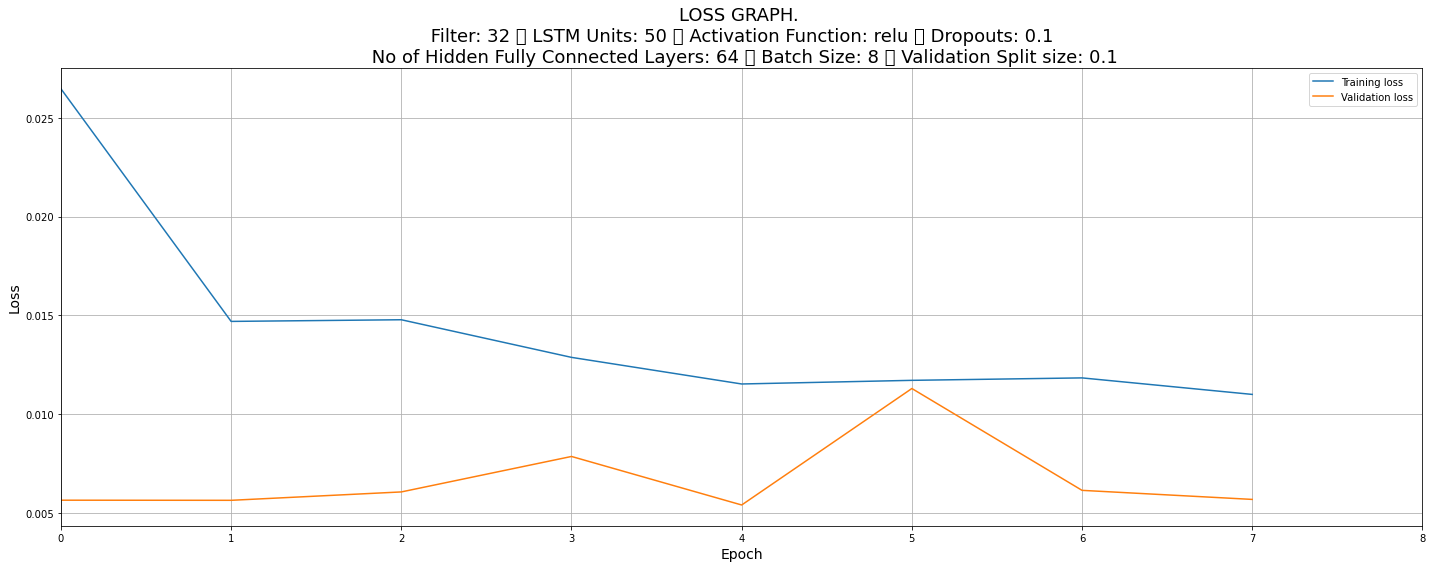

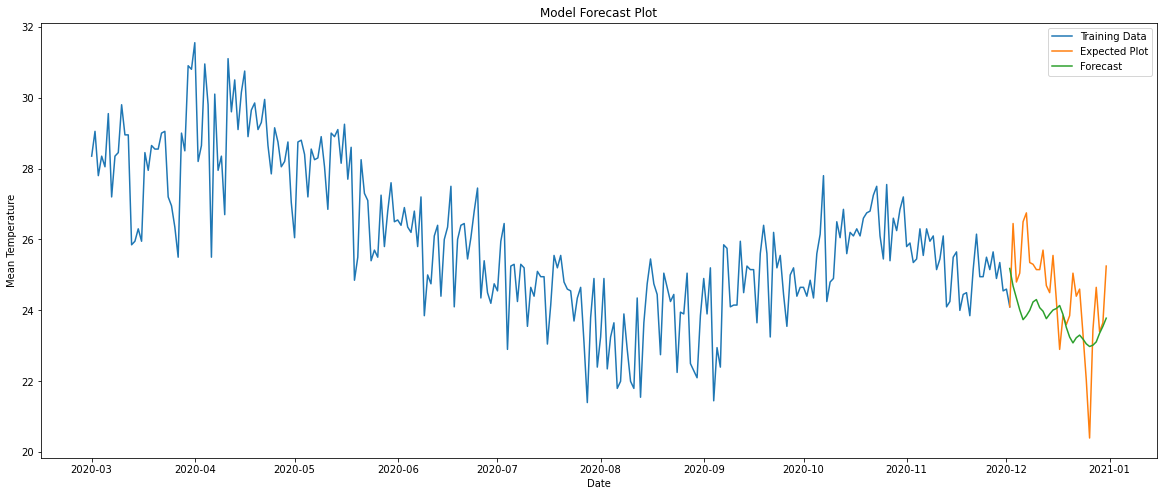









LSTM Model For:32 LSTM Units:50 Activation Function:relu Dropouts:0.1 No of Hidden Fully Connected Layers:64 Batch Size:16 Validation Split size:0.1


In [ ]:
list_filter = []
list_lstm_unit = []
list_activation = []
list_dropout = []
list_size = []


list_model = []
list_weather_model = []

list_rmse = []
list_r2score = []
list_train_loss = []
list_val_loss = []

for filters in [16, 32]:
    for lstm_unit in [25, 50]:
        for activation in ['relu', 'tanh']:
            for dropout in [0, 0.1]:
                for size in [1, 8, 16]:
                            
                    hidden_layers = 64
                    split = 0.1

                    hidden_layers_ = int(hidden_layers/2)

                    print(f"LSTM Model For:{filters} LSTM Units:{lstm_unit} Activation Function:{activation} Dropouts:{dropout} No of Hidden Fully Connected Layers:{hidden_layers} Batch Size:{size} Validation Split size:{split}")

                    model = Sequential()
                    model.add(Conv1D(filters=filters, kernel_size=3, strides=1, padding="causal", activation="relu", input_shape=(trainX.shape[1], trainX.shape[2])))
                    model.add(Bidirectional(LSTM(lstm_unit, activation=activation, return_sequences=True)))
                    model.add(Bidirectional(LSTM(lstm_unit, activation=activation, return_sequences=True)))
                    model.add(Bidirectional(LSTM(lstm_unit, activation=activation, return_sequences=False)))
                    model.add(Dropout(dropout))
                    model.add(Dense(hidden_layers))
                    model.add(Dropout(dropout))
                    model.add(Dense(hidden_layers_))
                    model.add(Dropout(dropout))
                    model.add(Dense(trainY.shape[1]))
                    model.compile(optimizer='adam', loss='mse')
                    model.summary()

                    weather_model = model.fit(trainX, trainY, epochs=8, batch_size=size, validation_split=split, verbose=1)

                    rmse, r2score = model_accuracy(model, testX, testY, True)
                    plot_loss_graph(weather_model, filters, lstm_unit, activation, dropout, hidden_layers, size, split)
                    model_forecast(testX, data_df, date_series, n_future = 30)                    

                    train_loss = min(weather_model.history['loss'])
                    val_loss = min(weather_model.history['val_loss'])

                    list_filter.append(filters)
                    list_lstm_unit.append(lstm_unit)
                    list_activation.append(activation)
                    list_dropout.append(dropout)
                    list_size.append(size)

                    list_model.append(model)
                    list_weather_model.append(weather_model)

                    list_rmse.append(rmse)
                    list_r2score.append(r2score)
                    list_train_loss.append(train_loss)
                    list_val_loss.append(val_loss)

                    print('\n\n\n\n\n\n\n')


hyperparameter_df = pd.DataFrame({'Convolution Filter':list_filter, 'LSTM Unit':list_lstm_unit, 'LSTM Activation Function':list_activation,
                                 'Dropout':list_dropout, 'Batch Size':list_size, 'Mean Square Error':list_rmse, 'R2 Score':list_r2score, 
                                  'Minimum Training Loss':list_train_loss, 'Minimum Validation Loss':list_val_loss})

hyperparameter_df.head()

##### Observations from the best Graph Plots

After careful observation of the 48 models and plots, the following were noted.

| Filter | LSTM Units | Activation Function | Dropout | Batch Size | Comment |
| --- | --- | --- | --- | --- | --- |
| 16 | 25 | tanh | 0 | 1 | Not too good though |
| 16 | 25 | tanh | 0.1 | 1 | Modelled the peak only |
| 16 | 50 | tanh | 0 | 1 | Very good model in both trend exactness and peak |
| 32 | 25 | tanh | 0 | 1 | Good trend but without values exactness  |

Let's take a look at the evaluation metrics as well.

In [51]:
hyperparameter_df = pd.DataFrame({'Convolution Filter':list_filter, 'LSTM Unit':list_lstm_unit, 'LSTM Activation Function':list_activation,
                                 'Dropout':list_dropout, 'Batch Size':list_size, 'Mean Square Error':list_rmse, 'R2 Score':list_r2score, 
                                  'Minimum Training Loss':list_train_loss, 'Minimum Validation Loss':list_val_loss})

hyperparameter_df

Convolution Filter  LSTM Unit LSTM Activation Function  Dropout  \
0                   16         25                     relu      0.0   
1                   16         25                     relu      0.0   
2                   16         25                     relu      0.0   
3                   16         25                     relu      0.1   
4                   16         25                     relu      0.1   
5                   16         25                     relu      0.1   
6                   16         25                     tanh      0.0   
7                   16         25                     tanh      0.0   
8                   16         25                     tanh      0.0   
9                   16         25                     tanh      0.1   
10                  16         25                     tanh      0.1   
11                  16         25                     tanh      0.1   
12                  16         50                     relu      0.0   
13                  16         50                     relu      0.0   
14                  16         50                     relu      0.0   
15                  16         50                     relu      0.1   
16                  16         50                     relu      0.1   
17                  16         50                     relu      0.1   
18                  16         50                     tanh      0.0   
19                  16         50                     tanh      0.0   
20                  16         50                     tanh      0.0   
21                  16         50                     tanh      0.1   
22                  16         50                     tanh      0.1   
23                  16         50                     tanh      0.1   
24                  32         25                     relu      0.0   
25                  32         25                     relu      0.0   
26                  32         25                     relu      0.0   
27                  32         25                     relu      0.1   
28                  32         25                     relu      0.1   
29                  32         25                     relu      0.1   
30                  32         25                     tanh      0.0   
31                  32         25                     tanh      0.0   
32                  32         25                     tanh      0.0   
33                  32         25                     tanh      0.1   
34                  32         25                     tanh      0.1   
35                  32         25                     tanh      0.1   
36                  32         50                     relu      0.0   
37                  32         50                     relu      0.0   
38                  32         50                     relu      0.0   
39                  32         50                     relu      0.1   
40                  32         50                     relu      0.1   
41                  32         50                     relu      0.1   
42                  32         50                     tanh      0.0   
43                  32         50                     tanh      0.0   
44                  32         50                     tanh      0.0   
45                  32         50                     tanh      0.1   
46                  32         50                     tanh      0.1   
47                  32         50                     tanh      0.1   

    Batch Size  Mean Square Error  R2 Score  Minimum Training Loss  \
0            1           0.020155 -1.330440               0.009196   
1            8           0.007402  0.144104               0.008416   
2           16           0.008243  0.046895               0.008778   
3            1           0.007361  0.148926               0.011368   
4            8           0.007974  0.078027               0.011849   
5           16           0.008620  0.003308               0.012467   
6            1           0.012773 

In [59]:
hyperparameter_df.shape

(48, 4)

In [53]:
hyperparameter_df.set_index(["Convolution Filter", "LSTM Unit", "LSTM Activation Function", "Dropout", "Batch Size"], 
                            inplace = True)

hyperparameter_df.head()

Mean Square Error  \
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size                      
16                 25        relu                     0.0     1                    0.020155   
                                                              8                    0.007402   
                                                              16                   0.008243   
                                                      0.1     1                    0.007361   
                                                              8                    0.007974   

                                                                          R2 Score  \
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size             
16                 25        relu                     0.0     1          -1.330440   
                                                              8           0.144104   
                                                              16          0.046895   
                                                      0.1     1           0.148926   
                                                              8           0.078027   

                                                                          Minimum Training Loss  \
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size                          
16                 25        relu                     0.0     1                        0.009196   
                                                              8                        0.008416   
                                                              16                       0.008778   
                                                      0.1     1                        0.011368   
                                                              8                        0.011849   

                                                                          Minimum Validation Loss  
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size                           
16                 25        relu                     0.0     1                          0.005524  
                                                              8                          0.005460  
                                                              16                         0.005033  
                                                      0.1     1                          0.005907  
                                                              8                          0.005883

Scaling the metrics and plotting for a better grasp of the entire evaluation

In [54]:
norm_hp_df = hyperparameter_df.copy()

for col in ['Mean Square Error', 'R2 Score', 'Minimum Training Loss', 'Minimum Validation Loss']:
    norm_hp_df[col] = norm_hp_df[col].apply(lambda x : (x - min(norm_hp_df[col]))/(max(norm_hp_df[col]) - min(norm_hp_df[col])))

norm_hp_df.head()

Mean Square Error  \
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size                      
16                 25        relu                     0.0     1                    0.790103   
                                                              8                    0.070454   
                                                              16                   0.117897   
                                                      0.1     1                    0.068101   
                                                              8                    0.102703   

                                                                          R2 Score  \
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size             
16                 25        relu                     0.0     1           0.209897   
                                                              8           0.929546   
                                                              16          0.882103   
                                                      0.1     1           0.931899   
                                                              8           0.897297   

                                                                          Minimum Training Loss  \
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size                          
16                 25        relu                     0.0     1                        0.273067   
                                                              8                        0.099923   
                                                              16                       0.180200   
                                                      0.1     1                        0.755790   
                                                              8                        0.862632   

                                                                          Minimum Validation Loss  
Convolution Filter LSTM Unit LSTM Activation Function Dropout Batch Size                           
16                 25        relu                     0.0     1                          0.343731  
                                                              8                          0.310869  
                                                              16                         0.090931  
                                                      0.1     1                          0.540730  
                                                              8                          0.528615

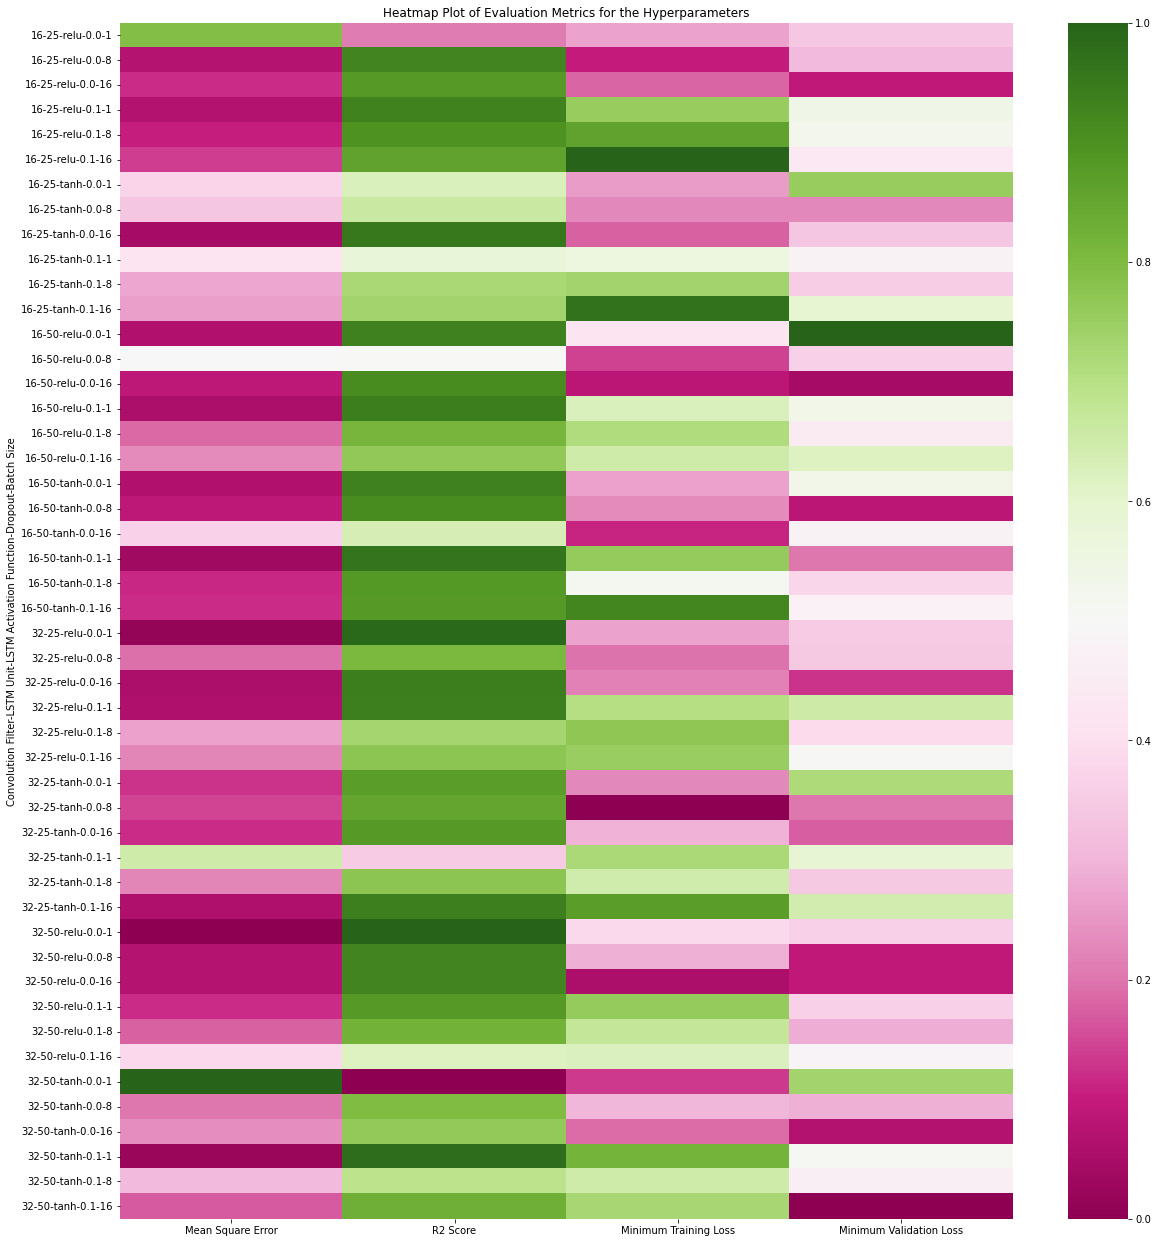

In [60]:
plt.figure(figsize=(20, 22))

plt.title('Heatmap Plot of Evaluation Metrics for the Hyperparameters')
sb.heatmap(norm_hp_df, cmap="PiYG")

plt.show()

For the four given evaluation metrics, the higher the value of R2 Score, the better. The reverse is true for others. Hence, we check for the hyperparameters that have green on the R2 Score and brown on the other three.

These are found for:

| Filter | LSTM Units | Activation Function | Dropout | Batch Size | Comment from graph |
| --- | --- | --- | --- | --- | --- |
| 16 | 25 | relu | 0 | 8 | Very poor prediction |
| 16 | 25 | relu | 0 | 16 | Very poor prediction |
| 16 | 25 | tanh | 0 | 16 | Very poor prediction |
| 16 | 50 | relu | 0 | 16 | Poor prediction |
| 16 | 50 | tanh | 0 | 8 | Poor prediction |
| 32 | 25 | tanh | 0 | 8 | A bit fair in approximating peaks and trends (but no closeness to exactness in trend) |
| 32 | 50 | relu | 0 | 16 | Very poor prediction |
| 32 | 50 | tanh | 0 | 16 | No graph displayed |

Hence, from the above notes, the evaluation metrics would not be considered in choosing the best model. Other evalutaion metric might be considered later to compare the predicted and the actual values.

__Now, let's return to the observations from the graph__

The graph:
    
| Filter | LSTM Units | Activation Function | Dropout | Batch Size | Comment |
| --- | --- | --- | --- | --- | --- |
| 16 | 25 | tanh | 0 | 1 | Not too good though |
| 16 | 25 | tanh | 0.1 | 1 | Modelled the peak only |
| 16 | 50 | tanh | 0 | 1 | Very good model in both trend exactness and peak |
| 32 | 25 | tanh | 0 | 1 | Good trend but without values exactness  |

The following can be noted from above:
1. The filter size of 32 could be an indication of a good trend
2. Dropout value of 0.1 could be a good model for peaks
3. LSTM Unit Nodes of 50 could be the best for both exactness and peak.
4. LSTM Activation of 'tanh' and the stochastic batch training i.e. batch sixze = 1 are the best.

But definitely, all the options or combinations above have been plotted and their results are not encouraging. Hence, further improvement can be attempted on the third model.

#### Testing different combinations to improve the best model

ERROR! Session/line number was not unique in database. History logging moved to new session 198
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_178 (Bidirecti (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_179 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_180 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_169 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_175 (Dense)            (None, 64)                6464      
_______________________

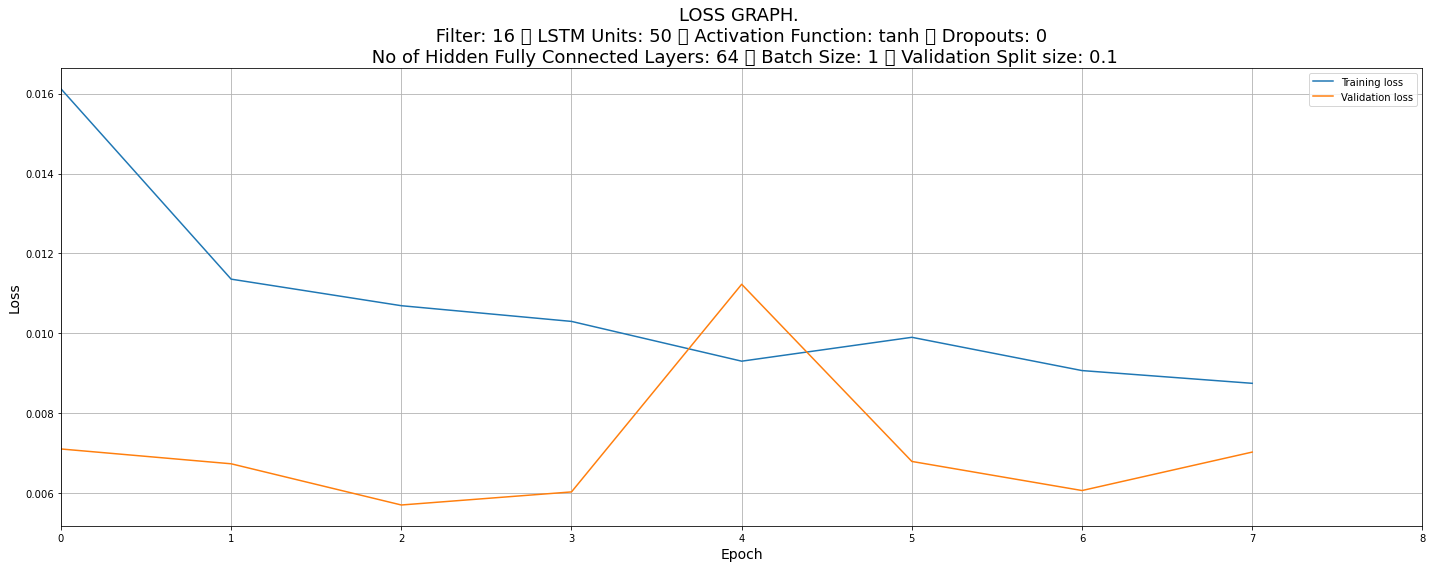

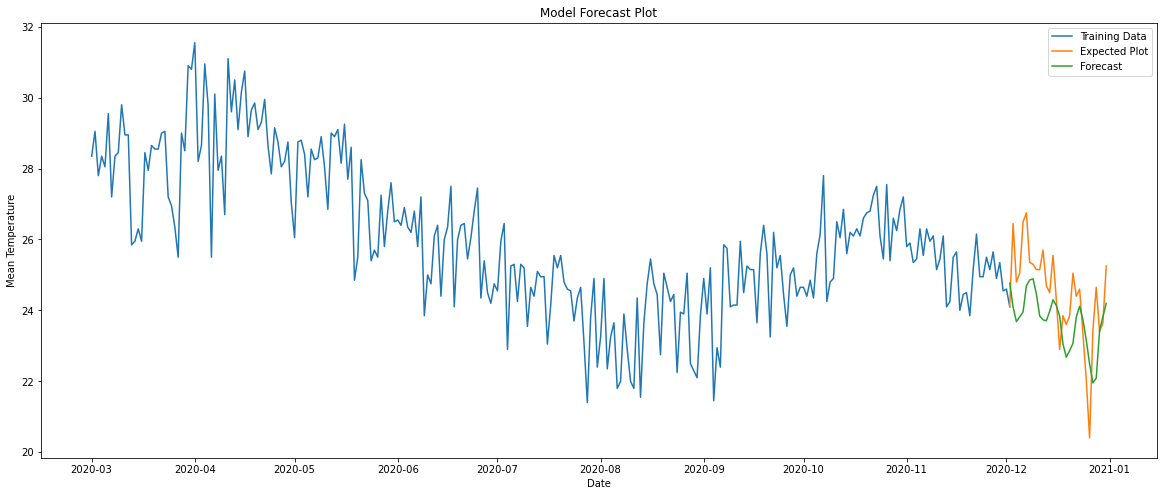

In [69]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding="causal", activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=False)))
model.add(Dropout(0))
model.add(Dense(64))
model.add(Dropout(0))
model.add(Dense(32))
model.add(Dropout(0))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

weather_model = model.fit(trainX, trainY, epochs=8, batch_size=1, validation_split=0.1, verbose=1)

plot_loss_graph(weather_model, 16, 50, 'tanh', 0, 64, 1, 0.1)
model_forecast(testX, data_df, date_series, n_future = 30)

Testing for a different activation function in the Conv1D - since 'tanh' is more promising.

Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_61 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_181 (Bidirecti (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_182 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_183 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_172 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_178 (Dense)            (None, 64)                6464      
_________________________________________________________________
dropout_173 (Dropout)        (None, 64)              

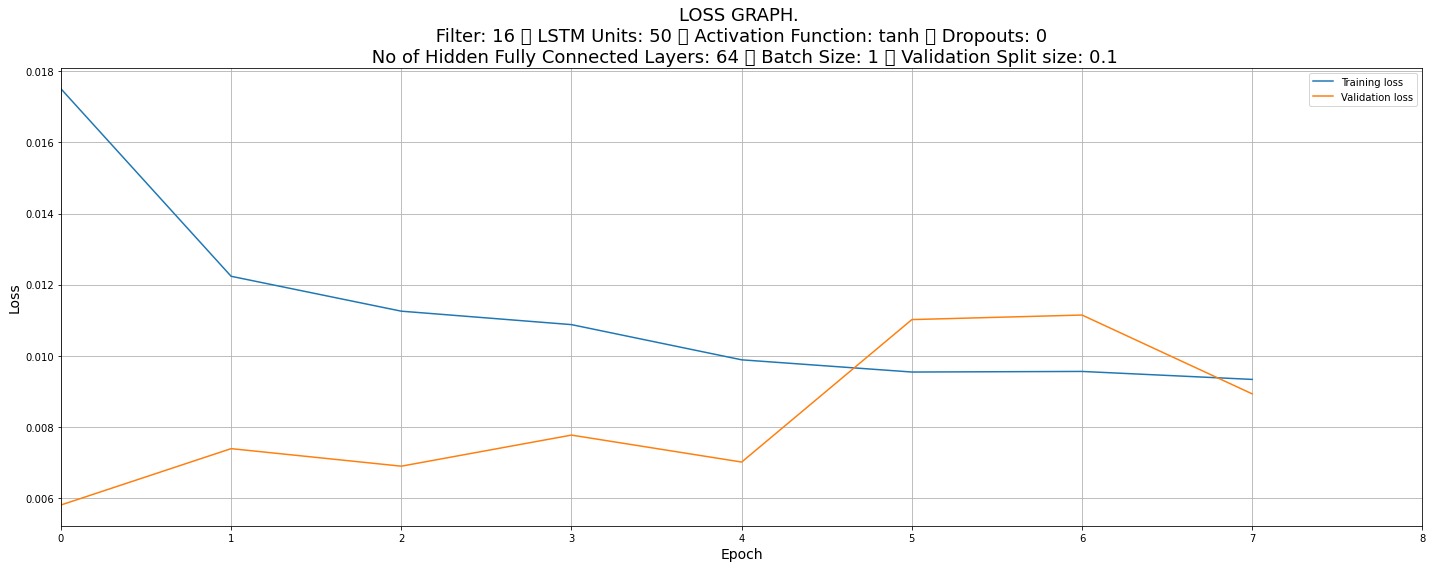

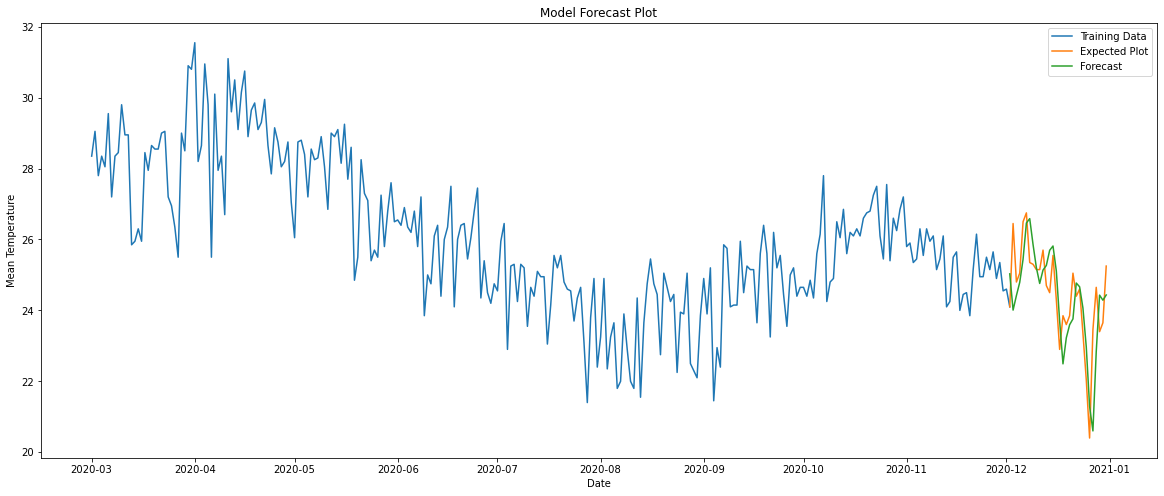

In [70]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding="causal", activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=False)))
model.add(Dropout(0))
model.add(Dense(64))
model.add(Dropout(0))
model.add(Dense(32))
model.add(Dropout(0))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

weather_model = model.fit(trainX, trainY, epochs=8, batch_size=1, validation_split=0.1, verbose=1)

plot_loss_graph(weather_model, 16, 50, 'tanh', 0, 64, 1, 0.1)
model_forecast(testX, data_df, date_series, n_future = 30)

Hence, from the above, the 'tanh' activation function for the Conv1D gives a better result.

Now, parameter tuning for different epochs.

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_62 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_184 (Bidirecti (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_185 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_186 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_175 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_181 (Dense)            (None, 64)                6464      
_________________________________________________________________
dropout_176 (Dropout)        (None, 64)              

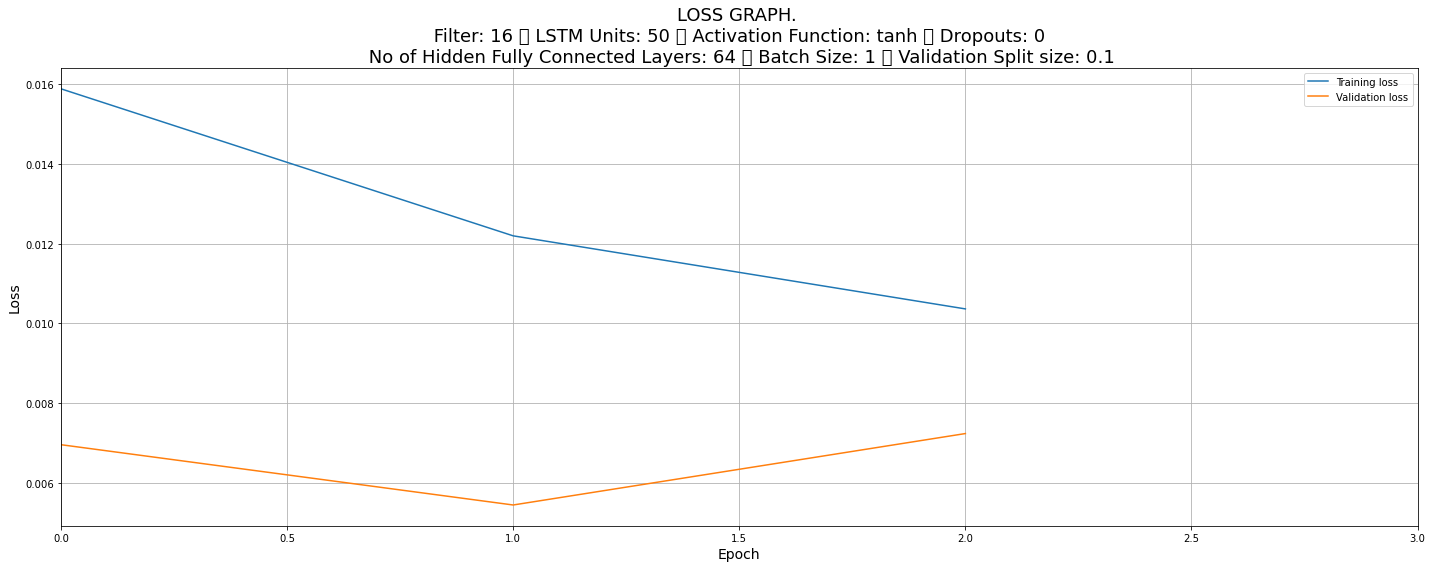

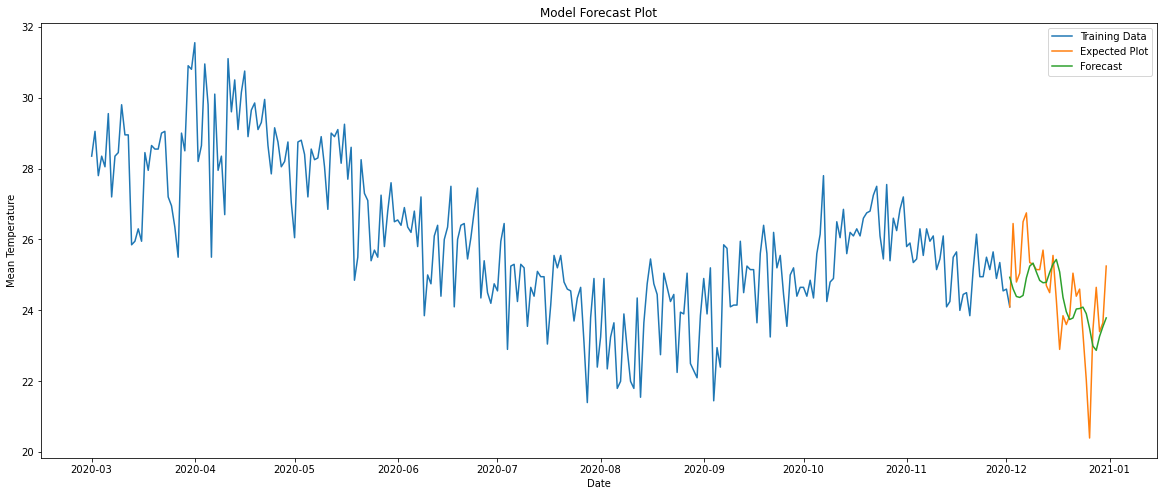









Train on 940 samples, validate on 105 samples
Epoch 1/6
940/940 [==============================] - 67s 72ms/step - loss: 0.0103 - val_loss: 0.0067
Epoch 2/6
940/940 [==============================] - 66s 71ms/step - loss: 0.0103 - val_loss: 0.0081
Epoch 3/6
940/940 [==============================] - 67s 72ms/step - loss: 0.0098 - val_loss: 0.0195
Epoch 4/6
940/940 [==============================] - 67s 71ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 5/6
940/940 [==============================] - 67s 71ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 6/6
940/940 [==============================] - 71s 75ms/step - loss: 0.0090 - val_loss: 0.0138


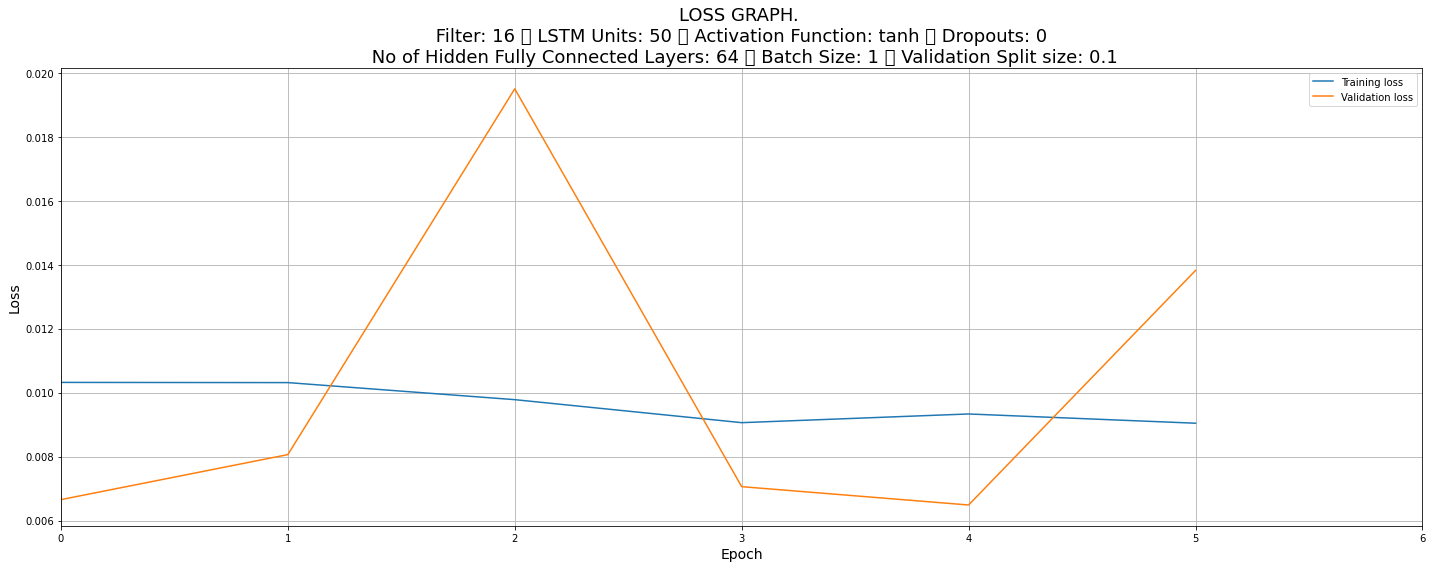

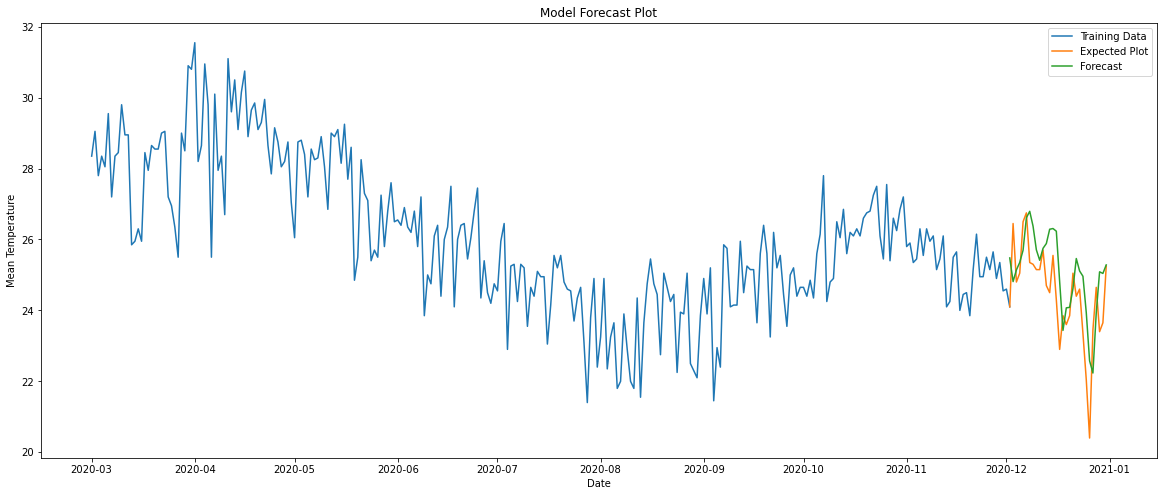









Train on 940 samples, validate on 105 samples
Epoch 1/9
940/940 [==============================] - 74s 78ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 2/9
940/940 [==============================] - 72s 77ms/step - loss: 0.0083 - val_loss: 0.0068
Epoch 3/9
940/940 [==============================] - 73s 77ms/step - loss: 0.0084 - val_loss: 0.0065
Epoch 4/9
940/940 [==============================] - 72s 76ms/step - loss: 0.0082 - val_loss: 0.0072
Epoch 5/9
940/940 [==============================] - 72s 77ms/step - loss: 0.0084 - val_loss: 0.0069
Epoch 6/9
940/940 [==============================] - 71s 76ms/step - loss: 0.0086 - val_loss: 0.0066
Epoch 7/9
940/940 [==============================] - 71s 75ms/step - loss: 0.0078 - val_loss: 0.0069
Epoch 8/9
940/940 [==============================] - 71s 76ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 9/9
940/940 [==============================] - 71s 76ms/step - loss: 0.0078 - val_loss: 0.0070


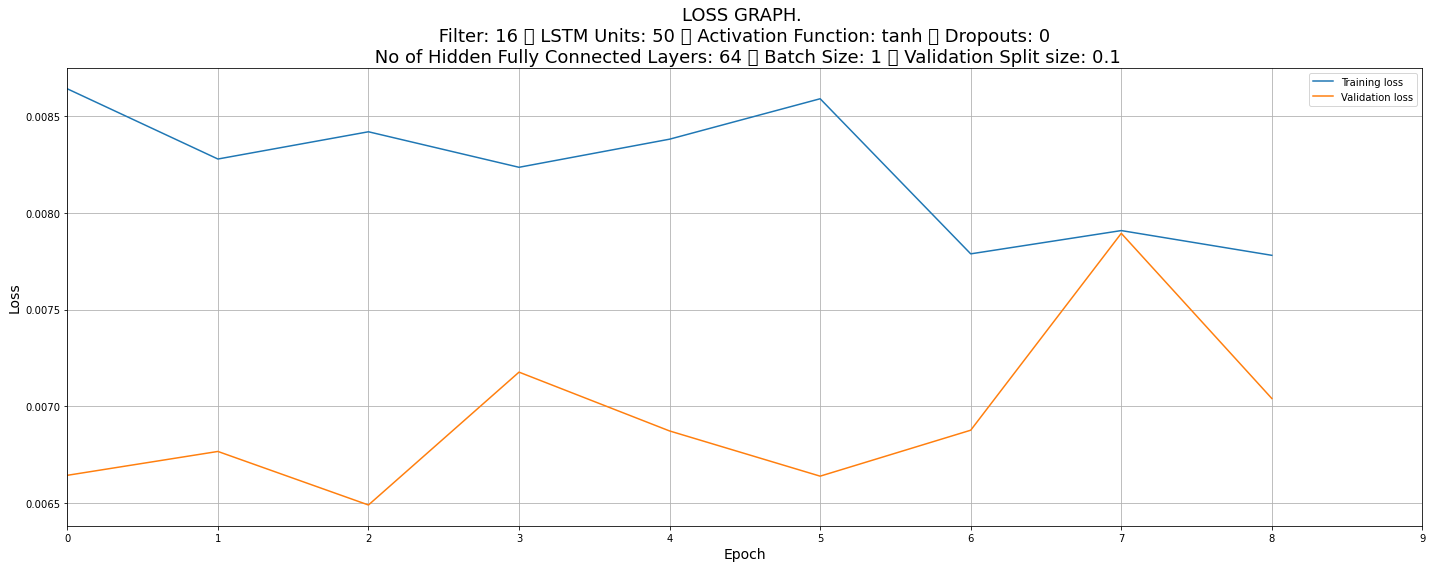

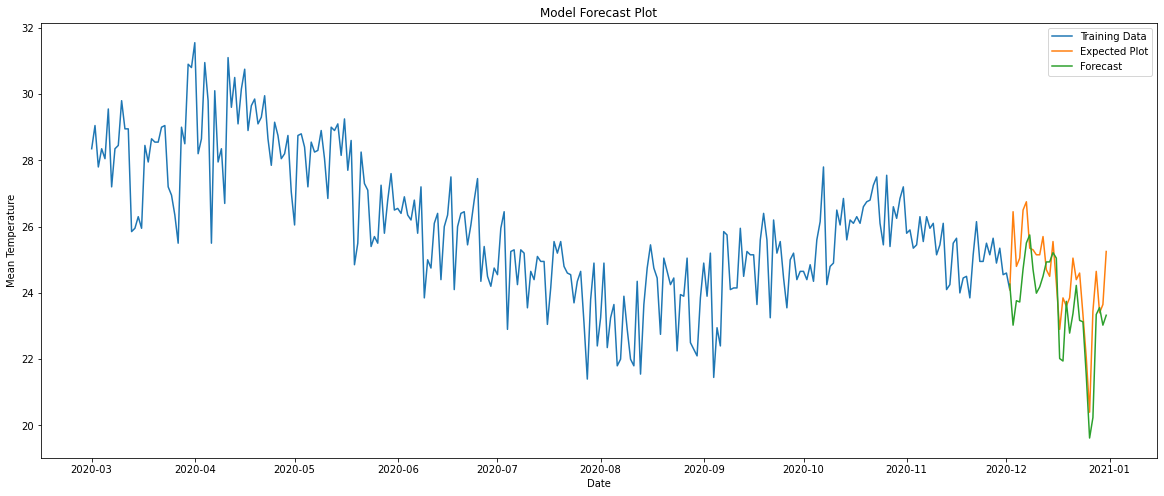









Train on 940 samples, validate on 105 samples
Epoch 1/12
940/940 [==============================] - 69s 73ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 2/12
940/940 [==============================] - 69s 73ms/step - loss: 0.0081 - val_loss: 0.0068
Epoch 3/12
940/940 [==============================] - 69s 74ms/step - loss: 0.0076 - val_loss: 0.0081
Epoch 4/12
940/940 [==============================] - 70s 74ms/step - loss: 0.0076 - val_loss: 0.0113
Epoch 5/12
940/940 [==============================] - 70s 74ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 6/12
940/940 [==============================] - 69s 74ms/step - loss: 0.0073 - val_loss: 0.0079
Epoch 7/12
940/940 [==============================] - 69s 73ms/step - loss: 0.0074 - val_loss: 0.0075
Epoch 8/12
940/940 [==============================] - 74s 79ms/step - loss: 0.0075 - val_loss: 0.0066
Epoch 9/12
940/940 [==============================] - 70s 74ms/step - loss: 0.0072 - val_loss: 0.0074
Epoch 10/12
940/940 [=======

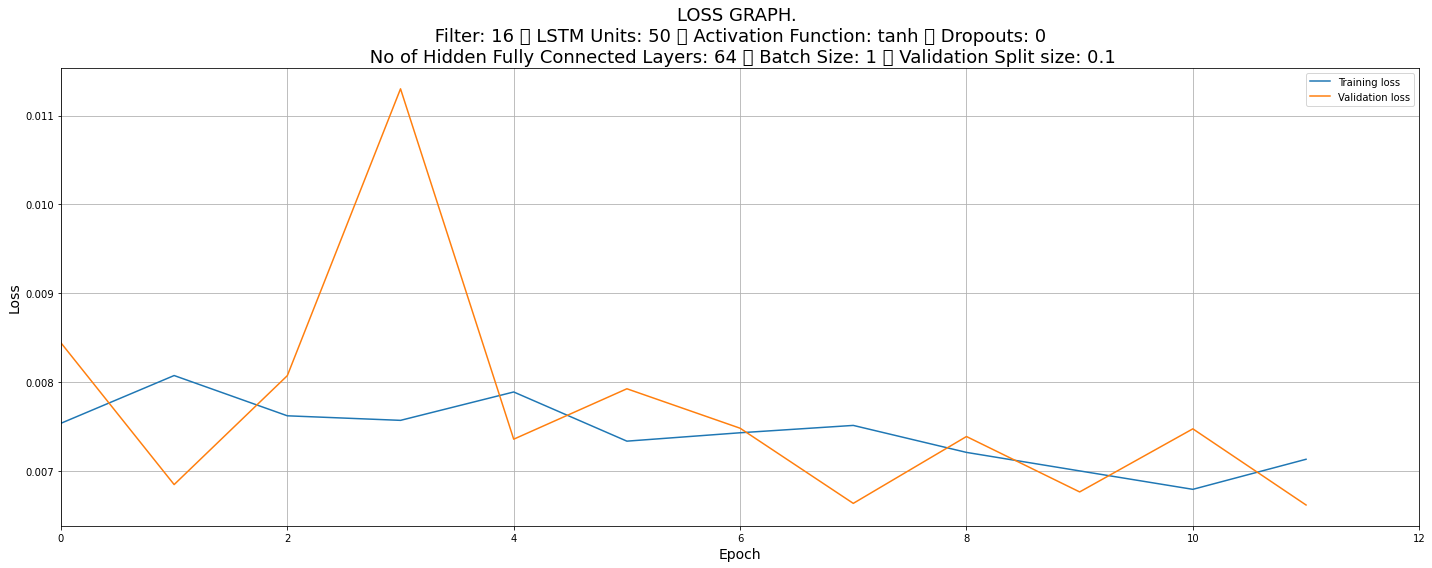

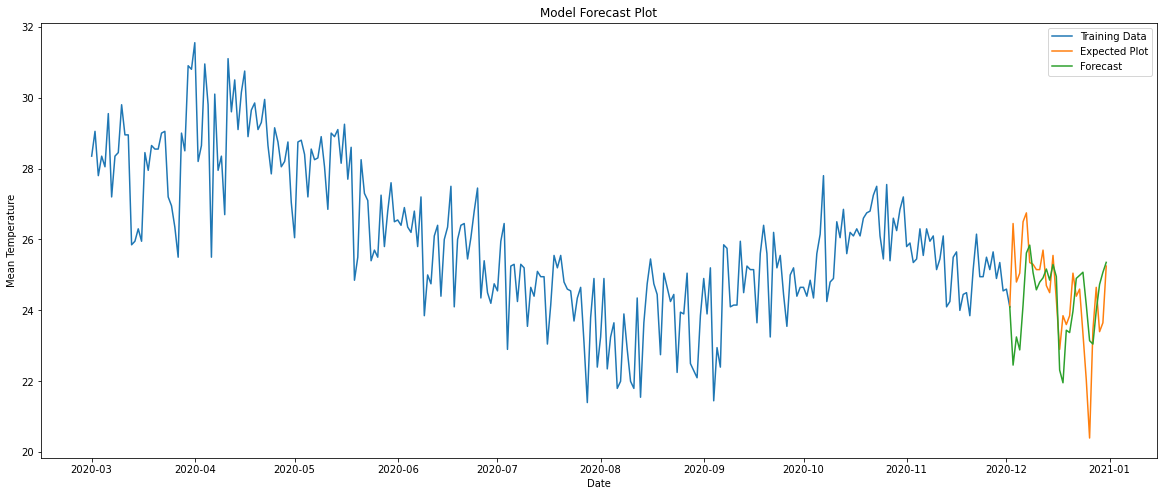









Train on 940 samples, validate on 105 samples
Epoch 1/15
940/940 [==============================] - 71s 75ms/step - loss: 0.0067 - val_loss: 0.0082
Epoch 2/15
940/940 [==============================] - 70s 74ms/step - loss: 0.0066 - val_loss: 0.0073
Epoch 3/15
940/940 [==============================] - 69s 73ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 4/15
940/940 [==============================] - 69s 73ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 5/15
940/940 [==============================] - 68s 73ms/step - loss: 0.0063 - val_loss: 0.0069
Epoch 6/15
940/940 [==============================] - 70s 74ms/step - loss: 0.0067 - val_loss: 0.0068
Epoch 7/15
940/940 [==============================] - 68s 72ms/step - loss: 0.0062 - val_loss: 0.0083
Epoch 8/15
940/940 [==============================] - 71s 75ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 9/15
940/940 [==============================] - 78s 83ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 10/15
940/940 [=======

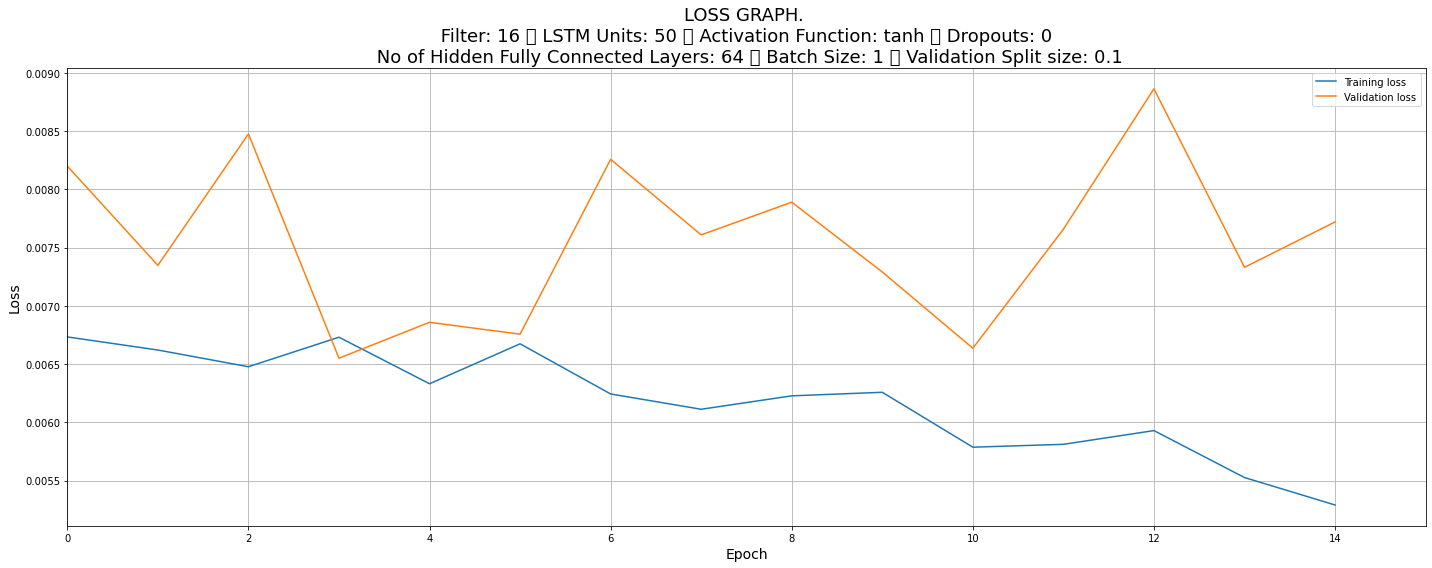

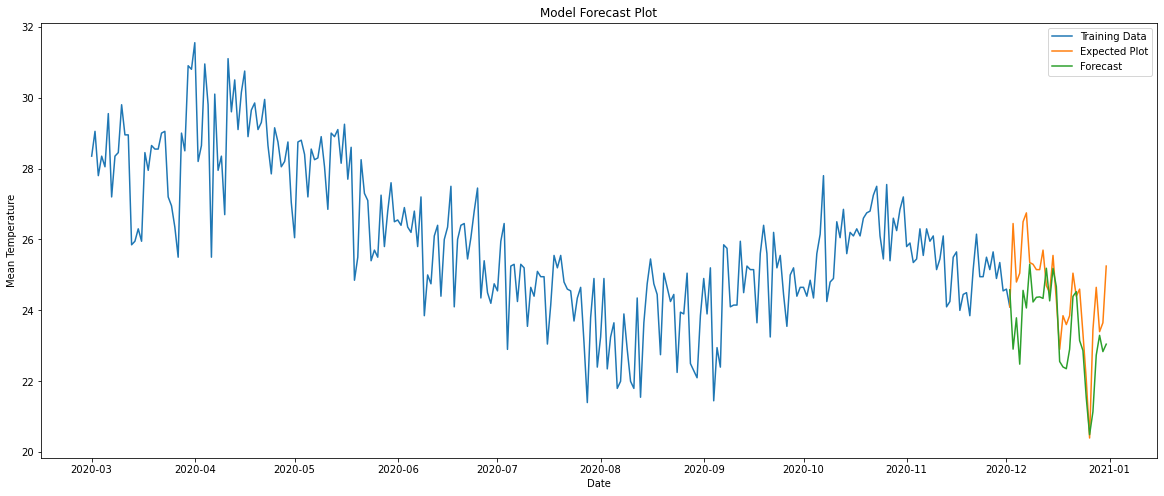

In [71]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=3, strides=1, padding="causal", activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=False)))
model.add(Dropout(0))
model.add(Dense(64))
model.add(Dropout(0))
model.add(Dense(32))
model.add(Dropout(0))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

for epoch in [3, 6, 9, 12, 15]:
    weather_model = model.fit(trainX, trainY, epochs=epoch, batch_size=1, validation_split=0.1, verbose=1)

    plot_loss_graph(weather_model, 16, 50, 'tanh', 0, 64, 1, 0.1)
    model_forecast(testX, data_df, date_series, n_future = 30)
    
    print('\n\n\n\n\n\n\n')

From the foregoing, the best model for the weather prediction is that obtained after 8 epochs of training.

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_70 (Conv1D)           (None, 21, 16)            256       
_________________________________________________________________
bidirectional_208 (Bidirecti (None, 21, 100)           26800     
_________________________________________________________________
bidirectional_209 (Bidirecti (None, 21, 100)           60400     
_________________________________________________________________
bidirectional_210 (Bidirecti (None, 100)               60400     
_________________________________________________________________
dropout_199 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_205 (Dense)            (None, 64)                6464      
_________________________________________________________________
dropout_200 (Dropout)        (None, 64)              

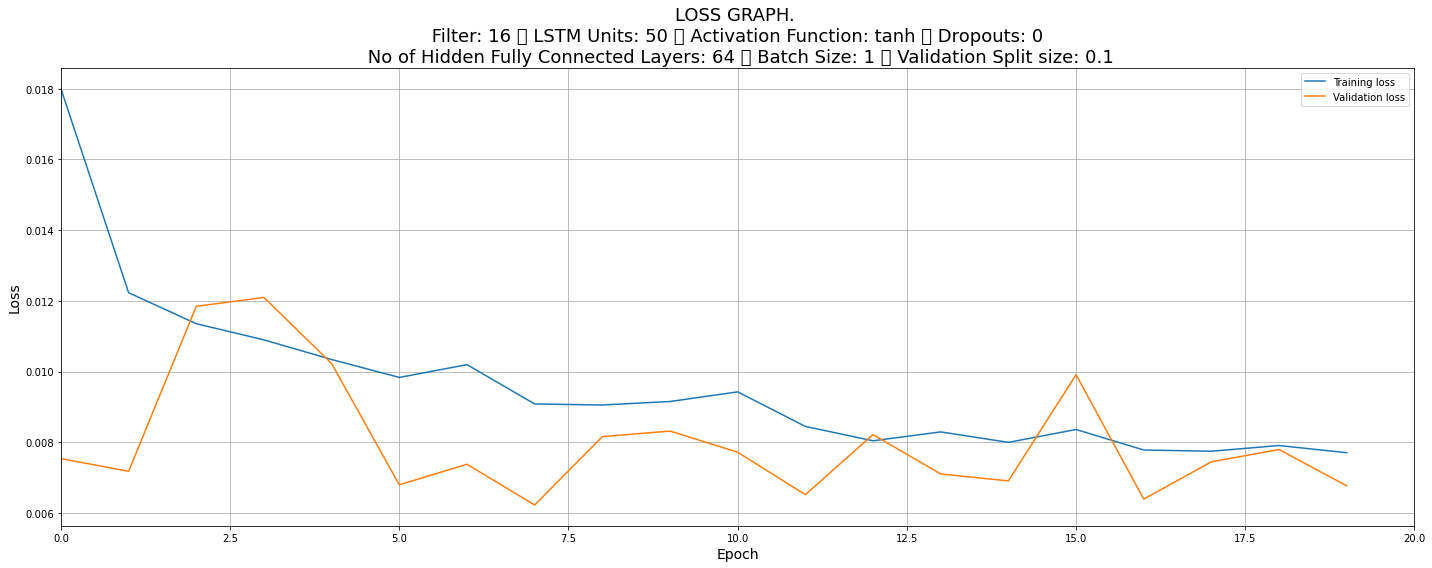

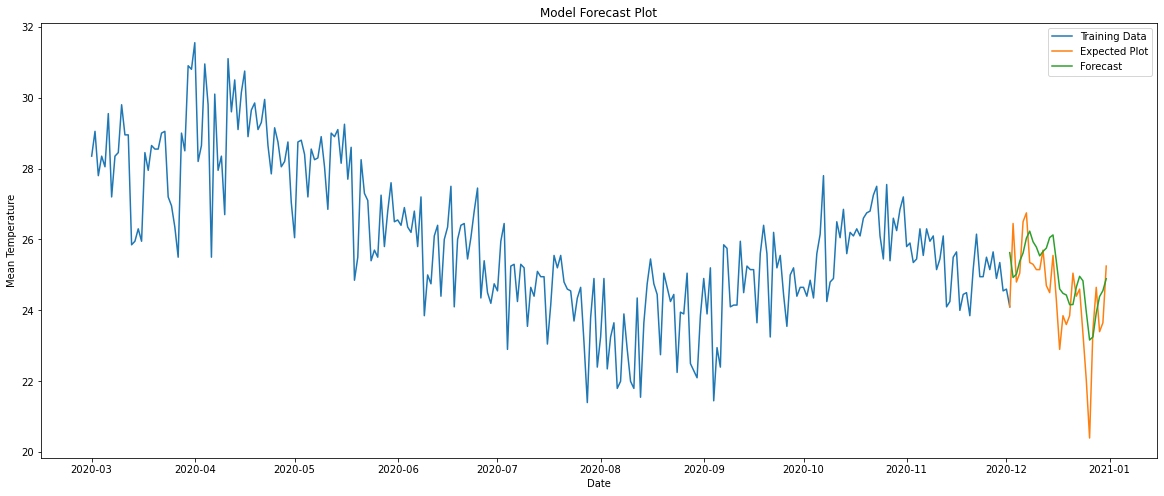

In [81]:
mymodel = Sequential()
mymodel.add(Conv1D(filters=16, kernel_size=3, strides=1, padding="causal", activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2])))
mymodel.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
mymodel.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=True)))
mymodel.add(Bidirectional(LSTM(50, activation='tanh', return_sequences=False)))
mymodel.add(Dropout(0))
mymodel.add(Dense(64))
mymodel.add(Dropout(0))
mymodel.add(Dense(32))
mymodel.add(Dropout(0))
mymodel.add(Dense(trainY.shape[1]))
mymodel.compile(optimizer='adam', loss='mse')
mymodel.summary()

weather_model = mymodel.fit(trainX, trainY, epochs=20, batch_size=1, validation_split=0.1, verbose=1)

plot_loss_graph(weather_model, 16, 50, 'tanh', 0, 64, 1, 0.1)
model_forecast(testX, data_df, date_series, n_future = 30)

## Saving the models

In [82]:
import pickle

pickle.dump(mymodel, open('lstm_model.sav', 'wb'))
pickle.dump(scaler, open('data_scaler.sav', 'wb'))

# End